# Tuning the two layer model

In [1]:
from openscm_twolayermodel import TwoLayerModel
from openscm_twolayermodel.constants import DENSITY_WATER, HEAT_CAPACITY_WATER
import numpy as np
import scipy.stats as st
import pandas as pd
import statsmodels.api as sm
import glob
import matplotlib.pyplot as pl
import warnings
import json
from scipy.interpolate import interp1d
from openscm_units import unit_registry as ur
from scmdata import ScmRun
warnings.simplefilter('ignore')

/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/base.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdman


In [2]:
pl.rcParams['figure.figsize'] = (12/2.54, 12/2.54)
pl.rcParams['font.size'] = 8
pl.rcParams['font.family'] = 'Arial'
pl.rcParams['xtick.direction'] = 'out'
pl.rcParams['xtick.minor.visible'] = True
pl.rcParams['ytick.minor.visible'] = True
pl.rcParams['ytick.right'] = True
pl.rcParams['xtick.top'] = True
pl.rcParams['figure.dpi'] = 96

In [3]:
models = ['ACCESS-CM2',
 'ACCESS-ESM1-5',
 'AWI-CM-1-1-MR',
 'AWI-ESM-1-1-LR',
 'BCC-CSM2-MR',
 'BCC-ESM1',
 'CAMS-CSM1-0',
 'CAS-ESM2-0',
 'CESM2',
 'CESM2-FV2',
 'CESM2-WACCM',
 'CESM2-WACCM-FV2',
 'CNRM-CM6-1',
 'CNRM-CM6-1-HR',
 'CNRM-ESM2-1',
 'CanESM5',
 'E3SM-1-0',
 'E3SM-1-1',
 'E3SM-1-1-ECA',
 'EC-Earth3',
 'EC-Earth3-Veg',
 'FGOALS-f3-L',
 'FGOALS-g3',
 'FIO-ESM-2-0',
 'GFDL-CM4',
 'GFDL-ESM4',
 'GISS-E2-1-G',
 'GISS-E2-1-G-CC',
 'GISS-E2-1-H',
 'GISS-E2-2-G',
 'HadGEM3-GC31-LL',
 'HadGEM3-GC31-MM',
 'IITM-ESM',
 'INM-CM4-8',
 'INM-CM5-0',
 'IPSL-CM6A-LR',
 'KIOST-ESM',
 'MCM-UA-1-0',
 'MIROC-ES2L',
 'MIROC6',
 'MPI-ESM1-2-HAM',
 'MPI-ESM1-2-HR',
 'MPI-ESM1-2-LR',
 'MRI-ESM2-0',
 'NESM3',
 'NESM3',
 'NorCPM1',
 'NorESM1-F',
 'NorESM2-LM',
 'NorESM2-MM',
 'SAM0-UNICON',
 'TaiESM1',
 'UKESM1-0-LL']

In [4]:
piControl = {}
abrupt4xCO2 = {}
F4x_gregory = {}
eff = {}
lambda0 = {}
C = {}
C0 = {}
gamma = {}
nyears = {}
N = {}
T = {}
T4x_gregory = {}
hflux = {}
lam_eff = {}
ohc = {}
qtot = {}
tg = {}
tlev = {}
time = {}
tu = {}
tl = {}
du = {}
dl = {}

accepted_models = []

# Models only provided r1 in any seriousness. GISS and CanESM have a couple of variants, we'll stick to r1 for consistency.
for model in models:
    piControl[model] = {}
    abrupt4xCO2[model] = {}
    if model=='EC-Earth3':
        dir4co2 = glob.glob('../data_input/cmip6/%s/abrupt-4xCO2/r8i*/' % model)
    else:
        dir4co2 = glob.glob('../data_input/cmip6/%s/abrupt-4xCO2/r1i*/' % model)
    dirpiC  = glob.glob('../data_input/cmip6/%s/piControl/r1i*/' % model)
    if model=='CanESM5' or model=='GISS-E2-1-G':
        dir4co2 = [x for x in dir4co2 if 'r1i1p1f1' in x]
        dirpiC  = [x for x in dirpiC if 'r1i1p1f1' in x]
    # experiment missing? skip model
    if len(dir4co2)==0 or len(dirpiC)==0:
        continue
    dir4co2 = dir4co2[0]
    dirpiC  = dirpiC[0]
    piControl[model]['rsdt'] = np.loadtxt(dirpiC + 'rsdt.txt')
    piControl[model]['rsut'] = np.loadtxt(dirpiC + 'rsut.txt')
    piControl[model]['rlut'] = np.loadtxt(dirpiC + 'rlut.txt')
    piControl[model]['tas']  = np.loadtxt(dirpiC + 'tas.txt')
    abrupt4xCO2[model]['rsdt'] = np.loadtxt(dir4co2 + 'rsdt.txt')
    abrupt4xCO2[model]['rsut'] = np.loadtxt(dir4co2 + 'rsut.txt')
    abrupt4xCO2[model]['rlut'] = np.loadtxt(dir4co2 + 'rlut.txt')
    abrupt4xCO2[model]['tas']  = np.loadtxt(dir4co2 + 'tas.txt')

    f = open(dir4co2 + 'meta.txt')
    timedata = f.read().split()
    f.close()

    calendar = timedata[-1]
    branchtime = float(timedata[1])
    if calendar in ['gregorian', 'standard', 'proleptic_gregorian', 'ISO8601', 'julian']:
        daysinyear = 365.2425   # long term average
    elif calendar in ['365_day', 'noleap']:
        daysinyear = 365
    elif calendar in ['366_day', 'all_leap']:
        daysinyear = 366
    elif calendar in ['360_day', 'uniform30day']:
        daysinyear = 360
    years_offset = int(np.round(branchtime/daysinyear))
    nyears[model] = len(abrupt4xCO2[model]['rsdt'])
    print(model, nyears[model], years_offset)
    if years_offset>len(piControl[model]['tas']):
        years_offset = 0  # some models have funny values of branch time
    if years_offset+nyears[model] > len(piControl[model]['tas']):
        nyears[model] = len(piControl[model]['tas']) - years_offset
    if nyears[model] < 150:
        continue
    # if we get this far, things have worked out well
    accepted_models.append(model)
    if model=='MCM-UA-1-0':
        N[model] = abrupt4xCO2[model]['rtmt'][:nyears[model]] - piControl[model]['rtmt'][:nyears[model]]
    else:
        N[model] = (
            (abrupt4xCO2[model]['rsdt'][:nyears[model]] - abrupt4xCO2[model]['rsut'][:nyears[model]] - abrupt4xCO2[model]['rlut'][:nyears[model]])-
            (piControl[model]['rsdt'][years_offset:years_offset+nyears[model]] - piControl[model]['rsut'][years_offset:years_offset+nyears[model]] - piControl[model]['rlut'][years_offset:years_offset+nyears[model]])
        )

    T[model] = abrupt4xCO2[model]['tas'][:nyears[model]] - piControl[model]['tas'][years_offset:years_offset+nyears[model]]
    
    lambda0[model], F4x_gregory[model], _, _, _ = st.linregress(T[model],N[model])
    eff[model] = 1
    
    # main iteration:
    for i in range(50):  # need better convergence criteria
        # step 1: fit EBM-1 to obtain C, C0 and gamma
        T4x_gregory[model] = F4x_gregory[model]/-lambda0[model]
        minus_1_over_tau_s, log_a_s, _, _, _ = st.linregress(np.arange(30, nyears[model]+1), np.log(1-T[model][29:]/T4x_gregory[model]))
        tau_s = -1 / minus_1_over_tau_s
        a_s = np.exp(log_a_s)
        a_f = 1 - a_s
        tau_f_first10 = np.arange(1,11)/(np.log(a_f) - np.log(1 - T[model][:10]/T4x_gregory[model] - a_s*np.exp(-np.arange(1,11)/tau_s)))
        tau_f = np.nanmean(tau_f_first10)
        C[model] = -lambda0[model]/(a_f/tau_f + a_s/tau_s)
        C0[model] = -lambda0[model]*(tau_f * a_f + tau_s * a_s) - C[model]
        gamma[model] = C0[model]/(tau_f * a_s + tau_s * a_f)
        
        # go from primed values to unprimed values to run two-layer with
        C[model] = C[model]/eff[model]
        C0[model] = C0[model]/eff[model]
        gamma[model] = gamma[model]/eff[model]
        
        print(model, T4x_gregory[model], F4x_gregory[model], lambda0[model], C[model], C0[model], gamma[model], eff[model])
        
        # step 2: fit efficacy running the model
        runner = TwoLayerModel()
        runner.dl = ((C0[model] * ur("W m**-2 K**-1 yr")) / (DENSITY_WATER * HEAT_CAPACITY_WATER)).to_base_units()
        runner.du = ((C[model] * ur("W m**-2 K**-1 yr")) / (DENSITY_WATER * HEAT_CAPACITY_WATER)).to_base_units()
        runner.eta = gamma[model] * ur("W m**-2 K**-1")
        runner.lambda0 = -lambda0[model] * ur("W m**-2 K**-1")
        runner.efficacy = eff[model] * ur("dimensionless")
        du[model] = runner.du
        dl[model] = runner.dl
        
        driver = ScmRun(
            data=np.ones(nyears[model]) * F4x_gregory[model], # fill in with 4x
            index=1850+np.arange(nyears[model], dtype=float),
            columns={
                "unit": "W/m^2",
                "model": "idealised",
                "scenario": "abrupt-4xCO2",
                "region": "World",
                "variable": "Effective Radiative Forcing",
            },
        )
        output = runner.run_scenarios(driver)
        tu[model] = output.filter(variable="Surface Temperature|Upper").timeseries().values.squeeze()[:]
        tl[model] = output.filter(variable="Surface Temperature|Lower").timeseries().values.squeeze()[:]
        
        data = {
           'N': N[model][:],
           'T': T[model][:],
           'H': gamma[model] * (tu[model]-tl[model])
        }
        df = pd.DataFrame(data, columns=['N','T','H'])
        x = df[['T','H']]
        y = df['N']

        x = sm.add_constant(x)
        try:
            mlmodel = sm.OLS(y, x).fit()
            predictions = mlmodel.predict(x)
            lambda0[model] = mlmodel.params['T']
            one_minus_eff = mlmodel.params['H']
            eff[model] = 1 - one_minus_eff
            F4x_gregory[model] = mlmodel.params['const']
        except:
            # remove from accepted_models - it's a dud!
            accepted_models.pop()
            del T4x_gregory[model], F4x_gregory[model], lambda0[model], C[model], C0[model], gamma[model], eff[model], du[model], dl[model]
            break

ACCESS-CM2 150 0
ACCESS-CM2 9.366281495746636 6.80800579169873 -0.7268632482154572 7.627664479488673 80.81871311825275 0.61537623109397 1


ACCESS-CM2 10.435924398619274 7.703808721790388 -0.7382008940970903 6.315084271740686 89.14554585415976 0.5623883805154234 1.3716553501579498


ACCESS-CM2 10.667104797981255 7.8423521901705255 -0.7351903200252319 6.113595472715202 90.73622005067058 0.554517987459486 1.443074848857849


ACCESS-CM2 10.714406141414743 7.866333829408976 -0.7341829052944876 6.07476863411037 91.05141517935586 0.5530010225879838 1.4568798005788572


ACCESS-CM2 10.724045369322798 7.87088154642013 -0.7339470577899243 6.066911928169921 91.11465492140272 0.5526920270978014 1.4596380809569736


ACCESS-CM2 10.726012532661628 7.87178619346595 -0.733896792446931 6.065299051074136 91.12734281238852 0.5526278998765045 1.4601997878643207


ACCESS-CM2 10.726413844586071 7.8719702939321765 -0.7338864981333333 6.06496589697995 91.12986617400868 0.552614433835423 1.460315322955028


ACCESS-CM2 10.726495475000585 7.87200819001443 -0.7338844460766438 6.064896768747229 91.1303588550133 0.5526115702925961 1.4603392364194125


ACCESS-CM2 10.726511981753127 7.872016047794592 -0.7338840492776851 6.064882350466397 91.130451870212 0.5526109511734609 1.460344214079868


ACCESS-CM2 10.726515286259936 7.872017688211774 -0.733883976121806 6.064879321619354 91.1304683506068 0.5526108142525559 1.4603452573585831


ACCESS-CM2 10.726515936805574 7.872018033567278 -0.7338839638093724 6.064878678725871 91.13047089458209 0.5526107830499534 1.4603454781273488


ACCESS-CM2 10.7265160612645 7.872018107130762 -0.7338839621522709 6.064878540214199 91.13047114812827 0.5526107756666073 1.4603455254897169


ACCESS-CM2 10.726516083871815 7.8720181230622535 -0.7338839620907733 6.064878509739016 91.1304711143168 0.552610773841152 1.4603455358492823


ACCESS-CM2 10.726516087565951 7.8720181265926685 -0.7338839621671586 6.064878502841498 91.13047107997619 0.5526107733681273 1.460345538175842


ACCESS-CM2 10.726516088020793 7.8720181273992385 -0.7338839622112334 6.064878501223069 91.13047106419037 0.5526107732398013 1.4603455387164965


ACCESS-CM2 10.726516088017119 7.872018127590655 -0.73388396222933 6.064878500826735 91.1304710581662 0.5526107732035347 1.4603455388474273


ACCESS-CM2 10.726516087985386 7.87201812763815 -0.7338839622359288 6.064878500725046 91.13047105604292 0.552610773192934 1.460345538880631


ACCESS-CM2 10.726516087968982 7.872018127650491 -0.7338839622382016 6.0648785006977155 91.13047105532448 0.5526107731897533 1.4603455388894533


ACCESS-CM2 10.726516087962445 7.87201812765385 -0.7338839622389621 6.064878500690057 91.13047105508682 0.55261077318878 1.460345538891902


ACCESS-CM2 10.726516087960132 7.872018127654812 -0.7338839622392099 6.064878500687823 91.13047105500988 0.5526107731884796 1.4603455388926105


ACCESS-CM2 10.726516087959338 7.8720181276550925 -0.7338839622392905 6.0648785006871595 91.13047105498501 0.5526107731883854 1.4603455388928204


ACCESS-CM2 10.726516087959048 7.872018127655164 -0.733883962239317 6.064878500686971 91.1304710549767 0.5526107731883565 1.460345538892878


ACCESS-CM2 10.726516087958963 7.872018127655187 -0.733883962239325 6.064878500686904 91.1304710549741 0.5526107731883468 1.460345538892898


ACCESS-CM2 10.726516087958952 7.872018127655199 -0.7338839622393268 6.064878500686875 91.13047105497347 0.5526107731883433 1.4603455388929076


ACCESS-CM2 10.72651608795893 7.87201812765521 -0.7338839622393294 6.06487850068687 91.13047105497296 0.5526107731883422 1.4603455388929105


ACCESS-CM2 10.726516087958924 7.872018127655212 -0.73388396223933 6.064878500686861 91.13047105497269 0.552610773188341 1.4603455388929134


ACCESS-CM2 10.726516087958933 7.87201812765521 -0.7338839622393292 6.06487850068686 91.13047105497286 0.5526107731883413 1.4603455388929132


ACCESS-CM2 10.726516087958938 7.872018127655205 -0.7338839622393284 6.064878500686857 91.13047105497293 0.5526107731883413 1.460345538892913


ACCESS-CM2 10.726516087958931 7.872018127655211 -0.7338839622393293 6.064878500686858 91.1304710549728 0.5526107731883411 1.4603455388929136


ACCESS-CM2 10.726516087958936 7.872018127655214 -0.7338839622393293 6.064878500686854 91.1304710549729 0.5526107731883413 1.460345538892915


ACCESS-CM2 10.726516087958927 7.872018127655209 -0.7338839622393294 6.064878500686867 91.13047105497289 0.5526107731883416 1.4603455388929112


ACCESS-CM2 10.72651608795893 7.872018127655209 -0.7338839622393293 6.064878500686862 91.13047105497283 0.5526107731883414 1.4603455388929123


ACCESS-CM2 10.726516087958943 7.8720181276552115 -0.7338839622393286 6.06487850068686 91.13047105497309 0.552610773188342 1.4603455388929132


ACCESS-CM2 10.726516087958933 7.872018127655219 -0.73388396223933 6.064878500686871 91.13047105497301 0.5526107731883423 1.460345538892912


ACCESS-CM2 10.72651608795892 7.872018127655207 -0.7338839622393297 6.06487850068687 91.1304710549728 0.5526107731883416 1.46034553889291


ACCESS-CM2 10.72651608795893 7.872018127655209 -0.7338839622393293 6.064878500686871 91.13047105497297 0.5526107731883423 1.46034553889291


ACCESS-CM2 10.726516087958933 7.872018127655206 -0.7338839622393288 6.064878500686864 91.13047105497293 0.5526107731883417 1.4603455388929114


ACCESS-CM2 10.72651608795893 7.872018127655204 -0.7338839622393288 6.064878500686862 91.13047105497283 0.5526107731883414 1.4603455388929114


ACCESS-CM2 10.726516087958926 7.8720181276552035 -0.7338839622393291 6.064878500686865 91.13047105497282 0.5526107731883413 1.460345538892911


ACCESS-CM2 10.726516087958938 7.872018127655213 -0.7338839622393291 6.064878500686863 91.130471054973 0.5526107731883417 1.460345538892913


ACCESS-CM2 10.726516087958935 7.87201812765521 -0.733883962239329 6.064878500686857 91.13047105497282 0.552610773188341 1.4603455388929139


ACCESS-CM2 10.726516087958938 7.872018127655216 -0.7338839622393294 6.06487850068686 91.13047105497297 0.5526107731883416 1.460345538892914


ACCESS-CM2 10.726516087958935 7.8720181276552115 -0.7338839622393292 6.064878500686857 91.13047105497283 0.5526107731883411 1.4603455388929143


ACCESS-CM2 10.726516087958936 7.872018127655214 -0.7338839622393293 6.064878500686862 91.13047105497301 0.552610773188342 1.4603455388929132


ACCESS-CM2 10.72651608795893 7.872018127655207 -0.7338839622393291 6.064878500686857 91.13047105497277 0.5526107731883411 1.460345538892913


ACCESS-CM2 10.726516087958931 7.872018127655207 -0.733883962239329 6.064878500686857 91.1304710549728 0.5526107731883411 1.4603455388929132


ACCESS-CM2 10.726516087958924 7.872018127655205 -0.7338839622393293 6.0648785006868575 91.13047105497263 0.5526107731883406 1.4603455388929127


ACCESS-CM2 10.726516087958942 7.87201812765521 -0.7338839622393285 6.064878500686864 91.13047105497313 0.552610773188342 1.4603455388929123


ACCESS-CM2 10.726516087958924 7.872018127655204 -0.7338839622393293 6.06487850068687 91.13047105497283 0.5526107731883418 1.4603455388929096


ACCESS-CM2 10.726516087958931 7.872018127655211 -0.7338839622393293 6.064878500686861 91.13047105497284 0.5526107731883413 1.460345538892913


ACCESS-ESM1-5 150 0
ACCESS-ESM1-5 7.7802562217853115 5.631649890997487 -0.7238386153952664 6.914426120553066 82.66431450492549 0.7225850329410972 1


ACCESS-ESM1-5 8.725363114980183 6.701763092307035 -0.7680784173670754 5.785020674749821 90.37555799598607 0.6520956666389154 1.4342324453338424


ACCESS-ESM1-5 8.95871913990728 6.841306736249675 -0.763647864098626 5.586161544989836 92.03948496029821 0.6403752280562239 1.5182119830569356


ACCESS-ESM1-5 9.015725175509017 6.8634508532598 -0.7612755180142565 5.540789109657141 92.42978573682016 0.6377137635445862 1.5360494249514818


ACCESS-ESM1-5 9.02979074952859 6.867916766453474 -0.7605842656776981 5.52971946550158 92.52422895370458 0.6370619540257103 1.5402349828241433


ACCESS-ESM1-5 9.033281022926209 6.868949050335666 -0.7604046672413346 5.526961871887753 92.54724456298949 0.6368983930503103 1.5412620411813687


ACCESS-ESM1-5 9.034147880241962 6.869201481712612 -0.7603596457321479 5.526269890977676 92.55282716110577 0.6368569169180452 1.5415183692304988


ACCESS-ESM1-5 9.034362741846547 6.8692645232686695 -0.7603485402961195 5.526095645767265 92.5541642542149 0.6368463198133675 1.5415827803478885


ACCESS-ESM1-5 9.034415774368867 6.869280405662343 -0.7603458349958686 5.526051649070083 92.55447765347435 0.6368435900822098 1.5415990273086477


ACCESS-ESM1-5 9.034428777621594 6.869284428327148 -0.7603451858896118 5.52604050464849 92.55454851931057 0.6368428796529183 1.5416031393261491


ACCESS-ESM1-5 9.034431934326703 6.869285452410235 -0.760345033572072 5.526037669899426 92.55456355707948 0.6368426922857335 1.5416041843104504


ACCESS-ESM1-5 9.034432689154464 6.8692857147667175 -0.7603449990847866 5.526036944726624 92.55456636014613 0.6368426420280814 1.5416044513126061


ACCESS-ESM1-5 9.034432865433693 6.86928578253858 -0.7603449917504947 5.526036757783165 92.55456672015457 0.6368426282640134 1.541604520033412


ACCESS-ESM1-5 9.034432905034677 6.869285800238236 -0.7603449903767777 5.526036709093206 92.55456668892586 0.6368426244005682 1.5416045378940983


ACCESS-ESM1-5 9.034432913334896 6.869285804927018 -0.760344990197215 5.526036696240291 92.554566638035 0.6368426232856756 1.5416045425959646


ACCESS-ESM1-5 9.034432914838787 6.869285806191642 -0.7603449902106246 5.526036692788943 92.55456661001247 0.6368426229543013 1.541604543854198


ACCESS-ESM1-5 9.034432915011271 6.869285806540286 -0.7603449902346988 5.526036691842465 92.55456659757597 0.6368426228528375 1.5416045441978115


ACCESS-ESM1-5 9.034432914982036 6.869285806638903 -0.7603449902480749 5.5260366915763806 92.55456659254052 0.6368426228208843 1.5416045442939457


ACCESS-ESM1-5 9.034432914948999 6.869285806667597 -0.7603449902540313 5.526036691499477 92.55456659059816 0.6368426228105633 1.5416045443215847


ACCESS-ESM1-5 9.034432914931612 6.869285806676195 -0.7603449902564463 5.52603669147659 92.55456658987042 0.6368426228071574 1.5416045443297661


ACCESS-ESM1-5 9.034432914924027 6.869285806678847 -0.7603449902573783 5.526036691469554 92.55456658960242 0.6368426228060126 1.541604544332265


ACCESS-ESM1-5 9.03443291492098 6.8692858066796925 -0.7603449902577283 5.5260366914673416 92.55456658950501 0.6368426228056225 1.5416045443330484


ACCESS-ESM1-5 9.03443291491981 6.86928580667997 -0.7603449902578574 5.52603669146662 92.55456658946976 0.6368426228054884 1.5416045443333024


ACCESS-ESM1-5 9.034432914919362 6.869285806680058 -0.760344990257905 5.52603669146639 92.55456658945704 0.6368426228054421 1.5416045443333832


ACCESS-ESM1-5 9.034432914919197 6.869285806680084 -0.7603449902579217 5.526036691466313 92.5545665894524 0.6368426228054249 1.5416045443334103


ACCESS-ESM1-5 9.034432914919156 6.869285806680096 -0.7603449902579265 5.5260366914662775 92.5545665894511 0.6368426228054205 1.541604544333421


ACCESS-ESM1-5 9.034432914919138 6.8692858066801055 -0.760344990257929 5.526036691466269 92.55456658945054 0.6368426228054174 1.5416045443334272


ACCESS-ESM1-5 9.034432914919122 6.869285806680094 -0.760344990257929 5.526036691466267 92.55456658945022 0.6368426228054175 1.5416045443334232


ACCESS-ESM1-5 9.034432914919117 6.869285806680107 -0.760344990257931 5.526036691466267 92.55456658945015 0.6368426228054169 1.5416045443334265


ACCESS-ESM1-5 9.034432914919112 6.869285806680107 -0.7603449902579315 5.526036691466265 92.55456658944998 0.6368426228054166 1.5416045443334272


ACCESS-ESM1-5 9.034432914919108 6.869285806680106 -0.7603449902579317 5.526036691466267 92.55456658944989 0.6368426228054159 1.5416045443334272


ACCESS-ESM1-5 9.034432914919106 6.869285806680108 -0.760344990257932 5.526036691466268 92.55456658944986 0.6368426228054159 1.5416045443334274


ACCESS-ESM1-5 9.034432914919114 6.869285806680109 -0.7603449902579315 5.526036691466266 92.55456658945005 0.6368426228054165 1.5416045443334274


ACCESS-ESM1-5 9.034432914919112 6.869285806680108 -0.7603449902579316 5.5260366914662695 92.55456658945006 0.6368426228054171 1.541604544333426


ACCESS-ESM1-5 9.034432914919106 6.869285806680102 -0.7603449902579312 5.526036691466266 92.55456658944983 0.6368426228054158 1.5416045443334263


ACCESS-ESM1-5 9.034432914919114 6.869285806680106 -0.7603449902579312 5.526036691466264 92.55456658945002 0.6368426228054163 1.5416045443334276


ACCESS-ESM1-5 9.034432914919101 6.869285806680103 -0.7603449902579318 5.526036691466266 92.55456658944979 0.6368426228054155 1.5416045443334263


ACCESS-ESM1-5 9.034432914919114 6.869285806680108 -0.7603449902579313 5.526036691466269 92.55456658945008 0.6368426228054166 1.5416045443334268


ACCESS-ESM1-5 9.034432914919108 6.869285806680104 -0.7603449902579313 5.526036691466265 92.55456658944986 0.6368426228054157 1.5416045443334272


ACCESS-ESM1-5 9.034432914919115 6.869285806680113 -0.7603449902579317 5.526036691466263 92.55456658945003 0.6368426228054166 1.5416045443334285


ACCESS-ESM1-5 9.034432914919114 6.869285806680111 -0.7603449902579317 5.5260366914662615 92.55456658944996 0.6368426228054159 1.5416045443334294


ACCESS-ESM1-5 9.034432914919103 6.869285806680108 -0.7603449902579323 5.526036691466266 92.55456658944986 0.636842622805416 1.5416045443334272


ACCESS-ESM1-5 9.034432914919114 6.869285806680108 -0.7603449902579315 5.526036691466276 92.5545665894502 0.6368426228054176 1.5416045443334248


ACCESS-ESM1-5 9.034432914919115 6.869285806680111 -0.7603449902579316 5.526036691466269 92.55456658945013 0.6368426228054173 1.5416045443334268


ACCESS-ESM1-5 9.03443291491911 6.869285806680105 -0.7603449902579313 5.526036691466266 92.5545665894499 0.6368426228054163 1.5416045443334268


ACCESS-ESM1-5 9.03443291491911 6.869285806680109 -0.7603449902579318 5.526036691466269 92.55456658944995 0.6368426228054165 1.541604544333427


ACCESS-ESM1-5 9.034432914919108 6.869285806680108 -0.7603449902579318 5.526036691466262 92.55456658944983 0.6368426228054155 1.5416045443334285


ACCESS-ESM1-5 9.034432914919106 6.869285806680105 -0.7603449902579316 5.526036691466268 92.55456658944988 0.636842622805416 1.5416045443334263


ACCESS-ESM1-5 9.034432914919105 6.869285806680105 -0.7603449902579317 5.526036691466263 92.55456658944979 0.6368426228054155 1.5416045443334274


ACCESS-ESM1-5 9.034432914919114 6.869285806680112 -0.7603449902579318 5.526036691466259 92.5545665894499 0.6368426228054155 1.5416045443334305


AWI-CM-1-1-MR 151 249
AWI-CM-1-1-MR 6.319206686364281 7.275143761240455 -1.1512748549495802 7.1835399169445076 50.86833961404366 0.5666243100441983 1


AWI-CM-1-1-MR 6.602539222071892 8.171110420404684 -1.2375709019780077 6.101983732311392 54.58653366881085 0.49924457406716377 1.3387897385649605


AWI-CM-1-1-MR 6.678012828421618 8.2459811263281 -1.2347956402888611 5.870979037732805 55.5194385752478 0.48629946811839686 1.4072918644851988


AWI-CM-1-1-MR 6.697711849391777 8.257462202618205 -1.2328780915482456 5.813452870187863 55.754579245268545 0.48312260711395333 1.423937447128387


AWI-CM-1-1-MR 6.702787481899702 8.26006713962058 -1.2323331392985644 5.798658220785618 55.8131712491009 0.4823040463028667 1.4282080164740742


AWI-CM-1-1-MR 6.70408886821265 8.260732989025708 -1.2321932407838248 5.794820068426513 55.827612983212596 0.4820902782656377 1.429316939000081


AWI-CM-1-1-MR 6.7044217084619735 8.260908049113143 -1.2321581798302832 5.7938210756562505 55.83112942080201 0.4820341505482648 1.4296058804645


AWI-CM-1-1-MR 6.704506660649784 8.260954469768157 -1.2321494910659878 5.7935605130537935 55.831972447520066 0.482019359380075 1.4296813224221656


AWI-CM-1-1-MR 6.704528295321311 8.26096684188582 -1.2321473604117166 5.793492416428164 55.832170332893746 0.48201544775823585 1.429701060632726


AWI-CM-1-1-MR 6.704533790568111 8.260970155209613 -1.2321468446965074 5.793474580897137 55.83221540016829 0.48201440936254697 1.4297062367807556


AWI-CM-1-1-MR 6.704535181936052 8.260971047094737 -1.232146722020666 5.793469897937042 55.832225200450715 0.4820141325435818 1.4297075977623734


AWI-CM-1-1-MR 6.7045355328502305 8.260971288507076 -1.2321466935376466 5.793468664895282 55.83222717138898 0.4820140584044164 1.4297079566869744


AWI-CM-1-1-MR 6.704535620926828 8.260971354241404 -1.232146687155555 5.793468339191613 55.83222750976141 0.4820140384465717 1.4297080516668461


AWI-CM-1-1-MR 6.704535642900107 8.260971372253557 -1.2321466858039105 5.793468252847519 55.832227545146615 0.4820140330442019 1.4297080768970385


AWI-CM-1-1-MR 6.704535648340202 8.260971377221923 -1.2321466855451857 5.793468229865118 55.832227538434545 0.4820140315731161 1.429708083627768


AWI-CM-1-1-MR 6.704535649673867 8.260971378601784 -1.2321466855058976 5.793468223720353 55.83222753186919 0.48201403116999797 1.4297080854318331


AWI-CM-1-1-MR 6.704535649996616 8.260971378987678 -1.2321466855041403 5.793468222069311 55.832227528699896 0.4820140310587985 1.4297080859178846


AWI-CM-1-1-MR 6.704535650073385 8.260971379096373 -1.2321466855062442 5.793468221623287 55.83222752743229 0.48201403102791296 1.4297080860495779


AWI-CM-1-1-MR 6.7045356500912066 8.260971379127202 -1.2321466855075671 5.793468221502092 55.83222752696796 0.482014031019275 1.4297080860854736


AWI-CM-1-1-MR 6.70453565009519 8.260971379136006 -1.2321466855081482 5.793468221468972 55.832227526805966 0.4820140310168415 1.4297080860953182


AWI-CM-1-1-MR 6.704535650096035 8.260971379138537 -1.2321466855083705 5.793468221459853 55.832227526751474 0.48201403101615165 1.4297080860980373


AWI-CM-1-1-MR 6.7045356500962 8.260971379139272 -1.2321466855084497 5.793468221457326 55.83222752673361 0.48201403101595397 1.4297080860987945


AWI-CM-1-1-MR 6.704535650096221 8.260971379139475 -1.2321466855084762 5.793468221456625 55.83222752672771 0.4820140310158977 1.4297080860990037


AWI-CM-1-1-MR 6.704535650096222 8.260971379139542 -1.232146685508486 5.793468221456426 55.83222752672582 0.4820140310158811 1.429708086099064


AWI-CM-1-1-MR 6.7045356500962265 8.260971379139557 -1.2321466855084873 5.793468221456371 55.83222752672546 0.48201403101587714 1.4297080860990805


AWI-CM-1-1-MR 6.704535650096225 8.26097137913956 -1.2321466855084882 5.793468221456352 55.8322275267252 0.4820140310158751 1.4297080860990858


AWI-CM-1-1-MR 6.70453565009622 8.260971379139566 -1.2321466855084897 5.793468221456344 55.83222752672502 0.4820140310158751 1.4297080860990872


AWI-CM-1-1-MR 6.704535650096227 8.26097137913957 -1.232146685508489 5.793468221456346 55.83222752672526 0.4820140310158752 1.4297080860990885


AWI-CM-1-1-MR 6.70453565009622 8.260971379139566 -1.2321466855084897 5.793468221456341 55.83222752672499 0.48201403101587487 1.4297080860990878


AWI-CM-1-1-MR 6.704535650096223 8.260971379139566 -1.2321466855084893 5.793468221456346 55.83222752672513 0.48201403101587503 1.4297080860990872


AWI-CM-1-1-MR 6.704535650096224 8.260971379139564 -1.2321466855084888 5.79346822145635 55.83222752672513 0.4820140310158749 1.429708086099087


AWI-CM-1-1-MR 6.704535650096227 8.260971379139571 -1.2321466855084893 5.793468221456344 55.83222752672524 0.482014031015875 1.4297080860990894


AWI-CM-1-1-MR 6.704535650096221 8.260971379139573 -1.2321466855084906 5.793468221456344 55.83222752672499 0.4820140310158742 1.42970808609909


AWI-CM-1-1-MR 6.704535650096221 8.260971379139567 -1.23214668550849 5.793468221456344 55.832227526725 0.48201403101587426 1.4297080860990892


AWI-CM-1-1-MR 6.704535650096217 8.260971379139564 -1.2321466855084902 5.793468221456338 55.832227526724814 0.482014031015874 1.4297080860990885


AWI-CM-1-1-MR 6.70453565009622 8.260971379139571 -1.2321466855084906 5.793468221456339 55.832227526724964 0.48201403101587464 1.4297080860990894


AWI-CM-1-1-MR 6.704535650096224 8.260971379139574 -1.2321466855084904 5.7934682214563455 55.832227526725084 0.4820140310158746 1.4297080860990898


AWI-CM-1-1-MR 6.704535650096217 8.260971379139566 -1.2321466855084904 5.793468221456339 55.83222752672481 0.48201403101587387 1.4297080860990887


AWI-CM-1-1-MR 6.704535650096224 8.26097137913957 -1.2321466855084897 5.793468221456346 55.832227526725106 0.48201403101587476 1.4297080860990887


AWI-CM-1-1-MR 6.704535650096224 8.26097137913957 -1.2321466855084897 5.793468221456346 55.832227526725106 0.48201403101587476 1.4297080860990887


AWI-CM-1-1-MR 6.704535650096224 8.26097137913957 -1.2321466855084897 5.793468221456346 55.832227526725106 0.48201403101587476 1.4297080860990887


AWI-CM-1-1-MR 6.704535650096224 8.26097137913957 -1.2321466855084897 5.793468221456346 55.832227526725106 0.48201403101587476 1.4297080860990887


AWI-CM-1-1-MR 6.704535650096224 8.26097137913957 -1.2321466855084897 5.793468221456346 55.832227526725106 0.48201403101587476 1.4297080860990887


AWI-CM-1-1-MR 6.704535650096224 8.26097137913957 -1.2321466855084897 5.793468221456346 55.832227526725106 0.48201403101587476 1.4297080860990887


AWI-CM-1-1-MR 6.704535650096224 8.26097137913957 -1.2321466855084897 5.793468221456346 55.832227526725106 0.48201403101587476 1.4297080860990887


AWI-CM-1-1-MR 6.704535650096224 8.26097137913957 -1.2321466855084897 5.793468221456346 55.832227526725106 0.48201403101587476 1.4297080860990887


AWI-CM-1-1-MR 6.704535650096224 8.26097137913957 -1.2321466855084897 5.793468221456346 55.832227526725106 0.48201403101587476 1.4297080860990887


AWI-CM-1-1-MR 6.704535650096224 8.26097137913957 -1.2321466855084897 5.793468221456346 55.832227526725106 0.48201403101587476 1.4297080860990887


AWI-CM-1-1-MR 6.704535650096224 8.26097137913957 -1.2321466855084897 5.793468221456346 55.832227526725106 0.48201403101587476 1.4297080860990887


AWI-CM-1-1-MR 6.704535650096224 8.26097137913957 -1.2321466855084897 5.793468221456346 55.832227526725106 0.48201403101587476 1.4297080860990887


BCC-CSM2-MR 151 0
BCC-CSM2-MR 6.069128997578645 6.142330054721573 -1.012061212930576 5.063997763669768 62.7129832128585 0.9731163868189395 1


BCC-CSM2-MR 6.226025236831695 7.0767282861434335 -1.1366366207896461 4.888221266547028 63.85811050967653 0.9009246297469786 1.2344317208284041


BCC-CSM2-MR 6.2563549569938735 7.12177745395201 -1.1383269496227504 4.8476968680080805 64.03985820300417 0.8886002676472846 1.2588662944269156


BCC-CSM2-MR 6.263768498993433 7.128704861445362 -1.1380856209150962 4.837404560867772 64.07985494605384 0.885619254437849 1.2642230637755016


BCC-CSM2-MR 6.265613971032242 7.130330647394969 -1.1380098870374975 4.834775523895244 64.088950650594 0.884870846737644 1.2655566540533516


BCC-CSM2-MR 6.266072666576226 7.130733889364405 -1.1379909344812353 4.83410786282144 64.09102431531399 0.8846825901799567 1.265891703719872


BCC-CSM2-MR 6.2661863757951455 7.1308342801920155 -1.1379863049935457 4.833939265404856 64.09149751776957 0.884635379422866 1.2659756471488695


BCC-CSM2-MR 6.266214497666221 7.1308592242694555 -1.1379851785994977 4.833896896757409 64.09160563881856 0.8846235819045186 1.2659966042723614


BCC-CSM2-MR 6.266221438290892 7.130865406957252 -1.1379849048076716 4.833886293347897 64.09163038002279 0.8846206434694271 1.2660018196840146


BCC-CSM2-MR 6.266223148166039 7.13086693592428 -1.1379848382851319 4.8338836490887065 64.09163605054205 0.8846199137073959 1.2660031139615195


BCC-CSM2-MR 6.266223568728686 7.1308673132664655 -1.1379848221267985 4.833882991694716 64.09163735233427 0.8846197329319567 1.2660034343656483


BCC-CSM2-MR 6.266223672022405 7.1308674062247315 -1.1379848182028371 4.833882828696935 64.091637651696 0.8846196882508612 1.2660035135116396


BCC-CSM2-MR 6.266223697359702 7.130867429088234 -1.1379848172501172 4.833882788377388 64.0916377206564 0.8846196772291601 1.2660035330248756


BCC-CSM2-MR 6.2662237035676505 7.130867434703576 -1.137984817018844 4.833882778424511 64.09163773657012 0.8846196745151473 1.2660035378276613


BCC-CSM2-MR 6.266223705087111 7.130867436080967 -1.1379848169627127 4.833882775972149 64.09163774024914 0.8846196738478832 1.2660035390079885


BCC-CSM2-MR 6.266223705458674 7.130867436418436 -1.1379848169490898 4.833882775368874 64.09163774110131 0.8846196736840575 1.2660035392976743


BCC-CSM2-MR 6.266223705549454 7.130867436501031 -1.1379848169457847 4.833882775220674 64.09163774129881 0.8846196736438848 1.266003539368687


BCC-CSM2-MR 6.266223705571609 7.1308674365212275 -1.137984816944984 4.833882775184318 64.09163774134457 0.8846196736340463 1.2660035393860736


BCC-CSM2-MR 6.2662237055770245 7.1308674365261675 -1.137984816944789 4.833882775175419 64.09163774135547 0.8846196736316373 1.266003539390329


BCC-CSM2-MR 6.2662237055783345 7.130867436527362 -1.1379848169447417 4.833882775173223 64.09163774135759 0.884619673631047 1.266003539391369


BCC-CSM2-MR 6.2662237055786605 7.130867436527658 -1.1379848169447297 4.8338827751727 64.09163774135838 0.8846196736309043 1.2660035393916216


BCC-CSM2-MR 6.266223705578738 7.1308674365277325 -1.1379848169447275 4.833882775172566 64.09163774135847 0.8846196736308685 1.2660035393916849


BCC-CSM2-MR 6.266223705578757 7.1308674365277485 -1.1379848169447266 4.833882775172532 64.09163774135855 0.8846196736308614 1.2660035393916993


BCC-CSM2-MR 6.266223705578761 7.130867436527754 -1.1379848169447269 4.833882775172534 64.09163774135858 0.8846196736308594 1.2660035393917022


BCC-CSM2-MR 6.266223705578762 7.130867436527754 -1.1379848169447266 4.833882775172522 64.09163774135851 0.8846196736308587 1.2660035393917042


BCC-CSM2-MR 6.266223705578767 7.130867436527756 -1.137984816944726 4.833882775172532 64.09163774135874 0.884619673630859 1.2660035393917028


BCC-CSM2-MR 6.266223705578762 7.130867436527756 -1.1379848169447269 4.833882775172525 64.09163774135855 0.8846196736308594 1.2660035393917035


BCC-CSM2-MR 6.266223705578765 7.130867436527754 -1.137984816944726 4.833882775172525 64.09163774135865 0.8846196736308589 1.2660035393917035


BCC-CSM2-MR 6.266223705578764 7.130867436527757 -1.1379848169447266 4.833882775172528 64.09163774135862 0.8846196736308591 1.2660035393917035


BCC-CSM2-MR 6.266223705578759 7.130867436527758 -1.1379848169447278 4.833882775172514 64.09163774135841 0.8846196736308592 1.266003539391705


BCC-CSM2-MR 6.266223705578759 7.130867436527749 -1.1379848169447264 4.833882775172521 64.09163774135851 0.8846196736308607 1.2660035393917015


BCC-CSM2-MR 6.2662237055787715 7.130867436527765 -1.1379848169447266 4.833882775172529 64.09163774135884 0.8846196736308581 1.266003539391706


BCC-CSM2-MR 6.2662237055787635 7.130867436527756 -1.1379848169447266 4.833882775172518 64.09163774135853 0.8846196736308582 1.266003539391705


BCC-CSM2-MR 6.266223705578765 7.130867436527761 -1.137984816944727 4.833882775172524 64.09163774135864 0.8846196736308588 1.266003539391705


BCC-CSM2-MR 6.266223705578756 7.130867436527754 -1.1379848169447275 4.8338827751725235 64.09163774135835 0.8846196736308592 1.2660035393917026


BCC-CSM2-MR 6.26622370557876 7.1308674365277565 -1.1379848169447273 4.8338827751725315 64.09163774135847 0.8846196736308577 1.2660035393917035


BCC-CSM2-MR 6.266223705578758 7.130867436527753 -1.137984816944727 4.833882775172516 64.09163774135835 0.8846196736308581 1.2660035393917044


BCC-CSM2-MR 6.266223705578762 7.130867436527752 -1.1379848169447264 4.833882775172527 64.09163774135857 0.8846196736308594 1.2660035393917026


BCC-CSM2-MR 6.266223705578765 7.130867436527755 -1.1379848169447262 4.833882775172524 64.09163774135862 0.8846196736308587 1.2660035393917042


BCC-CSM2-MR 6.266223705578756 7.130867436527745 -1.1379848169447262 4.833882775172517 64.09163774135827 0.8846196736308582 1.2660035393917028


BCC-CSM2-MR 6.266223705578764 7.130867436527758 -1.1379848169447269 4.833882775172526 64.0916377413586 0.8846196736308587 1.2660035393917044


BCC-CSM2-MR 6.266223705578759 7.130867436527752 -1.1379848169447269 4.833882775172513 64.0916377413584 0.8846196736308592 1.2660035393917042


BCC-CSM2-MR 6.266223705578759 7.130867436527752 -1.1379848169447269 4.8338827751725155 64.09163774135843 0.8846196736308597 1.2660035393917035


BCC-CSM2-MR 6.266223705578768 7.130867436527765 -1.1379848169447273 4.833882775172527 64.09163774135877 0.8846196736308595 1.266003539391705


BCC-CSM2-MR 6.266223705578755 7.130867436527753 -1.1379848169447278 4.833882775172516 64.09163774135824 0.884619673630858 1.2660035393917044


BCC-CSM2-MR 6.266223705578763 7.1308674365277565 -1.1379848169447269 4.833882775172527 64.09163774135861 0.8846196736308595 1.266003539391703


BCC-CSM2-MR 6.26622370557876 7.13086743652775 -1.1379848169447264 4.833882775172531 64.09163774135845 0.8846196736308575 1.2660035393917028


BCC-CSM2-MR 6.266223705578758 7.1308674365277565 -1.1379848169447278 4.833882775172517 64.09163774135835 0.8846196736308582 1.266003539391705


BCC-CSM2-MR 6.266223705578759 7.130867436527752 -1.1379848169447269 4.833882775172518 64.09163774135847 0.8846196736308601 1.2660035393917028


BCC-CSM2-MR 6.266223705578764 7.130867436527754 -1.1379848169447262 4.83388277517253 64.09163774135862 0.884619673630859 1.2660035393917028


BCC-ESM1 151 0
BCC-ESM1 6.550045489208623 5.959903086673184 -0.9099025489963826 7.953747907321884 85.57948969533595 0.5849983141732042 1


BCC-ESM1 7.04252823940797 6.450513604705677 -0.9159372011617151 6.7603386462769635 94.10051263713933 0.543587156800836 1.2775218093616463


BCC-ESM1 7.128940701417843 6.506046777737707 -0.9126246170688092 6.60045583470569 95.49129598363663 0.5382630804766994 1.3202718139730876


BCC-ESM1 7.142958510173685 6.513519525566606 -0.9118797927062614 6.575684966346835 95.71563897786191 0.5374478060756236 1.3268512438147406


BCC-ESM1 7.145236915379796 6.514654599844167 -0.9117478786213052 6.571714914916351 95.75245868203666 0.5373186954733806 1.3278976904274293


BCC-ESM1 7.145609756040747 6.514835128138201 -0.9117255700439977 6.571073361470685 95.75858993801202 0.5372981995567843 1.3280663475968666


BCC-ESM1 7.145671183225878 6.514864271607127 -0.9117218109476489 6.570969514555667 95.75962675430661 0.5372949733536633 1.3280936412352307


BCC-ESM1 7.1456813895921805 6.5148689993312505 -0.911721170330975 6.570952710958941 95.75980558875384 0.5372944741600436 1.3280980617551221


BCC-ESM1 7.145683105581478 6.514869767820032 -0.9117210589329494 6.570949995608923 95.75983725635955 0.5372943992107007 1.3280987774005795


BCC-ESM1 7.145683398954532 6.5148698929210305 -0.911721039008558 6.5709495578427495 95.7598430560215 0.5372943885607616 1.3280988931212405


BCC-ESM1 7.145683450280687 6.51486991332209 -0.9117210353148489 6.570949487525976 95.75984416207473 0.5372943872103207 1.3280989117964186


BCC-ESM1 7.145683459537407 6.514869916657553 -0.91172103460056 6.570949476296697 95.75984438271888 0.5372943870855295 1.3280989148008426


BCC-ESM1 7.145683461271049 6.514869917204978 -0.911721034455973 6.570949474519952 95.75984442879775 0.5372943870888405 1.3280989152818203


BCC-ESM1 7.145683461610157 6.51486991729534 -0.9117210344253517 6.570949474243012 95.75984443883978 0.5372943870952611 1.3280989153582248


BCC-ESM1 7.145683461679586 6.514869917310378 -0.9117210344185976 6.570949474200907 95.75984444110861 0.5372943870977697 1.3280989153702107


BCC-ESM1 7.145683461694453 6.514869917312921 -0.9117210344170565 6.570949474194798 95.75984444163673 0.5372943870985439 1.3280989153720526


BCC-ESM1 7.145683461697777 6.514869917313359 -0.9117210344166938 6.570949474193977 95.75984444176277 0.5372943870987616 1.3280989153723275


BCC-ESM1 7.145683461698532 6.514869917313433 -0.9117210344166079 6.570949474193891 95.75984444179286 0.5372943870988192 1.3280989153723646


BCC-ESM1 7.145683461698719 6.514869917313452 -0.9117210344165866 6.570949474193886 95.75984444180057 0.537294387098835 1.3280989153723706


BCC-ESM1 7.14568346169876 6.5148699173134474 -0.9117210344165808 6.570949474193887 95.75984444180226 0.5372943870988383 1.3280989153723697


BCC-ESM1 7.145683461698779 6.514869917313451 -0.9117210344165789 6.570949474193878 95.75984444180294 0.5372943870988396 1.3280989153723721


BCC-ESM1 7.145683461698774 6.514869917313447 -0.9117210344165788 6.570949474193886 95.75984444180283 0.5372943870988396 1.3280989153723697


BCC-ESM1 7.1456834616987805 6.514869917313451 -0.9117210344165787 6.570949474193891 95.75984444180317 0.5372943870988407 1.3280989153723697


BCC-ESM1 7.145683461698781 6.514869917313456 -0.9117210344165794 6.570949474193896 95.75984444180331 0.537294387098841 1.3280989153723697


BCC-ESM1 7.1456834616987805 6.5148699173134474 -0.9117210344165781 6.570949474193887 95.75984444180311 0.5372943870988403 1.3280989153723697


BCC-ESM1 7.145683461698779 6.514869917313452 -0.911721034416579 6.570949474193888 95.75984444180308 0.5372943870988404 1.3280989153723703


BCC-ESM1 7.145683461698772 6.514869917313449 -0.9117210344165796 6.570949474193893 95.75984444180283 0.5372943870988401 1.3280989153723688


BCC-ESM1 7.145683461698777 6.514869917313446 -0.9117210344165784 6.570949474193882 95.75984444180297 0.5372943870988396 1.32809891537237


BCC-ESM1 7.145683461698774 6.514869917313444 -0.9117210344165785 6.570949474193887 95.75984444180288 0.5372943870988399 1.3280989153723688


BCC-ESM1 7.145683461698774 6.514869917313451 -0.9117210344165795 6.57094947419389 95.75984444180291 0.5372943870988401 1.3280989153723697


BCC-ESM1 7.145683461698778 6.5148699173134546 -0.9117210344165795 6.570949474193888 95.75984444180303 0.5372943870988403 1.3280989153723708


BCC-ESM1 7.14568346169878 6.51486991731345 -0.9117210344165787 6.5709494741938865 95.75984444180308 0.5372943870988399 1.3280989153723706


BCC-ESM1 7.145683461698785 6.514869917313456 -0.9117210344165788 6.570949474193887 95.75984444180335 0.5372943870988406 1.328098915372371


BCC-ESM1 7.145683461698782 6.51486991731345 -0.9117210344165784 6.570949474193894 95.75984444180325 0.5372943870988406 1.3280989153723692


BCC-ESM1 7.145683461698783 6.51486991731345 -0.9117210344165783 6.57094947419389 95.75984444180322 0.5372943870988405 1.32809891537237


BCC-ESM1 7.145683461698782 6.514869917313451 -0.9117210344165785 6.57094947419389 95.75984444180321 0.5372943870988404 1.3280989153723701


BCC-ESM1 7.145683461698779 6.514869917313451 -0.9117210344165789 6.57094947419389 95.75984444180311 0.5372943870988406 1.3280989153723697


BCC-ESM1 7.145683461698782 6.514869917313453 -0.9117210344165787 6.570949474193893 95.75984444180324 0.5372943870988405 1.32809891537237


BCC-ESM1 7.145683461698785 6.514869917313454 -0.9117210344165785 6.570949474193881 95.75984444180327 0.53729438709884 1.3280989153723717


BCC-ESM1 7.145683461698785 6.514869917313452 -0.9117210344165783 6.570949474193881 95.75984444180325 0.53729438709884 1.3280989153723715


BCC-ESM1 7.1456834616987885 6.514869917313452 -0.9117210344165778 6.570949474193878 95.75984444180331 0.5372943870988403 1.3280989153723728


BCC-ESM1 7.145683461698788 6.514869917313453 -0.911721034416578 6.570949474193897 95.75984444180357 0.5372943870988417 1.328098915372369


BCC-ESM1 7.145683461698774 6.5148699173134474 -0.911721034416579 6.5709494741938865 95.75984444180285 0.5372943870988398 1.32809891537237


BCC-ESM1 7.145683461698769 6.5148699173134474 -0.9117210344165797 6.570949474193891 95.7598444418027 0.5372943870988396 1.3280989153723692


BCC-ESM1 7.145683461698771 6.514869917313443 -0.9117210344165788 6.5709494741938785 95.75984444180264 0.5372943870988389 1.3280989153723701


BCC-ESM1 7.145683461698777 6.514869917313455 -0.9117210344165797 6.570949474193886 95.759844441803 0.5372943870988397 1.3280989153723715


BCC-ESM1 7.1456834616987805 6.514869917313456 -0.9117210344165795 6.570949474193893 95.75984444180318 0.5372943870988408 1.3280989153723706


BCC-ESM1 7.145683461698783 6.514869917313458 -0.9117210344165794 6.570949474193897 95.75984444180332 0.537294387098841 1.3280989153723701


BCC-ESM1 7.145683461698782 6.514869917313451 -0.9117210344165785 6.570949474193893 95.75984444180324 0.5372943870988406 1.3280989153723697


BCC-ESM1 7.145683461698784 6.514869917313454 -0.9117210344165786 6.5709494741938865 95.75984444180322 0.5372943870988404 1.328098915372371


CAMS-CSM1-0 150 8
CAMS-CSM1-0 4.595110663842188 8.549075894948746 -1.8604722541764558 9.08818585201264 52.08157126842316 0.5474024360569909 1


CAMS-CSM1-0 4.699832737682596 9.087956919359682 -1.933676670340569 7.910582721535154 55.81408533853731 0.491860693749971 1.232003414074388


CAMS-CSM1-0 4.7268427602365355 9.136748473829893 -1.932949526201858 7.656886684367034 56.7588964718685 0.4811138298428367 1.2816904746845357


CAMS-CSM1-0 4.733641135549846 9.146304889967297 -1.9321922866687464 7.5957076200582705 56.99490300377733 0.4785729209649895 1.2938437338911997


CAMS-CSM1-0 4.735342514083846 9.148631277392795 -1.9319893439984448 7.580534599697973 57.05367284965007 0.477945137568778 1.296881061894449


CAMS-CSM1-0 4.735768131051973 9.149215281050754 -1.9319390282349838 7.576741648160187 57.06831251015805 0.4777882230380538 1.297642477087305


CAMS-CSM1-0 4.735874642342085 9.149362190876676 -1.9319265989591183 7.575791258039551 57.07196189503993 0.47774887675365424 1.2978334471981143


CAMS-CSM1-0 4.735901308085388 9.149399129567549 -1.9319235208612136 7.575552927159362 57.072872239239054 0.4777390010984455 1.2978813549415609


CAMS-CSM1-0 4.735907986598259 9.149408415112502 -1.9319227571573665 7.575493137113649 57.07309946837506 0.4777365214338288 1.2978933758870057


CAMS-CSM1-0 4.735909659846052 9.149410749224899 -1.9319225674423683 7.5754781335712655 57.07315621952504 0.4777358986831345 1.2978963928054543


CAMS-CSM1-0 4.735910079202719 9.149411335982675 -1.9319225202694223 7.575474367783281 57.07317040096703 0.47773574225755805 1.2978971501201468


CAMS-CSM1-0 4.735910184335786 9.149411483494749 -1.9319225085299963 7.575473422405968 57.073173946534155 0.47773570296011036 1.29789734025925


CAMS-CSM1-0 4.7359102107001965 9.149411520582323 -1.931922505606287 7.575473185031179 57.07317483339589 0.47773569308644775 1.2978973880058982


CAMS-CSM1-0 4.735910217313387 9.14941152990756 -1.931922504877613 7.575473125418568 57.07317505532663 0.47773569060534316 1.297897399997722


CAMS-CSM1-0 4.735910218972629 9.149411532252445 -1.9319225046958863 7.575473110445524 57.073175110885934 0.4777356899818083 1.2978974030099875


CAMS-CSM1-0 4.73591021938903 9.149411532842112 -1.9319225046505335 7.575473106684165 57.073175124800805 0.47773568982509074 1.2978974037667532


CAMS-CSM1-0 4.735910219493546 9.149411532990399 -1.9319225046392094 7.575473105739152 57.07317512828643 0.47773568978569686 1.2978974039568971


CAMS-CSM1-0 4.735910219519782 9.149411533027695 -1.931922504636382 7.575473105501686 57.07317512915964 0.4777356897757925 1.2978974040046807


CAMS-CSM1-0 4.7359102195263745 9.149411533037076 -1.9319225046356738 7.575473105442028 57.07317512937911 0.4777356897733048 1.2978974040166866


CAMS-CSM1-0 4.735910219528031 9.149411533039428 -1.9319225046354944 7.575473105427019 57.07317512943415 0.4777356897726787 1.2978974040197055


CAMS-CSM1-0 4.735910219528446 9.149411533040029 -1.931922504635452 7.57547310542325 57.07317512944778 0.4777356897725208 1.2978974040204652


CAMS-CSM1-0 4.735910219528551 9.149411533040178 -1.9319225046354405 7.575473105422301 57.073175129451364 0.47773568977248154 1.2978974040206561


CAMS-CSM1-0 4.735910219528574 9.149411533040212 -1.9319225046354387 7.575473105422055 57.073175129451776 0.47773568977247016 1.2978974040207047


CAMS-CSM1-0 4.7359102195285825 9.149411533040228 -1.9319225046354382 7.575473105421999 57.07317512945222 0.47773568977246833 1.2978974040207176


CAMS-CSM1-0 4.735910219528584 9.149411533040226 -1.9319225046354374 7.575473105421988 57.073175129452366 0.477735689772468 1.297897404020719


CAMS-CSM1-0 4.7359102195285905 9.149411533040228 -1.9319225046354351 7.575473105421991 57.07317512945301 0.47773568977246944 1.297897404020719


CAMS-CSM1-0 4.735910219528589 9.149411533040226 -1.9319225046354356 7.575473105421988 57.07317512945281 0.47773568977246883 1.2978974040207192


CAMS-CSM1-0 4.735910219528588 9.149411533040224 -1.9319225046354354 7.575473105421992 57.07317512945274 0.47773568977246916 1.2978974040207178


CAMS-CSM1-0 4.7359102195285905 9.149411533040233 -1.931922504635436 7.575473105421989 57.073175129453 0.4777356897724693 1.2978974040207198


CAMS-CSM1-0 4.7359102195285905 9.149411533040228 -1.9319225046354351 7.575473105421988 57.07317512945299 0.4777356897724693 1.2978974040207194


CAMS-CSM1-0 4.735910219528588 9.149411533040219 -1.9319225046354342 7.575473105421981 57.073175129452665 0.4777356897724685 1.297897404020719


CAMS-CSM1-0 4.735910219528588 9.14941153304023 -1.9319225046354365 7.575473105421995 57.07317512945276 0.47773568977246933 1.2978974040207183


CAMS-CSM1-0 4.7359102195285905 9.14941153304023 -1.9319225046354354 7.575473105421991 57.07317512945303 0.47773568977246955 1.297897404020719


CAMS-CSM1-0 4.735910219528587 9.14941153304022 -1.9319225046354351 7.575473105421999 57.073175129452686 0.47773568977246883 1.297897404020717


CAMS-CSM1-0 4.7359102195285905 9.149411533040233 -1.931922504635436 7.575473105421996 57.073175129453055 0.4777356897724698 1.2978974040207185


CAMS-CSM1-0 4.7359102195285905 9.149411533040228 -1.9319225046354351 7.575473105421988 57.07317512945299 0.4777356897724693 1.2978974040207194


CAMS-CSM1-0 4.735910219528588 9.149411533040219 -1.9319225046354342 7.575473105421981 57.073175129452665 0.4777356897724685 1.297897404020719


CAMS-CSM1-0 4.735910219528588 9.14941153304023 -1.9319225046354365 7.575473105421995 57.07317512945276 0.47773568977246933 1.2978974040207183


CAMS-CSM1-0 4.7359102195285905 9.14941153304023 -1.9319225046354354 7.575473105421991 57.07317512945303 0.47773568977246955 1.297897404020719


CAMS-CSM1-0 4.735910219528587 9.14941153304022 -1.9319225046354351 7.575473105421999 57.073175129452686 0.47773568977246883 1.297897404020717


CAMS-CSM1-0 4.7359102195285905 9.149411533040233 -1.931922504635436 7.575473105421996 57.073175129453055 0.4777356897724698 1.2978974040207185


CAMS-CSM1-0 4.7359102195285905 9.149411533040228 -1.9319225046354351 7.575473105421988 57.07317512945299 0.4777356897724693 1.2978974040207194


CAMS-CSM1-0 4.735910219528588 9.149411533040219 -1.9319225046354342 7.575473105421981 57.073175129452665 0.4777356897724685 1.297897404020719


CAMS-CSM1-0 4.735910219528588 9.14941153304023 -1.9319225046354365 7.575473105421995 57.07317512945276 0.47773568977246933 1.2978974040207183


CAMS-CSM1-0 4.7359102195285905 9.14941153304023 -1.9319225046354354 7.575473105421991 57.07317512945303 0.47773568977246955 1.297897404020719


CAMS-CSM1-0 4.735910219528587 9.14941153304022 -1.9319225046354351 7.575473105421999 57.073175129452686 0.47773568977246883 1.297897404020717


CAMS-CSM1-0 4.7359102195285905 9.149411533040233 -1.931922504635436 7.575473105421996 57.073175129453055 0.4777356897724698 1.2978974040207185


CAMS-CSM1-0 4.7359102195285905 9.149411533040228 -1.9319225046354351 7.575473105421988 57.07317512945299 0.4777356897724693 1.2978974040207194


CAMS-CSM1-0 4.735910219528588 9.149411533040219 -1.9319225046354342 7.575473105421981 57.073175129452665 0.4777356897724685 1.297897404020719


CAMS-CSM1-0 4.735910219528588 9.14941153304023 -1.9319225046354365 7.575473105421995 57.07317512945276 0.47773568977246933 1.2978974040207183


CAS-ESM2-0 167 0
CAS-ESM2-0 26.540880195578236 6.788164857851407 -0.25576261253695454 6.802757992495626 549.6240116321364 1.215394008321729 1


CAS-ESM2-0 -76.22078362033115 8.260796513821763 0.10837984236648908 nan nan nan 1.6340035086477234


CESM2 150 501
CESM2 10.343195087501952 6.47311901763056 -0.6258336000499747 6.230417647063428 68.39335292985459 0.8272505758490539 1


CESM2 11.560201561217724 8.470802437103243 -0.7327556005183485 5.354279209125826 72.358555527599 0.7278687856959184 1.5529178235739969


CESM2 11.952256054536488 8.789531079031901 -0.7353867787743577 5.141685105992625 73.4463825392563 0.7061515754763441 1.6845765963108081


CESM2 12.087528511670465 8.846966773407296 -0.7319086581566763 5.073525246014905 73.79168468645636 0.6993046725729397 1.7204141346446733


CESM2 12.135228303595389 8.861007156328402 -0.730188747557645 5.049841817639196 73.90649985381627 0.6969278449575234 1.7319240833844023


CESM2 12.152130987338642 8.865338938560486 -0.7295295736852508 5.041393947758917 73.94488280893849 0.6960764726952771 1.735918770000532


CESM2 12.158114614426538 8.86682738397023 -0.7292929590784626 5.038353556605455 73.95755233631802 0.6957680143905312 1.737344092228076


CESM2 12.160226194071065 8.86735944006941 -0.7292100737725463 5.0372555993276205 73.96163227793906 0.6956556811209134 1.7378574070365125


CESM2 12.16096810186452 8.867552331718777 -0.7291814481742784 5.036858441898401 73.96289557912345 0.6956146367304379 1.7380429048296464


CESM2 12.161227321017547 8.867622683500796 -0.7291716904407662 5.03671461063338 73.96326220137648 0.6955995959249585 1.7381100508636886


CESM2 12.161317250680009 8.867648437004474 -0.7291684160701123 5.0366624628905 73.96335631847519 0.695594067231916 1.7381343864296654


CESM2 12.1613481661738 8.867657895013487 -0.72916734015382 5.036643532596905 73.96337393509532 0.6955920280490113 1.738143217205867


CESM2 12.161358667840664 8.867661380247835 -0.7291669970804628 5.03663665084569 73.96337329077011 0.6955912730277474 1.7381464260981407


CESM2 12.161362178352855 8.867662669366247 -0.7291668925994679 5.036634144961593 73.96337005836361 0.6955909922651612 1.7381475939902424


CESM2 12.161363326002125 8.867663148194522 -0.7291668631620136 5.036633230719415 73.96336760619015 0.6955908873554445 1.7381480198376082


CESM2 12.16136368923307 8.867663326887804 -0.7291668560770609 5.036632896420863 73.96336617011492 0.6955908479448941 1.7381481754480035


CESM2 12.161363798541116 8.8676633939227 -0.7291668550353266 5.036632773865463 73.96336541555574 0.6955908330529792 1.7381482324517648


CESM2 12.16136382867319 8.867663419214539 -0.7291668553083659 5.036632728802072 73.96336504191173 0.6955908273900703 1.7381482533935027


CESM2 12.161363835560255 8.86766342881649 -0.7291668556849792 5.036632712175816 73.96336486360627 0.6955908252220188 1.7381482611122545


CESM2 12.161363836338372 8.867663432486218 -0.7291668559400781 5.036632706017747 73.96336478061468 0.695590824386028 1.7381482639678922


CESM2 12.161363835887819 8.86766343389867 -0.7291668560832348 5.036632703726958 73.96336474266617 0.695590824061273 1.738148265028828


CESM2 12.161363835411835 8.86766343444633 -0.7291668561568064 5.03663270287063 73.96336472553965 0.6955908239341518 1.738148265424858


CESM2 12.161363835105726 8.867663434660283 -0.7291668561927529 5.0366327025487925 73.96336471788656 0.6955908238840092 1.7381482655734635


CESM2 12.161363834937651 8.867663434744514 -0.7291668562097564 5.036632702427119 73.96336471449266 0.6955908238640779 1.7381482656295484


CESM2 12.161363834852304 8.867663434777931 -0.7291668562176215 5.036632702380831 73.9633647129968 0.6955908238560967 1.7381482656508476


CESM2 12.161363834810913 8.86766343479128 -0.7291668562212008 5.036632702363098 73.96336471234066 0.6955908238528783 1.7381482656589884


CESM2 12.161363834791429 8.867663434796668 -0.7291668562228121 5.036632702356257 73.9633647120539 0.6955908238515708 1.7381482656621259


CESM2 12.161363834782472 8.86766343479885 -0.7291668562235285 5.036632702353593 73.96336471192913 0.6955908238510365 1.7381482656633436


CESM2 12.161363834778394 8.867663434799745 -0.7291668562238466 5.036632702352557 73.96336471187493 0.6955908238508168 1.7381482656638187


CESM2 12.161363834776582 8.86766343480011 -0.7291668562239854 5.036632702352147 73.96336471185161 0.6955908238507276 1.7381482656640048


CESM2 12.161363834775754 8.867663434800258 -0.7291668562240471 5.036632702351982 73.96336471184127 0.6955908238506889 1.7381482656640794


CESM2 12.161363834775372 8.867663434800306 -0.729166856224074 5.036632702351925 73.96336471183679 0.6955908238506743 1.7381482656641025


CESM2 12.16136383477522 8.867663434800347 -0.7291668562240865 5.036632702351889 73.96336471183473 0.6955908238506661 1.7381482656641216


CESM2 12.16136383477514 8.867663434800358 -0.7291668562240922 5.03663270235188 73.96336471183389 0.6955908238506643 1.7381482656641245


CESM2 12.161363834775134 8.86766343480037 -0.7291668562240935 5.036632702351875 73.96336471183376 0.6955908238506631 1.7381482656641292


CESM2 12.161363834775134 8.867663434800379 -0.7291668562240942 5.036632702351872 73.9633647118337 0.6955908238506625 1.7381482656641318


CESM2 12.161363834775115 8.867663434800363 -0.729166856224094 5.036632702351875 73.96336471183356 0.6955908238506624 1.7381482656641274


CESM2 12.161363834775113 8.867663434800363 -0.7291668562240942 5.036632702351878 73.96336471183353 0.6955908238506621 1.7381482656641274


CESM2 12.16136383477512 8.867663434800372 -0.7291668562240945 5.036632702351875 73.96336471183362 0.6955908238506628 1.7381482656641292


CESM2 12.161363834775111 8.867663434800361 -0.7291668562240942 5.036632702351877 73.96336471183358 0.6955908238506631 1.7381482656641263


CESM2 12.161363834775115 8.867663434800372 -0.7291668562240948 5.036632702351875 73.96336471183356 0.6955908238506624 1.7381482656641292


CESM2 12.1613638347751 8.86766343480036 -0.7291668562240946 5.036632702351875 73.96336471183342 0.6955908238506618 1.7381482656641267


CESM2 12.1613638347751 8.867663434800363 -0.7291668562240949 5.0366327023518735 73.96336471183338 0.6955908238506614 1.7381482656641283


CESM2 12.161363834775099 8.867663434800358 -0.7291668562240946 5.036632702351871 73.96336471183338 0.695590823850662 1.738148265664127


CESM2 12.161363834775093 8.86766343480036 -0.729166856224095 5.036632702351881 73.96336471183338 0.6955908238506617 1.738148265664126


CESM2 12.161363834775107 8.867663434800356 -0.7291668562240939 5.03663270235187 73.96336471183344 0.6955908238506615 1.7381482656641278


CESM2 12.1613638347751 8.86766343480036 -0.7291668562240946 5.036632702351871 73.96336471183335 0.6955908238506612 1.7381482656641283


CESM2 12.161363834775107 8.867663434800363 -0.7291668562240945 5.036632702351865 73.96336471183336 0.6955908238506607 1.7381482656641312


CESM2 12.1613638347751 8.86766343480037 -0.7291668562240955 5.036632702351873 73.96336471183336 0.6955908238506613 1.7381482656641298


CESM2 12.161363834775099 8.867663434800356 -0.7291668562240944 5.03663270235187 73.96336471183336 0.6955908238506618 1.738148265664127


CESM2-FV2 150 320
CESM2-FV2 10.182290348294659 5.7986514965120834 -0.5694840058733198 5.411522921368185 82.20430861361223 0.8507654207257457 1


CESM2-FV2 11.689330859740991 7.7572478851569375 -0.6636177877275706 4.673349349425836 88.03980327161514 0.7618109600745209 1.5805352794020717


CESM2-FV2 12.240376201916874 8.177890437348172 -0.6681077691114995 4.480537981123496 89.8272253865972 0.740749679863061 1.7456676035722505


CESM2-FV2 12.440486593485371 8.264095637665351 -0.6642903857147321 4.417306999767049 90.42820185150877 0.7339677110967952 1.7918028600495282


CESM2-FV2 12.51359954944718 8.284764456901225 -0.6620608582018453 4.394887402390668 90.63921448929851 0.7315685747869212 1.806316638897887


CESM2-FV2 12.5404653255778 8.290768045526017 -0.6611212447289327 4.386688015252296 90.71460005009803 0.7306887794863958 1.8113187745400072


CESM2-FV2 12.550360746438672 8.29276440178479 -0.660759046638398 4.383651298378217 90.74162466791911 0.7303613151754516 1.8131251677066922


CESM2-FV2 12.554006134762036 8.293476994457366 -0.6606239399145053 4.382520475984821 90.7512752965788 0.7302385733969375 1.8137911902029582


CESM2-FV2 12.555347608954428 8.29373972137216 -0.6605742811498979 4.382098203172212 90.75469215048396 0.7301923705495789 1.81403900614671


CESM2-FV2 12.555840316237047 8.293838026063852 -0.66055618876726 4.381940219911246 90.75588631211664 0.7301749180179742 1.814131627304919


CESM2-FV2 12.556020806066192 8.293875093647014 -0.660549645604282 4.381881013584722 90.7562960055915 0.7301683023366881 1.8141663411294022


CESM2-FV2 12.556086698975083 8.29388914424464 -0.6605472981419956 4.3818587847817065 90.75643284309785 0.7301657847752905 1.814179382059642


CESM2-FV2 12.556110650858274 8.293894495062434 -0.6605464642425323 4.381850421597337 90.75647671755993 0.7301648224744456 1.8141842928851617


CESM2-FV2 12.556119309130056 8.293896542677812 -0.6605461718292999 4.381847267377555 90.75648986303362 0.7301644527789778 1.8141861471381178


CESM2-FV2 12.556122416656038 8.29389733044678 -0.6605460710899649 4.381846074307652 90.75649331770386 0.7301643099284267 1.8141868494616147


CESM2-FV2 12.556123521581942 8.293897635343738 -0.6605460372453227 4.381845621502181 90.75649395385678 0.7301642543714061 1.8141871164442716


CESM2-FV2 12.556123909582835 8.293897754144007 -0.6605460262951135 4.381845448967945 90.75649389703153 0.7301642326078456 1.8141872183647527


CESM2-FV2 12.556124043526387 8.293897800777799 -0.6605460229627087 4.381845382924668 90.7564937431608 0.7301642240146342 1.814187257462656


CESM2-FV2 12.556124088661194 8.293897819232015 -0.6605460220580185 4.381845357511093 90.75649362588116 0.7301642205925858 1.8141872725447103


CESM2-FV2 12.556124103331987 8.293897826598519 -0.6605460218729112 4.381845347673326 90.75649355509245 0.730164219217447 1.814187278399305


CESM2-FV2 12.556124107831875 8.29389782956614 -0.660546021872532 4.381845343839447 90.75649351647063 0.7301642186596192 1.8141872806879549


CESM2-FV2 12.556124109072998 8.293897830773066 -0.6605460219033621 4.381845342334199 90.75649349654314 0.7301642184311425 1.8141872815895599


CESM2-FV2 12.556124109339011 8.293897831268682 -0.6605460219288399 4.381845341738412 90.75649348661432 0.7301642183366551 1.814187281947725


CESM2-FV2 12.556124109349486 8.29389783147418 -0.6605460219446552 4.38184534150054 90.75649348178243 0.7301642182972049 1.8141872820912828


CESM2-FV2 12.55612410931337 8.293897831560187 -0.6605460219534051 4.381845341404686 90.75649347946984 0.7301642182805829 1.8141872821493614


CESM2-FV2 12.556124109281816 8.293897831596501 -0.6605460219579571 4.381845341365706 90.75649347837643 0.7301642182735176 1.8141872821730791


CESM2-FV2 12.556124109261917 8.293897831611993 -0.6605460219602377 4.38184534134969 90.75649347786441 0.7301642182704917 1.8141872821828666


CESM2-FV2 12.556124109250785 8.29389783161863 -0.6605460219613519 4.381845341343045 90.75649347762577 0.7301642182691833 1.8141872821869414


CESM2-FV2 12.556124109244987 8.29389783162151 -0.6605460219618864 4.381845341340259 90.75649347751559 0.730164218268615 1.814187282188657


CESM2-FV2 12.556124109242063 8.293897831622763 -0.66054602196214 4.381845341339084 90.75649347746484 0.7301642182683674 1.8141872821893825


CESM2-FV2 12.556124109240619 8.293897831623292 -0.6605460219622581 4.381845341338589 90.75649347744142 0.7301642182682586 1.8141872821896872


CESM2-FV2 12.556124109239926 8.293897831623545 -0.6605460219623146 4.381845341338375 90.75649347743067 0.7301642182682102 1.8141872821898226


CESM2-FV2 12.5561241092396 8.293897831623658 -0.6605460219623409 4.381845341338287 90.75649347742592 0.7301642182681904 1.81418728218988


CESM2-FV2 12.556124109239459 8.293897831623697 -0.6605460219623513 4.381845341338236 90.75649347742363 0.7301642182681789 1.8141872821899079


CESM2-FV2 12.556124109239391 8.293897831623719 -0.6605460219623567 4.38184534133822 90.75649347742262 0.7301642182681748 1.814187282189919


CESM2-FV2 12.55612410923936 8.293897831623728 -0.660546021962359 4.381845341338216 90.75649347742225 0.7301642182681729 1.8141872821899225


CESM2-FV2 12.556124109239368 8.293897831623736 -0.6605460219623592 4.381845341338208 90.75649347742213 0.7301642182681723 1.8141872821899276


CESM2-FV2 12.556124109239365 8.293897831623731 -0.660546021962359 4.381845341338209 90.75649347742217 0.7301642182681725 1.814187282189926


CESM2-FV2 12.556124109239365 8.293897831623728 -0.6605460219623588 4.381845341338212 90.75649347742225 0.7301642182681731 1.8141872821899239


CESM2-FV2 12.556124109239377 8.293897831623736 -0.6605460219623588 4.381845341338212 90.7564934774224 0.7301642182681737 1.8141872821899252


CESM2-FV2 12.55612410923935 8.293897831623731 -0.6605460219623598 4.381845341338213 90.75649347742201 0.7301642182681716 1.814187282189926


CESM2-FV2 12.556124109239356 8.293897831623731 -0.6605460219623595 4.381845341338203 90.75649347742201 0.7301642182681715 1.8141872821899279


CESM2-FV2 12.556124109239345 8.293897831623735 -0.6605460219623603 4.381845341338203 90.75649347742194 0.730164218268172 1.8141872821899279


CESM2-FV2 12.556124109239335 8.293897831623728 -0.6605460219623603 4.381845341338201 90.75649347742174 0.7301642182681715 1.814187282189927


CESM2-FV2 12.556124109239326 8.293897831623731 -0.6605460219623611 4.381845341338209 90.7564934774218 0.7301642182681722 1.8141872821899254


CESM2-FV2 12.556124109239322 8.293897831623735 -0.6605460219623616 4.381845341338206 90.75649347742177 0.7301642182681718 1.814187282189927


CESM2-FV2 12.556124109239327 8.293897831623743 -0.660546021962362 4.3818453413382 90.75649347742169 0.7301642182681713 1.8141872821899307


CESM2-FV2 12.556124109239322 8.293897831623743 -0.6605460219623622 4.381845341338207 90.75649347742178 0.7301642182681719 1.8141872821899283


CESM2-FV2 12.556124109239304 8.293897831623726 -0.6605460219623618 4.381845341338204 90.75649347742159 0.7301642182681711 1.814187282189925


CESM2-FV2 12.556124109239313 8.293897831623742 -0.6605460219623626 4.381845341338208 90.75649347742159 0.7301642182681709 1.8141872821899288


CESM2-WACCM 150 69
CESM2-WACCM 9.431497383945766 6.54104058264914 -0.6935315058013224 6.783821957021162 80.76346352760676 0.8133375666039901 1


CESM2-WACCM 10.445819825668023 7.847088216056694 -0.7512180323821412 5.871924910535115 86.43553786389583 0.7345619202952381 1.403481647373504


CESM2-WACCM 10.74572191933614 8.068738649168981 -0.7508791600729847 5.669002824423553 87.91606852054713 0.7183291871025721 1.4984573316939236


CESM2-WACCM 10.833171954677855 8.112511737041538 -0.7488583926278847 5.613760005458301 88.32675507317036 0.7139590673925028 1.5223961756580229


CESM2-WACCM 10.858656233985855 8.122942948316325 -0.7480615255958482 5.597868621299829 88.44308841019291 0.7127004201274376 1.528961002279492


CESM2-WACCM 10.866095270194778 8.125750121411683 -0.7478077376792617 5.59321295870984 88.47622398753693 0.712329884371512 1.530843648640696


CESM2-WACCM 10.868267472988483 8.12655081088879 -0.74773194817722 5.59184021846142 88.48564190002847 0.7122199115979535 1.5313939848271088


CESM2-WACCM 10.868901129461761 8.126784810055115 -0.7477098846751181 5.5914344732694605 88.48830124884441 0.7121871488381819 1.5315561041018295


CESM2-WACCM 10.869085619324917 8.126853873463773 -0.7477035472988146 5.5913144134929125 88.48904468264831 0.7121773639090194 1.5316040132308637


CESM2-WACCM 10.869139190461224 8.126874344691993 -0.7477017454909541 5.59127886355847 88.48924964409073 0.7121744349755394 1.531618192126743


CESM2-WACCM 10.86915469310821 8.126880426454623 -0.7477012385891998 5.591268330944214 88.48930507640237 0.7121735561747013 1.531622392149643


CESM2-WACCM 10.869159160195489 8.1268822362506 -0.7477010978008747 5.591265208448736 88.4893196638369 0.7121732917998602 1.5316236371699787


CESM2-WACCM 10.869160440522661 8.12688277563716 -0.7477010593512193 5.591264282107293 88.48932334794722 0.7121732120279305 1.5316240065055529


CESM2-WACCM 10.869160805016373 8.126882936661106 -0.747701049092066 5.59126400706931 88.48932421761737 0.7121731878759979 1.5316241161590718


CESM2-WACCM 10.869160907894006 8.126882984821888 -0.7477010464459618 5.591263925330978 88.48932439804307 0.7121731805357377 1.53162414874539


CESM2-WACCM 10.86916093660811 8.126882999257234 -0.7477010457987895 5.59126390101231 88.4893244245869 0.712173178295339 1.5316241584399188


CESM2-WACCM 10.869160944504264 8.126883003594623 -0.7477010456546593 5.591263893767699 88.48932442306835 0.7121731776082801 1.5316241613277768


CESM2-WACCM 10.869160946631856 8.12688300490155 -0.7477010456285418 5.5912638916062525 88.48932441934501 0.7121731773964816 1.531624162189316


CESM2-WACCM 10.869160947188673 8.126883005296609 -0.7477010456265846 5.591263890960263 88.48932441709954 0.7121731773308219 1.5316241624467835


CESM2-WACCM 10.869160947328089 8.126883005416463 -0.747701045628021 5.591263890766801 88.48932441603533 0.7121731773103412 1.5316241625238836


CESM2-WACCM 10.869160947360507 8.126883005452976 -0.7477010456291502 5.59126389070872 88.48932441558064 0.7121731773039118 1.5316241625470273


CESM2-WACCM 10.869160947367002 8.12688300546414 -0.7477010456297306 5.591263890691241 88.489324415397 0.7121731773018792 1.5316241625539906


CESM2-WACCM 10.869160947367854 8.126883005467581 -0.7477010456299885 5.591263890685969 88.48932441532578 0.7121731773012324 1.5316241625560925


CESM2-WACCM 10.869160947367732 8.126883005468647 -0.747701045630095 5.591263890684363 88.48932441529864 0.7121731773010246 1.531624162556732


CESM2-WACCM 10.869160947367563 8.126883005468967 -0.7477010456301361 5.591263890683886 88.48932441528856 0.7121731773009581 1.531624162556922


CESM2-WACCM 10.869160947367478 8.12688300546908 -0.7477010456301524 5.5912638906837335 88.48932441528495 0.7121731773009361 1.5316241625569846


CESM2-WACCM 10.869160947367414 8.126883005469102 -0.7477010456301587 5.5912638906836865 88.48932441528332 0.712173177300929 1.5316241625569997


CESM2-WACCM 10.869160947367416 8.126883005469129 -0.747701045630161 5.591263890683676 88.48932441528318 0.7121731773009273 1.5316241625570082


CESM2-WACCM 10.869160947367407 8.126883005469118 -0.7477010456301607 5.591263890683672 88.48932441528297 0.7121731773009261 1.5316241625570073


CESM2-WACCM 10.869160947367396 8.126883005469129 -0.7477010456301624 5.591263890683674 88.48932441528291 0.7121731773009267 1.531624162557008


CESM2-WACCM 10.8691609473674 8.12688300546913 -0.7477010456301623 5.59126389068367 88.48932441528281 0.712173177300925 1.5316241625570104


CESM2-WACCM 10.869160947367396 8.126883005469125 -0.747701045630162 5.59126389068367 88.48932441528282 0.7121731773009259 1.5316241625570086


CESM2-WACCM 10.869160947367394 8.126883005469125 -0.7477010456301622 5.591263890683664 88.48932441528271 0.712173177300925 1.53162416255701


CESM2-WACCM 10.86916094736739 8.12688300546913 -0.7477010456301629 5.591263890683664 88.48932441528271 0.7121731773009251 1.5316241625570106


CESM2-WACCM 10.869160947367387 8.126883005469134 -0.7477010456301635 5.591263890683669 88.48932441528262 0.712173177300925 1.5316241625570113


CESM2-WACCM 10.869160947367394 8.126883005469127 -0.7477010456301624 5.591263890683673 88.48932441528285 0.7121731773009261 1.5316241625570082


CESM2-WACCM 10.869160947367392 8.126883005469125 -0.7477010456301623 5.591263890683662 88.48932441528258 0.7121731773009242 1.531624162557011


CESM2-WACCM 10.869160947367396 8.126883005469132 -0.7477010456301627 5.591263890683668 88.48932441528281 0.7121731773009258 1.5316241625570104


CESM2-WACCM 10.869160947367387 8.12688300546913 -0.7477010456301632 5.591263890683677 88.48932441528275 0.7121731773009259 1.5316241625570086


CESM2-WACCM 10.869160947367384 8.12688300546913 -0.7477010456301634 5.591263890683673 88.48932441528268 0.7121731773009256 1.5316241625570088


CESM2-WACCM 10.869160947367389 8.126883005469136 -0.7477010456301635 5.591263890683664 88.48932441528271 0.7121731773009256 1.5316241625570113


CESM2-WACCM 10.86916094736739 8.126883005469132 -0.7477010456301632 5.591263890683664 88.48932441528271 0.7121731773009251 1.5316241625570113


CESM2-WACCM 10.869160947367384 8.12688300546913 -0.7477010456301634 5.591263890683664 88.48932441528254 0.7121731773009244 1.5316241625570113


CESM2-WACCM 10.869160947367389 8.126883005469127 -0.7477010456301627 5.591263890683664 88.4893244152827 0.7121731773009256 1.5316241625570097


CESM2-WACCM 10.869160947367384 8.126883005469129 -0.7477010456301633 5.591263890683671 88.48932441528262 0.7121731773009251 1.5316241625570095


CESM2-WACCM 10.869160947367387 8.126883005469121 -0.7477010456301624 5.591263890683669 88.48932441528262 0.7121731773009249 1.531624162557009


CESM2-WACCM 10.869160947367375 8.126883005469118 -0.7477010456301629 5.591263890683671 88.48932441528254 0.7121731773009254 1.5316241625570068


CESM2-WACCM 10.869160947367389 8.12688300546913 -0.747701045630163 5.591263890683667 88.48932441528272 0.7121731773009258 1.53162416255701


CESM2-WACCM 10.869160947367385 8.12688300546914 -0.7477010456301642 5.591263890683674 88.48932441528272 0.7121731773009257 1.5316241625570108


CESM2-WACCM 10.869160947367385 8.12688300546913 -0.7477010456301633 5.5912638906836705 88.48932441528267 0.712173177300925 1.53162416255701


CESM2-WACCM-FV2 150 300
CESM2-WACCM-FV2 9.412718197282706 5.965830097505604 -0.63380523802655 6.871731662238816 98.63679296547426 0.7979067644854158 1


CESM2-WACCM-FV2 10.79068214344786 7.0008820691559315 -0.6487895738275352 5.8599018622952075 107.62692768981451 0.731146343552401 1.3878216134936112


CESM2-WACCM-FV2 11.093797527453548 7.134980265909853 -0.6431503953676 5.702360048550753 109.3373461828206 0.7213655922887658 1.4552351520869513


CESM2-WACCM-FV2 11.157102138972848 7.1541997979979435 -0.6412238329348644 5.671623046444831 109.68547386610204 0.7194804003730227 1.4674045378365328


CESM2-WACCM-FV2 11.17047470916131 7.157384035938859 -0.6407412596412604 5.665249532044005 109.75920304300553 0.7190924237704648 1.46978039762389


CESM2-WACCM-FV2 11.173342213587883 7.157976130439713 -0.6406298127819723 5.663897902788537 109.77520969249012 0.7190109207885748 1.4702679717709408


CESM2-WACCM-FV2 11.173963420708231 7.158094123163179 -0.6406047571175495 5.663608879092965 109.7787463763836 0.7189937351022844 1.4703705322714726


CESM2-WACCM-FV2 11.17409898469872 7.158118429286215 -0.6405991605308134 5.663546966650604 109.77954045892417 0.7189901315437299 1.470392317355077


CESM2-WACCM-FV2 11.174128768110084 7.158123489319274 -0.6405979059188835 5.66353373087813 109.77972201109516 0.7189893863329346 1.470396950951487


CESM2-WACCM-FV2 11.174135363145485 7.158124538517582 -0.6405976217297757 5.66353091585141 109.77976445716504 0.7189892360199228 1.4703979322801086


CESM2-WACCM-FV2 11.174136838657473 7.158124752536393 -0.64059755629379 5.663530322441856 109.77977465916474 0.7189892070110335 1.4703981381275841


CESM2-WACCM-FV2 11.174137173421967 7.158124794805617 -0.6405975408849857 5.663530199140111 109.77977719343446 0.718989201867985 1.4703981805969137


CESM2-WACCM-FV2 11.174137250808856 7.158124802661834 -0.6405975371515759 5.663530174116389 109.77977784672628 0.718989201120828 1.4703981891176579


CESM2-WACCM-FV2 11.174137269137992 7.158124803946831 -0.6405975362157897 5.6635301692384585 109.77977802179146 0.7189892010770287 1.4703981907451968


CESM2-WACCM-FV2 11.174137273611718 7.15812480409121 -0.6405975359722382 5.663530168356489 109.77977807050316 0.7189892011055181 1.4703981910275474


CESM2-WACCM-FV2 11.174137274742598 7.158124804079386 -0.6405975359063483 5.663530168221676 109.77977808452495 0.7189892011239084 1.4703981910661126


CESM2-WACCM-FV2 11.17413727503959 7.15812480406296 -0.6405975358878522 5.663530168210566 109.77977808867816 0.7189892011318217 1.4703981910671977


CESM2-WACCM-FV2 11.174137275120623 7.158124804054933 -0.6405975358824882 5.663530168213981 109.77977808993637 0.7189892011347997 1.4703981910650912


CESM2-WACCM-FV2 11.174137275143584 7.158124804051773 -0.6405975358808891 5.663530168216592 109.77977809032478 0.7189892011358524 1.4703981910638857


CESM2-WACCM-FV2 11.174137275150278 7.158124804050621 -0.6405975358804022 5.663530168217767 109.77977809044596 0.718989201136211 1.47039819106338


CESM2-WACCM-FV2 11.17413727515229 7.158124804050226 -0.6405975358802516 5.663530168218204 109.77977809048411 0.7189892011363308 1.4703981910631954


CESM2-WACCM-FV2 11.174137275152901 7.15812480405009 -0.6405975358802044 5.663530168218366 109.77977809049621 0.7189892011363702 1.4703981910631285


CESM2-WACCM-FV2 11.174137275153099 7.1581248040500425 -0.6405975358801889 5.6635301682184185 109.77977809050016 0.7189892011363832 1.470398191063106


CESM2-WACCM-FV2 11.174137275153168 7.15812480405004 -0.6405975358801846 5.663530168218447 109.77977809050182 0.7189892011363895 1.470398191063098


CESM2-WACCM-FV2 11.174137275153196 7.158124804050036 -0.6405975358801826 5.663530168218454 109.77977809050226 0.7189892011363905 1.4703981910630963


CESM2-WACCM-FV2 11.174137275153177 7.1581248040500185 -0.6405975358801822 5.66353016821845 109.77977809050194 0.7189892011363898 1.4703981910630934


CESM2-WACCM-FV2 11.174137275153187 7.158124804050027 -0.6405975358801824 5.663530168218446 109.77977809050194 0.7189892011363899 1.4703981910630968


CESM2-WACCM-FV2 11.174137275153189 7.1581248040500265 -0.6405975358801822 5.663530168218449 109.77977809050209 0.7189892011363899 1.4703981910630954


CESM2-WACCM-FV2 11.174137275153182 7.158124804050017 -0.6405975358801818 5.663530168218446 109.7797780905019 0.7189892011363891 1.4703981910630946


CESM2-WACCM-FV2 11.174137275153209 7.158124804050037 -0.6405975358801821 5.663530168218451 109.77977809050235 0.7189892011363904 1.4703981910630977


CESM2-WACCM-FV2 11.174137275153193 7.158124804050023 -0.6405975358801816 5.6635301682184425 109.77977809050205 0.7189892011363895 1.470398191063096


CESM2-WACCM-FV2 11.1741372751532 7.158124804050027 -0.6405975358801816 5.663530168218445 109.77977809050215 0.71898920113639 1.4703981910630968


CESM2-WACCM-FV2 11.174137275153184 7.158124804050024 -0.6405975358801823 5.663530168218445 109.77977809050194 0.7189892011363892 1.4703981910630963


CESM2-WACCM-FV2 11.174137275153189 7.158124804050029 -0.6405975358801824 5.663530168218442 109.77977809050196 0.7189892011363891 1.4703981910630977


CESM2-WACCM-FV2 11.174137275153187 7.158124804050028 -0.6405975358801824 5.663530168218447 109.77977809050195 0.71898920113639 1.4703981910630965


CESM2-WACCM-FV2 11.174137275153177 7.158124804050021 -0.6405975358801824 5.663530168218446 109.77977809050185 0.7189892011363892 1.470398191063095


CESM2-WACCM-FV2 11.17413727515318 7.158124804050026 -0.6405975358801826 5.66353016821846 109.77977809050206 0.7189892011363902 1.4703981910630932


CESM2-WACCM-FV2 11.174137275153173 7.158124804050018 -0.6405975358801823 5.6635301682184505 109.7797780905019 0.7189892011363896 1.4703981910630932


CESM2-WACCM-FV2 11.174137275153186 7.158124804050028 -0.6405975358801825 5.663530168218447 109.779778090502 0.7189892011363901 1.4703981910630959


CESM2-WACCM-FV2 11.174137275153184 7.158124804050022 -0.6405975358801821 5.66353016821845 109.77977809050202 0.7189892011363899 1.4703981910630946


CESM2-WACCM-FV2 11.17413727515319 7.158124804050024 -0.6405975358801819 5.663530168218444 109.77977809050195 0.7189892011363891 1.4703981910630968


CESM2-WACCM-FV2 11.174137275153187 7.158124804050022 -0.6405975358801819 5.663530168218449 109.77977809050198 0.7189892011363901 1.470398191063095


CESM2-WACCM-FV2 11.174137275153178 7.158124804050023 -0.6405975358801825 5.66353016821844 109.77977809050175 0.7189892011363882 1.4703981910630974


CESM2-WACCM-FV2 11.174137275153171 7.158124804050021 -0.6405975358801828 5.663530168218442 109.77977809050174 0.7189892011363888 1.470398191063096


CESM2-WACCM-FV2 11.174137275153194 7.15812480405003 -0.6405975358801822 5.663530168218451 109.77977809050218 0.7189892011363904 1.4703981910630957


CESM2-WACCM-FV2 11.174137275153193 7.158124804050031 -0.6405975358801824 5.663530168218446 109.77977809050209 0.7189892011363899 1.4703981910630972


CESM2-WACCM-FV2 11.174137275153178 7.158124804050017 -0.640597535880182 5.663530168218448 109.7797780905019 0.7189892011363892 1.470398191063094


CESM2-WACCM-FV2 11.174137275153186 7.158124804050028 -0.6405975358801825 5.663530168218447 109.779778090502 0.7189892011363901 1.4703981910630959


CESM2-WACCM-FV2 11.174137275153184 7.158124804050022 -0.6405975358801821 5.66353016821845 109.77977809050202 0.7189892011363899 1.4703981910630946


CESM2-WACCM-FV2 11.17413727515319 7.158124804050024 -0.6405975358801819 5.663530168218444 109.77977809050195 0.7189892011363891 1.4703981910630968


CNRM-CM6-1 150 0
CNRM-CM6-1 9.765794501703395 7.319594534886065 -0.7495134710861823 7.601150017743864 146.05902724057114 0.5079617058554313 1


CNRM-CM6-1 9.784791928484045 7.325723846201024 -0.7486846833069036 7.573056959750154 146.4427673197053 0.5075251001084856 1.0045516643126704


CNRM-CM6-1 9.787823152773045 7.3267148153244 -0.7485540656962755 7.568605501649616 146.5038960162696 0.5074560216815693 1.0052787044870573


CNRM-CM6-1 9.788306647373824 7.32687321635157 -0.7485332734561754 7.567896266482804 146.5136439346575 0.5074450187239942 1.0053946906537137


CNRM-CM6-1 9.788383762592364 7.326898489197295 -0.7485299582550116 7.56778316689805 146.515198624415 0.5074432641976617 1.0054131904251182


CNRM-CM6-1 9.788396062006088 7.326902520282894 -0.7485294295275254 7.567765128709693 146.51544658658366 0.5074429843713748 1.0054161410400422


CNRM-CM6-1 9.788398023685573 7.326903163221375 -0.7485293451994931 7.567762251744664 146.51548613495834 0.5074429397410898 1.005416611644974


CNRM-CM6-1 9.788398336561087 7.326903265766154 -0.7485293317497212 7.567761792887211 146.51549244267386 0.5074429326228468 1.0054166867035035


CNRM-CM6-1 9.788398386462775 7.326903282121402 -0.7485293296045665 7.567761719702328 146.51549344871512 0.5074429314875322 1.005416698674868


CNRM-CM6-1 9.788398394421764 7.326903284729958 -0.7485293292624289 7.567761708029827 146.51549360917215 0.5074429313064568 1.0054167005842216


CNRM-CM6-1 9.788398395691182 7.326903285146012 -0.7485293292078599 7.567761706168131 146.51549363476437 0.507442931277577 1.005416700888753


CNRM-CM6-1 9.788398395893662 7.326903285212373 -0.7485293291991556 7.567761705871195 146.51549363884678 0.5074429312729714 1.0054167009373254


CNRM-CM6-1 9.788398395925949 7.32690328522296 -0.748529329197768 7.567761705823834 146.51549363949755 0.5074429312722362 1.0054167009450727


CNRM-CM6-1 9.78839839593109 7.326903285224642 -0.7485293291975468 7.56776170581629 146.51549363960106 0.5074429312721188 1.005416700946306


CNRM-CM6-1 9.788398395931903 7.326903285224912 -0.7485293291975121 7.567761705815087 146.51549363961735 0.5074429312720999 1.0054167009465025


CNRM-CM6-1 9.788398395932045 7.3269032852249545 -0.7485293291975057 7.567761705814887 146.51549363962033 0.5074429312720973 1.0054167009465351


CNRM-CM6-1 9.788398395932063 7.326903285224958 -0.7485293291975047 7.567761705814853 146.51549363962056 0.5074429312720963 1.0054167009465405


CNRM-CM6-1 9.788398395932056 7.326903285224958 -0.7485293291975053 7.567761705814848 146.5154936396201 0.507442931272095 1.005416700946541


CNRM-CM6-1 9.78839839593206 7.326903285224959 -0.748529329197505 7.56776170581486 146.51549363962042 0.5074429312720964 1.0054167009465398


CNRM-CM6-1 9.788398395932061 7.326903285224957 -0.7485293291975047 7.567761705814849 146.51549363962036 0.5074429312720958 1.0054167009465407


CNRM-CM6-1 9.788398395932068 7.326903285224958 -0.7485293291975043 7.567761705814844 146.51549363962076 0.5074429312720963 1.0054167009465413


CNRM-CM6-1 9.788398395932052 7.326903285224958 -0.7485293291975055 7.567761705814847 146.51549363961993 0.5074429312720952 1.005416700946541


CNRM-CM6-1 9.788398395932068 7.32690328522496 -0.7485293291975045 7.567761705814848 146.51549363962081 0.5074429312720965 1.0054167009465411


CNRM-CM6-1 9.788398395932067 7.3269032852249545 -0.748529329197504 7.567761705814838 146.5154936396204 0.5074429312720955 1.005416700946542


CNRM-CM6-1 9.788398395932056 7.326903285224959 -0.7485293291975053 7.567761705814854 146.5154936396202 0.5074429312720954 1.0054167009465402


CNRM-CM6-1 9.788398395932065 7.326903285224961 -0.7485293291975048 7.567761705814857 146.51549363962067 0.5074429312720967 1.0054167009465402


CNRM-CM6-1 9.788398395932063 7.326903285224957 -0.7485293291975046 7.567761705814844 146.51549363962042 0.5074429312720957 1.0054167009465413


CNRM-CM6-1 9.788398395932052 7.326903285224955 -0.7485293291975053 7.567761705814863 146.51549363962025 0.5074429312720963 1.0054167009465385


CNRM-CM6-1 9.788398395932065 7.326903285224959 -0.7485293291975046 7.567761705814857 146.51549363962067 0.5074429312720967 1.00541670094654


CNRM-CM6-1 9.788398395932067 7.32690328522496 -0.7485293291975046 7.567761705814845 146.51549363962053 0.507442931272096 1.0054167009465418


CNRM-CM6-1 9.788398395932065 7.326903285224952 -0.7485293291975039 7.567761705814853 146.51549363962062 0.5074429312720964 1.0054167009465396


CNRM-CM6-1 9.78839839593206 7.326903285224952 -0.7485293291975044 7.567761705814851 146.5154936396202 0.5074429312720956 1.0054167009465402


CNRM-CM6-1 9.788398395932058 7.326903285224955 -0.7485293291975048 7.567761705814854 146.51549363962033 0.5074429312720957 1.00541670094654


CNRM-CM6-1 9.788398395932063 7.326903285224955 -0.7485293291975045 7.567761705814848 146.51549363962047 0.5074429312720959 1.0054167009465407


CNRM-CM6-1 9.788398395932063 7.3269032852249545 -0.7485293291975044 7.567761705814853 146.51549363962053 0.5074429312720962 1.00541670094654


CNRM-CM6-1 9.788398395932063 7.326903285224957 -0.7485293291975046 7.567761705814857 146.51549363962067 0.5074429312720966 1.0054167009465396


CNRM-CM6-1 9.788398395932058 7.326903285224955 -0.7485293291975048 7.567761705814852 146.51549363962027 0.5074429312720956 1.0054167009465402


CNRM-CM6-1 9.788398395932067 7.326903285224959 -0.7485293291975045 7.567761705814848 146.51549363962064 0.5074429312720964 1.0054167009465411


CNRM-CM6-1 9.788398395932052 7.326903285224959 -0.7485293291975056 7.567761705814855 146.5154936396201 0.5074429312720957 1.00541670094654


CNRM-CM6-1 9.788398395932072 7.326903285224957 -0.7485293291975039 7.5677617058148545 146.51549363962107 0.507442931272097 1.00541670094654


CNRM-CM6-1 9.788398395932058 7.326903285224958 -0.7485293291975051 7.5677617058148465 146.5154936396202 0.5074429312720953 1.0054167009465413


CNRM-CM6-1 9.788398395932065 7.326903285224956 -0.7485293291975044 7.567761705814853 146.5154936396206 0.5074429312720964 1.0054167009465402


CNRM-CM6-1 9.788398395932068 7.32690328522496 -0.7485293291975045 7.567761705814845 146.51549363962073 0.5074429312720963 1.0054167009465416


CNRM-CM6-1 9.788398395932061 7.32690328522496 -0.748529329197505 7.567761705814839 146.5154936396202 0.5074429312720953 1.0054167009465425


CNRM-CM6-1 9.78839839593206 7.326903285224957 -0.7485293291975048 7.56776170581485 146.5154936396202 0.5074429312720956 1.005416700946541


CNRM-CM6-1 9.788398395932049 7.326903285224951 -0.748529329197505 7.567761705814856 146.51549363961988 0.5074429312720952 1.005416700946539


CNRM-CM6-1 9.788398395932047 7.326903285224957 -0.7485293291975058 7.567761705814867 146.51549363962002 0.5074429312720959 1.0054167009465382


CNRM-CM6-1 9.788398395932063 7.326903285224959 -0.7485293291975048 7.567761705814854 146.51549363962056 0.5074429312720963 1.0054167009465405


CNRM-CM6-1 9.788398395932076 7.326903285224959 -0.7485293291975038 7.567761705814837 146.51549363962087 0.507442931272096 1.0054167009465427


CNRM-CM6-1 9.788398395932067 7.326903285224958 -0.7485293291975044 7.5677617058148465 146.51549363962062 0.5074429312720963 1.0054167009465411


CNRM-CM6-1-HR 150 0
CNRM-CM6-1-HR 8.63096649061743 7.993945403616383 -0.9261935395423513 8.946099808063966 111.1047753904107 0.5062272517762901 1


CNRM-CM6-1-HR 7.902319358102647 7.602419599520507 -0.9620491472197162 11.694833656415753 93.7817093642179 0.5565011643133688 0.7264612853160048


CNRM-CM6-1-HR 7.944987607463601 7.647530633184651 -0.9625604231277194 11.478481269429741 94.93664255416722 0.5526467080959118 0.7446373995351638


CNRM-CM6-1-HR 7.941786608001786 7.6433753173846775 -0.9624251688761767 11.491739389143655 94.82880656101439 0.5528028587807794 0.7433675048329351


CNRM-CM6-1-HR 7.942072871341977 7.643645725092828 -0.9624245268101244 11.491403016888954 94.8454775793045 0.5528298079510552 0.743416161385416


CNRM-CM6-1-HR 7.942009706569741 7.643646949860967 -0.9624323354248782 11.491333857968932 94.84061577323646 0.5528169642969034 0.7434206228715066


CNRM-CM6-1-HR 7.942032423953599 7.643640725474916 -0.9624287987570137 11.491353112515842 94.84231795330719 0.5528213132510512 0.7434188192321757


CNRM-CM6-1-HR 7.942024138505071 7.643643042082839 -0.9624300944924606 11.49134872252692 94.8417188627045 0.552819853750404 0.7434193112643332


CNRM-CM6-1-HR 7.942027064558715 7.643642262127836 -0.9624296417016228 11.491349911313929 94.84192745078498 0.5528203517876237 0.7434191646034544


CNRM-CM6-1-HR 7.942026046865448 7.64364252695471 -0.9624297983726074 11.491349535147208 94.84185521083148 0.5528201803626057 0.743419212572934


CNRM-CM6-1-HR 7.942026399066728 7.643642436037829 -0.9624297442446221 11.49134966220552 94.84188018570154 0.552820239538717 0.7434191962452787


CNRM-CM6-1-HR 7.942026277335605 7.643642467394989 -0.9624297629444865 11.49134961849312 94.84187155532457 0.5528202190954632 0.7434192018690269


CNRM-CM6-1-HR 7.9420263193981535 7.643642456564698 -0.9624297564835989 11.49134963359005 94.84187453737472 0.5528202261590033 0.743419199926751


CNRM-CM6-1-HR 7.942026304864564 7.643642460306596 -0.9624297587159583 11.49134962837321 94.84187350700286 0.5528202237183617 0.7434192005978633


CNRM-CM6-1-HR 7.9420263098862645 7.643642459013686 -0.9624297579446257 11.49134963017588 94.84187386302193 0.5528202245616677 0.7434192003659703


CNRM-CM6-1-HR 7.942026308151131 7.643642459460409 -0.9624297582111404 11.491349629553014 94.84187374000767 0.5528202242702827 0.7434192004460941


CNRM-CM6-1-HR 7.9420263087506635 7.643642459306052 -0.9624297581190524 11.491349629768212 94.8418737825121 0.5528202243709628 0.7434192004184101


CNRM-CM6-1-HR 7.9420263085435225 7.6436424593593895 -0.9624297581508701 11.49134962969386 94.84187376782667 0.5528202243361777 0.7434192004279755


CNRM-CM6-1-HR 7.942026308615084 7.643642459340958 -0.9624297581398773 11.491349629719542 94.84187377290003 0.5528202243481941 0.743419200424671


CNRM-CM6-1-HR 7.9420263085903695 7.643642459347326 -0.9624297581436742 11.491349629710706 94.84187377114819 0.552820224344046 0.7434192004258102


CNRM-CM6-1-HR 7.942026308598905 7.643642459345136 -0.962429758142364 11.491349629713733 94.84187377175296 0.5528202243454778 0.7434192004254192


CNRM-CM6-1-HR 7.942026308595946 7.643642459345885 -0.9624297581428168 11.491349629712689 94.8418737715433 0.5528202243449813 0.7434192004255537


CNRM-CM6-1-HR 7.942026308596971 7.643642459345623 -0.9624297581426596 11.49134962971305 94.84187377161594 0.5528202243451532 0.743419200425507


CNRM-CM6-1-HR 7.942026308596621 7.643642459345714 -0.9624297581427135 11.49134962971294 94.84187377159125 0.5528202243450948 0.7434192004255225


CNRM-CM6-1-HR 7.942026308596735 7.643642459345688 -0.9624297581426965 11.491349629712975 94.8418737715993 0.552820224345114 0.7434192004255176


CNRM-CM6-1-HR 7.942026308596698 7.643642459345691 -0.9624297581427014 11.491349629712957 94.84187377159671 0.5528202243451078 0.7434192004255187


CNRM-CM6-1-HR 7.942026308596711 7.643642459345689 -0.9624297581426995 11.49134962971294 94.84187377159739 0.5528202243451089 0.7434192004255198


CNRM-CM6-1-HR 7.942026308596711 7.643642459345694 -0.9624297581427 11.491349629712952 94.84187377159749 0.5528202243451095 0.7434192004255195


CNRM-CM6-1-HR 7.9420263085967076 7.643642459345688 -0.9624297581426998 11.49134962971295 94.84187377159721 0.5528202243451084 0.7434192004255192


CNRM-CM6-1-HR 7.942026308596711 7.643642459345697 -0.9624297581427005 11.49134962971298 94.84187377159772 0.5528202243451109 0.7434192004255179


CNRM-CM6-1-HR 7.942026308596713 7.643642459345698 -0.9624297581427004 11.491349629712943 94.84187377159753 0.5528202243451088 0.7434192004255206


CNRM-CM6-1-HR 7.942026308596714 7.643642459345687 -0.9624297581426988 11.491349629712946 94.84187377159762 0.5528202243451091 0.7434192004255193


CNRM-CM6-1-HR 7.942026308596719 7.643642459345697 -0.9624297581426996 11.491349629712966 94.84187377159813 0.5528202243451108 0.7434192004255192


CNRM-CM6-1-HR 7.942026308596711 7.643642459345697 -0.9624297581427005 11.491349629712937 94.84187377159736 0.5528202243451088 0.7434192004255207


CNRM-CM6-1-HR 7.942026308596706 7.643642459345694 -0.9624297581427007 11.49134962971296 94.84187377159724 0.5528202243451086 0.7434192004255191


CNRM-CM6-1-HR 7.942026308596711 7.6436424593456955 -0.9624297581427003 11.491349629712973 94.84187377159766 0.5528202243451105 0.7434192004255182


CNRM-CM6-1-HR 7.942026308596716 7.643642459345701 -0.9624297581427004 11.491349629712946 94.84187377159776 0.55282022434511 0.7434192004255208


CNRM-CM6-1-HR 7.94202630859671 7.643642459345692 -0.9624297581426999 11.491349629712966 94.84187377159756 0.5528202243451094 0.7434192004255186


CNRM-CM6-1-HR 7.942026308596707 7.64364245934569 -0.9624297581427002 11.491349629712953 94.84187377159724 0.5528202243451084 0.743419200425519


CNRM-CM6-1-HR 7.942026308596714 7.643642459345696 -0.9624297581427 11.491349629712957 94.8418737715977 0.5528202243451096 0.7434192004255196


CNRM-CM6-1-HR 7.942026308596709 7.643642459345692 -0.9624297581427 11.49134962971294 94.8418737715973 0.5528202243451084 0.7434192004255198


CNRM-CM6-1-HR 7.942026308596714 7.643642459345695 -0.9624297581426998 11.49134962971295 94.84187377159762 0.5528202243451091 0.7434192004255199


CNRM-CM6-1-HR 7.942026308596711 7.643642459345691 -0.9624297581426997 11.491349629712966 94.84187377159758 0.55282022434511 0.7434192004255185


CNRM-CM6-1-HR 7.942026308596714 7.643642459345699 -0.9624297581427004 11.491349629712964 94.84187377159776 0.5528202243451099 0.7434192004255195


CNRM-CM6-1-HR 7.942026308596714 7.6436424593456955 -0.9624297581426999 11.491349629712936 94.8418737715975 0.5528202243451084 0.743419200425521


CNRM-CM6-1-HR 7.942026308596705 7.643642459345692 -0.9624297581427006 11.49134962971296 94.84187377159715 0.552820224345109 0.7434192004255185


CNRM-CM6-1-HR 7.942026308596712 7.643642459345693 -0.9624297581426998 11.491349629712959 94.84187377159766 0.5528202243451095 0.743419200425519


CNRM-CM6-1-HR 7.942026308596718 7.643642459345697 -0.9624297581426997 11.491349629712966 94.8418737715981 0.552820224345111 0.7434192004255192


CNRM-CM6-1-HR 7.942026308596707 7.643642459345694 -0.9624297581427006 11.491349629712952 94.84187377159722 0.5528202243451082 0.7434192004255195


CNRM-CM6-1-HR 7.94202630859671 7.643642459345694 -0.9624297581427002 11.49134962971296 94.84187377159752 0.5528202243451091 0.743419200425519


CNRM-ESM2-1 150 0
CNRM-ESM2-1 9.527927162897168 5.979598220840374 -0.6275864748552664 7.707238585501448 100.84525650309108 0.5877441227814382 1


CNRM-ESM2-1 9.096138681346682 5.799956325967639 -0.6376283969660143 8.353389240105713 96.43886340925354 0.6068012296624776 0.8943764128826599


CNRM-ESM2-1 9.162515379347338 5.828469081582377 -0.6361210694085132 8.243395587311868 97.14553208725543 0.603553586083462 0.9108632651642586


CNRM-ESM2-1 9.15223640159104 5.824081377513323 -0.6363560906819294 8.260097420739605 97.03623641480424 0.6040443974487528 0.9083224257157444


CNRM-ESM2-1 9.15382575068703 5.824759312196176 -0.6363196624929205 8.257512208987949 97.05319844705498 0.6039685917203288 0.9087148525335867


CNRM-ESM2-1 9.153580123038926 5.824654663579052 -0.6363253049939226 8.257911172904606 97.0505725994362 0.6039802723117278 0.9086542706227011


CNRM-ESM2-1 9.153618067741949 5.824670818581791 -0.6363244320962415 8.25784957775248 97.05097873124315 0.6039784707582635 0.9086636231545956


CNRM-ESM2-1 9.15361220756054 5.824668324769594 -0.6363245670336173 8.257859086310905 97.05091596017056 0.6039787486870036 0.9086621793843047


CNRM-ESM2-1 9.153613112450296 5.824668709730701 -0.6363245461847488 8.257857618473576 97.05092565770912 0.6039787058012165 0.9086624022580481


CNRM-ESM2-1 9.153612972739031 5.824668650306022 -0.6363245494050105 8.257857845060153 97.05092415996212 0.6039787124195737 0.9086623678536474


CNRM-ESM2-1 9.153612994308288 5.8246686594790935 -0.636324548907723 8.25785781008284 97.0509243912399 0.6039787113981055 0.9086623731645137


CNRM-ESM2-1 9.153612990978484 5.824668658063095 -0.6363245489845055 8.257857815482119 97.05092435553085 0.603978711555766 0.9086623723447009


CNRM-ESM2-1 9.153612991492523 5.824668658281676 -0.6363245489726508 8.257857814648663 97.05092436104407 0.603978711531431 0.9086623724712515


CNRM-ESM2-1 9.153612991413151 5.824668658247931 -0.6363245489744818 8.257857814777331 97.05092436019252 0.6039787115351871 0.9086623724517143


CNRM-ESM2-1 9.153612991425426 5.824668658253147 -0.6363245489741984 8.257857814757458 97.05092436032457 0.6039787115346079 0.9086623724547326


CNRM-ESM2-1 9.153612991423506 5.824668658252335 -0.6363245489742432 8.257857814760536 97.05092436030347 0.6039787115346961 0.9086623724542648


CNRM-ESM2-1 9.153612991423808 5.82466865825246 -0.6363245489742357 8.257857814760046 97.05092436030675 0.6039787115346819 0.9086623724543381


CNRM-ESM2-1 9.153612991423772 5.824668658252446 -0.6363245489742367 8.257857814760124 97.05092436030662 0.6039787115346851 0.9086623724543277


CNRM-ESM2-1 9.153612991423786 5.824668658252448 -0.636324548974236 8.257857814760118 97.05092436030696 0.6039787115346861 0.9086623724543286


CNRM-ESM2-1 9.153612991423781 5.8246686582524525 -0.6363245489742368 8.257857814760115 97.05092436030672 0.6039787115346854 0.9086623724543295


CNRM-ESM2-1 9.153612991423788 5.824668658252446 -0.6363245489742357 8.257857814760118 97.05092436030704 0.6039787115346859 0.9086623724543283


CNRM-ESM2-1 9.153612991423772 5.824668658252449 -0.6363245489742371 8.257857814760118 97.05092436030654 0.6039787115346847 0.9086623724543287


CNRM-ESM2-1 9.153612991423785 5.82466865825245 -0.6363245489742363 8.25785781476012 97.05092436030696 0.603978711534686 0.9086623724543283


CNRM-ESM2-1 9.153612991423774 5.82466865825245 -0.6363245489742371 8.257857814760118 97.05092436030658 0.6039787115346849 0.9086623724543286


CNRM-ESM2-1 9.153612991423783 5.824668658252452 -0.6363245489742366 8.257857814760122 97.05092436030695 0.6039787115346863 0.9086623724543285


CNRM-ESM2-1 9.153612991423778 5.824668658252451 -0.6363245489742368 8.257857814760115 97.05092436030664 0.6039787115346846 0.9086623724543291


CNRM-ESM2-1 9.153612991423794 5.824668658252448 -0.6363245489742355 8.257857814760111 97.05092436030708 0.6039787115346855 0.9086623724543295


CNRM-ESM2-1 9.153612991423776 5.824668658252447 -0.6363245489742366 8.257857814760124 97.05092436030667 0.6039787115346853 0.908662372454328


CNRM-ESM2-1 9.15361299142378 5.824668658252451 -0.6363245489742367 8.257857814760122 97.05092436030681 0.6039787115346856 0.9086623724543281


CNRM-ESM2-1 9.153612991423778 5.824668658252451 -0.6363245489742368 8.257857814760115 97.05092436030664 0.6039787115346846 0.9086623724543291


CNRM-ESM2-1 9.153612991423794 5.824668658252448 -0.6363245489742355 8.257857814760111 97.05092436030708 0.6039787115346855 0.9086623724543295


CNRM-ESM2-1 9.153612991423776 5.824668658252447 -0.6363245489742366 8.257857814760124 97.05092436030667 0.6039787115346853 0.908662372454328


CNRM-ESM2-1 9.15361299142378 5.824668658252451 -0.6363245489742367 8.257857814760122 97.05092436030681 0.6039787115346856 0.9086623724543281


CNRM-ESM2-1 9.153612991423778 5.824668658252451 -0.6363245489742368 8.257857814760115 97.05092436030664 0.6039787115346846 0.9086623724543291


CNRM-ESM2-1 9.153612991423794 5.824668658252448 -0.6363245489742355 8.257857814760111 97.05092436030708 0.6039787115346855 0.9086623724543295


CNRM-ESM2-1 9.153612991423776 5.824668658252447 -0.6363245489742366 8.257857814760124 97.05092436030667 0.6039787115346853 0.908662372454328


CNRM-ESM2-1 9.15361299142378 5.824668658252451 -0.6363245489742367 8.257857814760122 97.05092436030681 0.6039787115346856 0.9086623724543281


CNRM-ESM2-1 9.153612991423778 5.824668658252451 -0.6363245489742368 8.257857814760115 97.05092436030664 0.6039787115346846 0.9086623724543291


CNRM-ESM2-1 9.153612991423794 5.824668658252448 -0.6363245489742355 8.257857814760111 97.05092436030708 0.6039787115346855 0.9086623724543295


CNRM-ESM2-1 9.153612991423776 5.824668658252447 -0.6363245489742366 8.257857814760124 97.05092436030667 0.6039787115346853 0.908662372454328


CNRM-ESM2-1 9.15361299142378 5.824668658252451 -0.6363245489742367 8.257857814760122 97.05092436030681 0.6039787115346856 0.9086623724543281


CNRM-ESM2-1 9.153612991423778 5.824668658252451 -0.6363245489742368 8.257857814760115 97.05092436030664 0.6039787115346846 0.9086623724543291


CNRM-ESM2-1 9.153612991423794 5.824668658252448 -0.6363245489742355 8.257857814760111 97.05092436030708 0.6039787115346855 0.9086623724543295


CNRM-ESM2-1 9.153612991423776 5.824668658252447 -0.6363245489742366 8.257857814760124 97.05092436030667 0.6039787115346853 0.908662372454328


CNRM-ESM2-1 9.15361299142378 5.824668658252451 -0.6363245489742367 8.257857814760122 97.05092436030681 0.6039787115346856 0.9086623724543281


CNRM-ESM2-1 9.153612991423778 5.824668658252451 -0.6363245489742368 8.257857814760115 97.05092436030664 0.6039787115346846 0.9086623724543291


CNRM-ESM2-1 9.153612991423794 5.824668658252448 -0.6363245489742355 8.257857814760111 97.05092436030708 0.6039787115346855 0.9086623724543295


CNRM-ESM2-1 9.153612991423776 5.824668658252447 -0.6363245489742366 8.257857814760124 97.05092436030667 0.6039787115346853 0.908662372454328


CNRM-ESM2-1 9.15361299142378 5.824668658252451 -0.6363245489742367 8.257857814760122 97.05092436030681 0.6039787115346856 0.9086623724543281


CNRM-ESM2-1 9.153612991423778 5.824668658252451 -0.6363245489742368 8.257857814760115 97.05092436030664 0.6039787115346846 0.9086623724543291


CanESM5 151 3351
CanESM5 11.293209617652499 7.335037638577743 -0.6495086770648703 8.082067000428044 78.84194256733412 0.5359777832536307 1


CanESM5 11.535070519585336 7.459759179684385 -0.6467025205453663 7.761054176287945 80.58453126053563 0.5261420150697442 1.0596390183473572


CanESM5 11.544783439780138 7.464384073538781 -0.6465590378957281 7.748959866299248 80.65324332868745 0.5257743434662506 1.061972129684812


CanESM5 11.545165679621048 7.464561091547044 -0.6465529641313954 7.74848547546026 80.65594942034123 0.525759940436178 1.0620631690008144


CanESM5 11.54518076578113 7.4645679907286 -0.646552716857661 7.748466777883791 80.65605646792757 0.5257593736541525 1.0620667464155862


CanESM5 11.545181362457983 7.464568261770949 -0.6465527069192556 7.748466039776871 80.65606071639749 0.5257593513325098 1.0620668874542816


CanESM5 11.545181386094496 7.464568272455142 -0.6465527065209892 7.748466010620157 80.6560608855518 0.5257593504538571 1.062066893022536


CanESM5 11.545181387032372 7.464568272876888 -0.6465527065049964 7.748466009468073 80.65606089231399 0.5257593504193209 1.062066893242505


CanESM5 11.545181387069663 7.464568272893541 -0.6465527065043505 7.74846600942253 80.65606089258556 0.5257593504179653 1.0620668932511992


CanESM5 11.545181387071139 7.464568272894203 -0.6465527065043251 7.748466009420731 80.65606089259636 0.525759350417912 1.0620668932515427


CanESM5 11.545181387071203 7.464568272894225 -0.6465527065043234 7.7484660094206665 80.65606089259707 0.5257593504179111 1.0620668932515542


CanESM5 11.545181387071203 7.464568272894229 -0.6465527065043237 7.748466009420666 80.65606089259703 0.5257593504179108 1.0620668932515551


CanESM5 11.545181387071217 7.464568272894234 -0.6465527065043234 7.748466009420656 80.65606089259717 0.5257593504179102 1.0620668932515576


CanESM5 11.54518138707123 7.464568272894234 -0.6465527065043227 7.748466009420659 80.65606089259738 0.5257593504179112 1.0620668932515578


CanESM5 11.545181387071207 7.46456827289423 -0.6465527065043236 7.748466009420667 80.65606089259707 0.5257593504179109 1.0620668932515556


CanESM5 11.545181387071215 7.464568272894232 -0.6465527065043234 7.748466009420667 80.65606089259728 0.5257593504179112 1.0620668932515556


CanESM5 11.54518138707121 7.464568272894233 -0.6465527065043237 7.748466009420656 80.6560608925971 0.5257593504179103 1.0620668932515571


CanESM5 11.545181387071208 7.464568272894232 -0.6465527065043237 7.748466009420658 80.65606089259701 0.52575935041791 1.0620668932515571


CanESM5 11.54518138707121 7.464568272894229 -0.6465527065043234 7.748466009420651 80.65606089259704 0.52575935041791 1.0620668932515571


CanESM5 11.545181387071214 7.464568272894227 -0.646552706504323 7.748466009420658 80.65606089259711 0.5257593504179103 1.0620668932515567


CanESM5 11.545181387071224 7.464568272894233 -0.646552706504323 7.748466009420667 80.65606089259734 0.5257593504179114 1.0620668932515565


CanESM5 11.545181387071208 7.464568272894226 -0.6465527065043232 7.748466009420659 80.65606089259704 0.5257593504179102 1.062066893251556


CanESM5 11.545181387071205 7.4645682728942235 -0.6465527065043232 7.748466009420656 80.65606089259697 0.5257593504179101 1.0620668932515558


CanESM5 11.545181387071214 7.464568272894231 -0.6465527065043233 7.748466009420662 80.65606089259717 0.5257593504179107 1.0620668932515567


CanESM5 11.545181387071219 7.464568272894229 -0.6465527065043228 7.748466009420656 80.65606089259721 0.5257593504179109 1.0620668932515567


CanESM5 11.545181387071201 7.464568272894226 -0.6465527065043236 7.748466009420667 80.65606089259695 0.5257593504179106 1.0620668932515551


CanESM5 11.545181387071205 7.464568272894227 -0.6465527065043235 7.748466009420652 80.65606089259693 0.5257593504179098 1.062066893251557


CanESM5 11.54518138707121 7.464568272894225 -0.6465527065043231 7.748466009420652 80.65606089259705 0.5257593504179102 1.0620668932515565


CanESM5 11.545181387071194 7.464568272894225 -0.646552706504324 7.74846600942066 80.65606089259677 0.5257593504179097 1.0620668932515558


CanESM5 11.54518138707121 7.464568272894229 -0.6465527065043234 7.748466009420658 80.65606089259711 0.5257593504179104 1.0620668932515562


CanESM5 11.54518138707122 7.464568272894232 -0.6465527065043231 7.7484660094206514 80.65606089259724 0.5257593504179106 1.0620668932515578


CanESM5 11.545181387071215 7.46456827289423 -0.6465527065043232 7.748466009420662 80.65606089259724 0.5257593504179109 1.0620668932515558


CanESM5 11.545181387071207 7.464568272894229 -0.6465527065043235 7.748466009420666 80.65606089259705 0.5257593504179108 1.0620668932515556


CanESM5 11.545181387071208 7.464568272894231 -0.6465527065043236 7.748466009420658 80.65606089259701 0.52575935041791 1.062066893251557


CanESM5 11.545181387071203 7.464568272894227 -0.6465527065043236 7.748466009420658 80.65606089259695 0.5257593504179103 1.062066893251556


CanESM5 11.54518138707121 7.464568272894231 -0.6465527065043235 7.748466009420654 80.65606089259707 0.5257593504179102 1.062066893251557


CanESM5 11.545181387071207 7.464568272894224 -0.6465527065043232 7.748466009420656 80.65606089259695 0.5257593504179102 1.0620668932515565


CanESM5 11.545181387071212 7.464568272894224 -0.6465527065043228 7.748466009420656 80.65606089259704 0.5257593504179102 1.0620668932515567


CanESM5 11.545181387071207 7.464568272894227 -0.6465527065043234 7.748466009420658 80.65606089259697 0.5257593504179103 1.0620668932515565


CanESM5 11.545181387071198 7.464568272894225 -0.6465527065043237 7.74846600942066 80.65606089259678 0.5257593504179097 1.0620668932515562


CanESM5 11.54518138707121 7.464568272894225 -0.6465527065043231 7.748466009420643 80.65606089259695 0.5257593504179096 1.0620668932515578


CanESM5 11.545181387071214 7.464568272894235 -0.6465527065043237 7.748466009420667 80.65606089259721 0.5257593504179109 1.0620668932515567


CanESM5 11.545181387071205 7.4645682728942315 -0.6465527065043238 7.748466009420667 80.65606089259708 0.5257593504179108 1.0620668932515553


CanESM5 11.545181387071215 7.464568272894238 -0.6465527065043238 7.748466009420659 80.65606089259721 0.5257593504179108 1.0620668932515573


CanESM5 11.545181387071217 7.464568272894238 -0.6465527065043237 7.748466009420663 80.65606089259721 0.5257593504179106 1.0620668932515573


CanESM5 11.545181387071203 7.464568272894229 -0.6465527065043237 7.748466009420667 80.65606089259704 0.5257593504179109 1.062066893251555


CanESM5 11.545181387071224 7.464568272894237 -0.6465527065043233 7.748466009420663 80.65606089259728 0.5257593504179111 1.0620668932515576


CanESM5 11.545181387071203 7.464568272894229 -0.6465527065043237 7.748466009420659 80.65606089259695 0.5257593504179103 1.062066893251556


CanESM5 11.545181387071201 7.464568272894225 -0.6465527065043235 7.748466009420656 80.65606089259684 0.5257593504179099 1.0620668932515565


CanESM5 11.54518138707122 7.464568272894231 -0.646552706504323 7.748466009420654 80.65606089259728 0.5257593504179109 1.0620668932515571


E3SM-1-0 150 100
E3SM-1-0 10.586765147331798 6.679023337149497 -0.6308842450172633 7.53147878983309 39.52163599022336 0.4309663805174526 1


E3SM-1-0 11.355062162884755 7.397829078182991 -0.6515005353615406 6.237951491482798 42.498163292491576 0.3806189776171233 1.343728059692424


E3SM-1-0 11.520956889325943 7.494369522353667 -0.6504988773369276 6.024676299388508 43.069500387981954 0.3727119439001896 1.410428774985964


E3SM-1-0 11.557606632838052 7.5129739310766706 -0.6500458243431154 5.978842630140168 43.18446380144617 0.3709942037227573 1.4249717667609545


E3SM-1-0 11.565681265646619 7.517042968310955 -0.6499438118391454 5.968469625374031 43.20682608948826 0.37059622644441115 1.4282654555667489


E3SM-1-0 11.567448285423636 7.517972860504372 -0.6499249164552492 5.966082120419126 43.21082039884643 0.3705017149961234 1.429023378778825


E3SM-1-0 11.567830852463791 7.518189708210666 -0.6499221681314085 5.965526700622549 43.21140380782547 0.3704788549242781 1.4291997289298426


E3SM-1-0 11.567912345718947 7.5182410454163415 -0.6499220274779046 5.965396065304595 43.2114387131745 0.37047321983413983 1.429241228843162


E3SM-1-0 11.567929277532457 7.5182533891763805 -0.6499221432636638 5.965364937643143 43.211417089004804 0.3704718014973761 1.4292511252978357


E3SM-1-0 11.567932656955287 7.518256409772775 -0.6499222145153464 5.965357404039743 43.211403205042835 0.3704714363821406 1.4292535228750443


E3SM-1-0 11.567933285540924 7.518257163796796 -0.649922244381723 5.965355547137714 43.211397322154056 0.3704713401733567 1.4292541145326176


E3SM-1-0 11.567933386620618 7.5182573561891495 -0.6499222553342767 5.965355079890602 43.21139515451575 0.37047131422881835 1.4292542636052568


E3SM-1-0 11.567933397011549 7.518257406427033 -0.6499222590933393 5.965354959650388 43.21139440863254 0.370471307077375 1.4292543020208026


E3SM-1-0 11.56793339556938 7.518257419854968 -0.6499222603351543 5.965354927978037 43.21139416184343 0.3704713050665522 1.4292543121541368


E3SM-1-0 11.567933394088245 7.518257423525741 -0.6499222607356921 5.965354919439947 43.21139408216337 0.37047130449127086 1.4292543148895835


E3SM-1-0 11.56793339340113 7.518257424550251 -0.6499222608628611 5.9653549170872315 43.211394056848285 0.37047130432426684 1.4292543156443078


E3SM-1-0 11.56793339313828 7.518257424841495 -0.6499222609028057 5.965354916425896 43.21139404889309 0.37047130427520364 1.4292543158566975


E3SM-1-0 11.56793339304601 7.5182574249255865 -0.6499222609152591 5.9653549162367385 43.21139404641198 0.37047130426065095 1.4292543159175033


E3SM-1-0 11.567933393015116 7.518257424950178 -0.6499222609191206 5.965354916181833 43.2113940456423 0.37047130425630137 1.4292543159351654


E3SM-1-0 11.567933393005076 7.518257424957457 -0.6499222609203139 5.965354916165719 43.211394045404724 0.3704713042549957 1.4292543159403546


E3SM-1-0 11.567933393001864 7.518257424959614 -0.6499222609206808 5.965354916160933 43.21139404533138 0.37047130425460056 1.4292543159418942


E3SM-1-0 11.567933393000857 7.51825742496027 -0.6499222609207941 5.965354916159496 43.21139404530886 0.3704713042544811 1.4292543159423574


E3SM-1-0 11.567933393000539 7.518257424960465 -0.6499222609208288 5.965354916159074 43.21139404530196 0.3704713042544451 1.429254315942494


E3SM-1-0 11.567933393000427 7.518257424960522 -0.64992226092084 5.965354916158939 43.21139404529962 0.3704713042544331 1.429254315942537


E3SM-1-0 11.567933393000393 7.518257424960543 -0.6499222609208438 5.965354916158902 43.211394045298945 0.37047130425442976 1.4292543159425501


E3SM-1-0 11.567933393000382 7.518257424960549 -0.6499222609208448 5.965354916158885 43.2113940452987 0.37047130425442815 1.429254315942555


E3SM-1-0 11.56793339300038 7.518257424960547 -0.6499222609208448 5.965354916158881 43.211394045298654 0.3704713042544283 1.4292543159425555


E3SM-1-0 11.567933393000384 7.5182574249605505 -0.6499222609208449 5.965354916158879 43.21139404529866 0.37047130425442804 1.429254315942557


E3SM-1-0 11.567933393000382 7.518257424960549 -0.6499222609208448 5.965354916158887 43.21139404529871 0.3704713042544283 1.4292543159425546


E3SM-1-0 11.567933393000393 7.518257424960552 -0.6499222609208446 5.965354916158884 43.21139404529882 0.37047130425442865 1.4292543159425561


E3SM-1-0 11.567933393000391 7.518257424960549 -0.6499222609208444 5.965354916158881 43.211394045298775 0.3704713042544284 1.4292543159425561


E3SM-1-0 11.56793339300039 7.518257424960546 -0.6499222609208443 5.965354916158882 43.211394045298746 0.3704713042544282 1.4292543159425553


E3SM-1-0 11.567933393000393 7.5182574249605505 -0.6499222609208444 5.965354916158878 43.21139404529877 0.37047130425442826 1.429254315942557


E3SM-1-0 11.567933393000388 7.518257424960547 -0.6499222609208444 5.965354916158885 43.21139404529873 0.37047130425442826 1.429254315942555


E3SM-1-0 11.567933393000393 7.518257424960545 -0.6499222609208439 5.965354916158887 43.21139404529884 0.37047130425442887 1.429254315942554


E3SM-1-0 11.567933393000393 7.518257424960552 -0.6499222609208446 5.965354916158884 43.21139404529882 0.37047130425442865 1.4292543159425561


E3SM-1-0 11.567933393000391 7.518257424960549 -0.6499222609208444 5.965354916158881 43.211394045298775 0.3704713042544284 1.4292543159425561


E3SM-1-0 11.56793339300039 7.518257424960546 -0.6499222609208443 5.965354916158882 43.211394045298746 0.3704713042544282 1.4292543159425553


E3SM-1-0 11.567933393000393 7.5182574249605505 -0.6499222609208444 5.965354916158878 43.21139404529877 0.37047130425442826 1.429254315942557


E3SM-1-0 11.567933393000388 7.518257424960547 -0.6499222609208444 5.965354916158885 43.21139404529873 0.37047130425442826 1.429254315942555


E3SM-1-0 11.567933393000393 7.518257424960545 -0.6499222609208439 5.965354916158887 43.21139404529884 0.37047130425442887 1.429254315942554


E3SM-1-0 11.567933393000393 7.518257424960552 -0.6499222609208446 5.965354916158884 43.21139404529882 0.37047130425442865 1.4292543159425561


E3SM-1-0 11.567933393000391 7.518257424960549 -0.6499222609208444 5.965354916158881 43.211394045298775 0.3704713042544284 1.4292543159425561


E3SM-1-0 11.56793339300039 7.518257424960546 -0.6499222609208443 5.965354916158882 43.211394045298746 0.3704713042544282 1.4292543159425553


E3SM-1-0 11.567933393000393 7.5182574249605505 -0.6499222609208444 5.965354916158878 43.21139404529877 0.37047130425442826 1.429254315942557


E3SM-1-0 11.567933393000388 7.518257424960547 -0.6499222609208444 5.965354916158885 43.21139404529873 0.37047130425442826 1.429254315942555


E3SM-1-0 11.567933393000393 7.518257424960545 -0.6499222609208439 5.965354916158887 43.21139404529884 0.37047130425442887 1.429254315942554


E3SM-1-0 11.567933393000393 7.518257424960552 -0.6499222609208446 5.965354916158884 43.21139404529882 0.37047130425442865 1.4292543159425561


E3SM-1-0 11.567933393000391 7.518257424960549 -0.6499222609208444 5.965354916158881 43.211394045298775 0.3704713042544284 1.4292543159425561


E3SM-1-0 11.56793339300039 7.518257424960546 -0.6499222609208443 5.965354916158882 43.211394045298746 0.3704713042544282 1.4292543159425553


FGOALS-f3-L 160 34
FGOALS-f3-L 5.983673318373906 8.269494476250804 -1.3820096847295937 7.271028679877159 68.77907519494157 0.7407553260498024 1


FGOALS-f3-L 6.2890206449735855 9.831320138300017 -1.5632513698547907 6.210929321712266 74.59052622309832 0.6412960803579191 1.4293173872014318


FGOALS-f3-L 6.3898110210656345 9.932951199341439 -1.554498429858871 5.927785726352494 76.39519961229098 0.6193530220442355 1.5208418707134763


FGOALS-f3-L 6.4227325030172215 9.944021121618807 -1.54825397398185 5.841453093500781 76.97082581684202 0.6129140855489094 1.547289137007009


FGOALS-f3-L 6.433246944706084 9.946410385455128 -1.5460949145812015 5.814381479249186 77.15191351276167 0.6109137610039316 1.5555595290554698


FGOALS-f3-L 6.4365713796271775 9.947114129904111 -1.5454057048739314 5.8058321666022845 77.20836716412784 0.6102825784637599 1.5581769056400292


FGOALS-f3-L 6.437618154354646 9.947337566818494 -1.545189125591387 5.803126590241607 77.22586818296861 0.6100824194199522 1.5590063218593648


FGOALS-f3-L 6.437947083293597 9.947409715676137 -1.5451213852766137 5.802269698714314 77.23126886004395 0.6100188185487669 1.5592691915530466


FGOALS-f3-L 6.438050293713925 9.947433147198062 -1.5451002544839822 5.801998197451498 77.23292756064929 0.60999858584058 1.5593525180948962


FGOALS-f3-L 6.438082634083285 9.947440785601186 -1.545093679434824 5.801912145569068 77.23343418616507 0.6099921431673335 1.5593789387734


FGOALS-f3-L 6.438092752374641 9.947443284418695 -1.5450916392513383 5.801884862595037 77.23358789172637 0.6099900896047903 1.5593873189667617


FGOALS-f3-L 6.438095912541655 9.947444104867333 -1.5450910082730105 5.801876209337972 77.23363413694216 0.6099894343348672 1.5593899780994263


FGOALS-f3-L 6.438096897513854 9.947444375288095 -1.54509081389089 5.801873463695777 77.23364790425151 0.6099892249921374 1.559390822266014


FGOALS-f3-L 6.438097203773247 9.947444464781196 -1.5450907542916852 5.8018725921130345 77.23365194699497 0.6099891580214978 1.5593910903970034


FGOALS-f3-L 6.438097298726745 9.947444494524003 -1.5450907361234347 5.801872315290706 77.23365311263314 0.6099891365644214 1.5593911756144112


FGOALS-f3-L 6.438097328065919 9.947444504452587 -1.545090730624434 5.8018722273170455 77.23365344031903 0.6099891296780006 1.5593912027168124


FGOALS-f3-L 6.438097337094105 9.947444507781976 -1.5450907289748819 5.8018721993402265 77.23365352909651 0.6099891274636984 1.559391211343129


FGOALS-f3-L 6.438097339858437 9.94744450890358 -1.545090728485678 5.801872190436401 77.23365355178474 0.6099891267502054 1.5593912140911779


FGOALS-f3-L 6.438097340699702 9.94744450928321 -1.5450907283427477 5.801872187600205 77.23365355700533 0.6099891265197689 1.559391214967493


FGOALS-f3-L 6.438097340953804 9.947444509412328 -1.5450907283018207 5.801872186695894 77.23365355794795 0.6099891264451569 1.5593912152472524


FGOALS-f3-L 6.438097341029826 9.947444509456416 -1.545090728290424 5.801872186407238 77.23365355798894 0.609989126420931 1.5593912153366727


FGOALS-f3-L 6.438097341052288 9.947444509471548 -1.5450907282873838 5.801872186314986 77.23365355790835 0.6099891264130409 1.5593912153652953


FGOALS-f3-L 6.438097341058818 9.947444509476755 -1.5450907282866253 5.801872186285467 77.23365355784897 0.6099891264104631 1.5593912153744682


FGOALS-f3-L 6.438097341060682 9.94744450947858 -1.5450907282864614 5.801872186275991 77.23365355781802 0.6099891264096166 1.5593912153774225


FGOALS-f3-L 6.4380973410611935 9.947444509479187 -1.545090728286433 5.801872186272954 77.23365355780379 0.6099891264093393 1.5593912153783667


FGOALS-f3-L 6.43809734106132 9.947444509479416 -1.5450907282864383 5.801872186271975 77.23365355779717 0.6099891264092461 1.5593912153786742


FGOALS-f3-L 6.438097341061361 9.947444509479492 -1.5450907282864401 5.801872186271668 77.23365355779522 0.6099891264092173 1.5593912153787715


FGOALS-f3-L 6.438097341061369 9.947444509479519 -1.5450907282864423 5.801872186271566 77.23365355779426 0.6099891264092074 1.5593912153788032


FGOALS-f3-L 6.438097341061366 9.947444509479523 -1.5450907282864437 5.801872186271527 77.23365355779359 0.6099891264092028 1.5593912153788139


FGOALS-f3-L 6.438097341061377 9.94744450947953 -1.5450907282864421 5.80187218627152 77.23365355779413 0.6099891264092034 1.5593912153788172


FGOALS-f3-L 6.438097341061375 9.947444509479535 -1.5450907282864434 5.801872186271513 77.23365355779384 0.6099891264092023 1.5593912153788203


FGOALS-f3-L 6.438097341061382 9.947444509479547 -1.5450907282864437 5.801872186271522 77.23365355779431 0.6099891264092037 1.5593912153788207


FGOALS-f3-L 6.438097341061372 9.947444509479535 -1.5450907282864441 5.801872186271523 77.23365355779384 0.6099891264092029 1.5593912153788176


FGOALS-f3-L 6.43809734106138 9.947444509479537 -1.5450907282864426 5.80187218627152 77.23365355779423 0.6099891264092033 1.5593912153788194


FGOALS-f3-L 6.438097341061377 9.947444509479531 -1.5450907282864423 5.801872186271515 77.23365355779403 0.6099891264092028 1.559391215378819


FGOALS-f3-L 6.4380973410613755 9.947444509479537 -1.5450907282864437 5.801872186271514 77.23365355779389 0.6099891264092023 1.5593912153788207


FGOALS-f3-L 6.4380973410613755 9.94744450947954 -1.5450907282864441 5.801872186271522 77.233653557794 0.6099891264092032 1.5593912153788192


FGOALS-f3-L 6.438097341061376 9.947444509479539 -1.5450907282864437 5.801872186271524 77.23365355779411 0.6099891264092033 1.5593912153788183


FGOALS-f3-L 6.438097341061376 9.947444509479539 -1.5450907282864437 5.801872186271519 77.23365355779404 0.6099891264092028 1.5593912153788199


FGOALS-f3-L 6.438097341061377 9.947444509479542 -1.545090728286444 5.801872186271515 77.23365355779404 0.6099891264092029 1.5593912153788205


FGOALS-f3-L 6.438097341061377 9.94744450947953 -1.5450907282864421 5.801872186271515 77.23365355779406 0.6099891264092029 1.5593912153788185


FGOALS-f3-L 6.4380973410613755 9.947444509479533 -1.545090728286443 5.801872186271519 77.23365355779394 0.6099891264092028 1.559391215378819


FGOALS-f3-L 6.438097341061372 9.947444509479535 -1.5450907282864441 5.801872186271522 77.23365355779383 0.6099891264092028 1.5593912153788179


FGOALS-f3-L 6.438097341061377 9.947444509479535 -1.5450907282864428 5.801872186271522 77.23365355779414 0.6099891264092037 1.5593912153788174


FGOALS-f3-L 6.438097341061372 9.947444509479531 -1.5450907282864437 5.801872186271524 77.23365355779387 0.609989126409203 1.5593912153788168


FGOALS-f3-L 6.438097341061373 9.947444509479528 -1.5450907282864428 5.801872186271524 77.23365355779387 0.609989126409203 1.5593912153788168


FGOALS-f3-L 6.438097341061377 9.947444509479535 -1.5450907282864428 5.8018721862715195 77.23365355779411 0.6099891264092033 1.559391215378818


FGOALS-f3-L 6.438097341061376 9.947444509479533 -1.5450907282864428 5.801872186271524 77.23365355779411 0.6099891264092033 1.5593912153788174


FGOALS-f3-L 6.4380973410613755 9.947444509479537 -1.5450907282864437 5.801872186271517 77.23365355779393 0.6099891264092026 1.55939121537882


FGOALS-f3-L 6.4380973410613755 9.947444509479535 -1.5450907282864432 5.801872186271524 77.23365355779403 0.6099891264092034 1.5593912153788176


FGOALS-g3 152 462
FGOALS-g3 5.744371851144647 7.187004047936179 -1.2511383723364056 7.237158619242078 87.83403956710052 0.7202301896778215 1


FGOALS-g3 6.048730916891116 7.898998767382034 -1.3058935627842254 6.307623035894903 95.01734675138006 0.6641649607465927 1.2731501208032752


FGOALS-g3 6.0980060544410915 7.922025925475033 -1.2991174253927698 6.184434743534591 96.11347626531115 0.6571671439054718 1.3037717303648915


FGOALS-g3 6.106608709772738 7.923802958489629 -1.2975783016535407 6.1634806394201584 96.30159050644895 0.6559808365448742 1.3087452018318855


FGOALS-g3 6.1081209281734115 7.924067018816359 -1.297300284653335 6.159792947277679 96.33423378195137 0.6557711305657463 1.309615569668797


FGOALS-g3 6.108386228956082 7.9241129258440415 -1.2972514554303594 6.159140859805875 96.33986943697599 0.655733772261876 1.309769383864524


FGOALS-g3 6.108432619534809 7.924121108620882 -1.2972429430226484 6.1590254778896885 96.34083331056172 0.6557270945427697 1.3097965973402044


FGOALS-g3 6.108440695346742 7.924122576490008 -1.2972414682729765 6.159005061091414 96.34099592012899 0.6557258968287439 1.309801412353059


FGOALS-g3 6.108442092586387 7.92412284108407 -1.2972412148592378 6.159001448588563 96.34102280108263 0.6557256810790395 1.3098022642151643


FGOALS-g3 6.108442332248528 7.924122889057652 -1.2972411718161818 6.159000809470545 96.34102710709851 0.6557256419982941 1.3098024149023257


FGOALS-g3 6.108442372850426 7.924122897820245 -1.2972411646281203 6.159000696415893 96.34102776182783 0.6557256348686272 1.3098024415521798


FGOALS-g3 6.10844237960472 7.92412289943573 -1.297241163458188 6.159000676421523 96.34102785217327 0.6557256335561749 1.3098024462640632


FGOALS-g3 6.108442380697474 7.924122899737006 -1.2972411632754428 6.159000672886374 96.3410278620921 0.6557256333118622 1.3098024470968492


FGOALS-g3 6.10844238086646 7.924122899793987 -1.2972411632488836 6.159000672261553 96.34102786240376 0.6557256332657627 1.3098024472439682


FGOALS-g3 6.108442380890576 7.9241228998049404 -1.2972411632455554 6.159000672151181 96.34102786211656 0.6557256332569263 1.3098024472699392


FGOALS-g3 6.108442380893464 7.924122899807093 -1.2972411632452945 6.159000672131701 96.34102786198422 0.655725633255201 1.30980244727452


FGOALS-g3 6.108442380893643 7.924122899807509 -1.2972411632453245 6.159000672128264 96.34102786194107 0.6557256332548563 1.3098024472753251


FGOALS-g3 6.108442380893593 7.924122899807599 -1.2972411632453498 6.1590006721276565 96.34102786192862 0.6557256332547861 1.309802447275467


FGOALS-g3 6.108442380893565 7.92412289980761 -1.2972411632453578 6.159000672127552 96.34102786192528 0.6557256332547711 1.3098024472754912


FGOALS-g3 6.108442380893561 7.9241228998076325 -1.297241163245362 6.159000672127527 96.34102786192467 0.6557256332547683 1.3098024472754994


FGOALS-g3 6.108442380893553 7.924122899807617 -1.2972411632453613 6.159000672127525 96.34102786192419 0.6557256332547672 1.309802447275497


FGOALS-g3 6.108442380893556 7.924122899807621 -1.2972411632453613 6.159000672127536 96.3410278619245 0.655725633254768 1.3098024472754963


FGOALS-g3 6.108442380893559 7.9241228998076245 -1.2972411632453613 6.159000672127535 96.34102786192456 0.6557256332547682 1.3098024472754974


FGOALS-g3 6.108442380893553 7.9241228998076165 -1.297241163245361 6.159000672127523 96.34102786192418 0.6557256332547671 1.309802447275497


FGOALS-g3 6.1084423808935595 7.924122899807625 -1.2972411632453613 6.1590006721275214 96.34102786192453 0.6557256332547674 1.3098024472754997


FGOALS-g3 6.1084423808935595 7.9241228998076245 -1.297241163245361 6.159000672127527 96.34102786192462 0.6557256332547681 1.3098024472754983


FGOALS-g3 6.108442380893559 7.924122899807623 -1.297241163245361 6.15900067212753 96.34102786192449 0.6557256332547677 1.309802447275498


FGOALS-g3 6.108442380893558 7.924122899807623 -1.2972411632453613 6.159000672127534 96.34102786192456 0.6557256332547681 1.3098024472754968


FGOALS-g3 6.108442380893553 7.924122899807619 -1.2972411632453615 6.159000672127528 96.34102786192425 0.6557256332547675 1.3098024472754966


FGOALS-g3 6.108442380893559 7.924122899807632 -1.2972411632453624 6.159000672127534 96.34102786192454 0.6557256332547681 1.3098024472754988


FGOALS-g3 6.108442380893555 7.924122899807621 -1.2972411632453615 6.159000672127533 96.34102786192436 0.6557256332547672 1.3098024472754972


FGOALS-g3 6.108442380893558 7.924122899807621 -1.2972411632453609 6.159000672127522 96.34102786192435 0.6557256332547667 1.309802447275499


FGOALS-g3 6.108442380893555 7.924122899807616 -1.2972411632453607 6.159000672127526 96.34102786192426 0.6557256332547665 1.3098024472754979


FGOALS-g3 6.108442380893558 7.924122899807624 -1.2972411632453613 6.159000672127521 96.34102786192435 0.6557256332547666 1.3098024472754997


FGOALS-g3 6.108442380893559 7.924122899807623 -1.297241163245361 6.159000672127539 96.34102786192463 0.6557256332547687 1.309802447275496


FGOALS-g3 6.108442380893557 7.924122899807621 -1.297241163245361 6.1590006721275365 96.34102786192456 0.6557256332547682 1.309802447275496


FGOALS-g3 6.108442380893556 7.924122899807617 -1.2972411632453607 6.159000672127531 96.34102786192445 0.6557256332547675 1.3098024472754966


FGOALS-g3 6.108442380893556 7.924122899807623 -1.2972411632453615 6.159000672127533 96.34102786192447 0.6557256332547676 1.309802447275497


FGOALS-g3 6.108442380893557 7.924122899807628 -1.2972411632453622 6.15900067212752 96.34102786192427 0.6557256332547663 1.309802447275501


FGOALS-g3 6.108442380893558 7.9241228998076245 -1.2972411632453615 6.1590006721275286 96.34102786192445 0.6557256332547674 1.309802447275498


FGOALS-g3 6.108442380893558 7.924122899807621 -1.2972411632453609 6.159000672127519 96.3410278619243 0.6557256332547664 1.3098024472754997


FGOALS-g3 6.108442380893558 7.92412289980762 -1.2972411632453609 6.159000672127529 96.34102786192446 0.6557256332547675 1.3098024472754974


FGOALS-g3 6.1084423808935515 7.924122899807616 -1.2972411632453613 6.159000672127525 96.34102786192412 0.6557256332547671 1.3098024472754963


FGOALS-g3 6.1084423808935595 7.92412289980763 -1.297241163245362 6.159000672127522 96.34102786192452 0.6557256332547674 1.3098024472755003


FGOALS-g3 6.1084423808935595 7.924122899807623 -1.2972411632453609 6.15900067212753 96.34102786192466 0.6557256332547683 1.3098024472754974


FGOALS-g3 6.108442380893558 7.924122899807619 -1.2972411632453607 6.159000672127528 96.34102786192445 0.6557256332547674 1.3098024472754974


FGOALS-g3 6.108442380893555 7.924122899807617 -1.2972411632453609 6.159000672127538 96.34102786192446 0.6557256332547678 1.3098024472754954


FGOALS-g3 6.108442380893558 7.924122899807627 -1.297241163245362 6.15900067212753 96.34102786192447 0.6557256332547676 1.3098024472754983


FGOALS-g3 6.108442380893556 7.924122899807621 -1.2972411632453613 6.159000672127527 96.34102786192435 0.655725633254767 1.3098024472754983


FGOALS-g3 6.10844238089356 7.924122899807622 -1.2972411632453604 6.159000672127533 96.34102786192474 0.6557256332547691 1.3098024472754963


GFDL-CM4 150 100
GFDL-CM4 7.786175366449562 6.366342294715029 -0.8176469184276841 6.16064174270977 80.10116711364815 0.6854465537434534 1


GFDL-CM4 8.657308493702747 7.688946891796206 -0.8881451893956513 5.0941313546659215 88.70779791834745 0.6139321794208183 1.4777238600512501


GFDL-CM4 8.932554045556099 7.88769212700762 -0.8830276410061809 4.8584767510810565 91.10597932346978 0.5992849192647537 1.593049862585238


GFDL-CM4 9.014812567529969 7.923457893088798 -0.8789376189171065 4.794422080851506 91.79278068301663 0.5953536037728345 1.6226225887116632


GFDL-CM4 9.038940273052148 7.93160630057845 -0.877492942864663 4.776091319836705 91.9908342864805 0.5942292974367261 1.6308012766326434


GFDL-CM4 9.04598186549892 7.933759534092711 -0.8770479149811046 4.770762429979257 92.04801718933734 0.5939014135693318 1.6331459172842329


GFDL-CM4 9.048033798680416 7.93436813628584 -0.8769162795836377 4.76920467912735 92.0644992598668 0.5938050573610839 1.6338278734491942


GFDL-CM4 9.048631185580286 7.934544854496664 -0.8768779157604515 4.768748140596363 92.06923199455494 0.5937766112100311 1.6340274329547677


GFDL-CM4 9.048804921311998 7.934596758040387 -0.876866815788304 4.76861408653569 92.07058304433663 0.5937681774112201 1.6340860205734256


GFDL-CM4 9.048855376220596 7.934612100721764 -0.8768636220635218 4.768574644399244 92.07096548071743 0.5937656643541563 1.6341032663454604


GFDL-CM4 9.04887000038246 7.934616660626344 -0.8768627088565731 4.7685630103450825 92.07107242560193 0.5937649108036233 1.6341083574539708


GFDL-CM4 9.048874227859276 7.934618023989002 -0.8768624498681007 4.768559567549008 92.07110180175417 0.5937646830482739 1.6341098657867192


GFDL-CM4 9.048875445460869 7.934618434612205 -0.8768623772573196 4.768558544436455 92.07110965416895 0.5937646135257133 1.6341103147142442


GFDL-CM4 9.048875794392819 7.934618559415395 -0.8768623572369202 4.76855823873117 92.07111166294061 0.5937645920448681 1.6341104491197103


GFDL-CM4 9.048875893687656 7.93461859777506 -0.8768623518541255 4.768558146747524 92.07111213823083 0.593764585310804 1.6341104896629526


GFDL-CM4 9.048875921664651 7.934618609725966 -0.8768623504637797 4.768558118826068 92.07111223344543 0.59376458316385 1.634110502008535


GFDL-CM4 9.04887592943524 7.934618613508994 -0.876862350128853 4.768558110257668 92.07111224418931 0.5937645824662741 1.634110505811686


GFDL-CM4 9.048875931548007 7.9346186147284135 -0.8768623500588789 4.768558107593264 92.07111224064779 0.59376458223493 1.6341105069997413


GFDL-CM4 9.048875932103734 7.93461861512938 -0.8768623500493387 4.768558106751717 92.0711122369992 0.593764582156557 1.6341105073769824


GFDL-CM4 9.048875932242042 7.93461861526404 -0.8768623500508176 4.7685581064811275 92.0711122349105 0.5937645821294375 1.6341105074990052


GFDL-CM4 9.048875932273045 7.934618615310236 -0.8768623500529185 4.76855810639238 92.07111223389987 0.5937645821198609 1.634110507539281


GFDL-CM4 9.048875932278397 7.934618615326413 -0.8768623500541876 4.76855810636267 92.07111223344764 0.5937645821164159 1.6341105075528541


GFDL-CM4 9.048875932278541 7.934618615332201 -0.8768623500548132 4.7685581063525015 92.07111223325458 0.5937645821151567 1.6341105075575322


GFDL-CM4 9.048875932278023 7.934618615334302 -0.8768623500550957 4.768558106348953 92.07111223317429 0.5937645821146899 1.6341105075591758


GFDL-CM4 9.04887593227763 7.934618615335062 -0.8768623500552178 4.768558106347684 92.07111223314092 0.5937645821145133 1.6341105075597626


GFDL-CM4 9.048875932277447 7.934618615335357 -0.876862350055268 4.76855810634723 92.07111223312796 0.593764582114448 1.6341105075599769


GFDL-CM4 9.048875932277364 7.934618615335479 -0.8768623500552896 4.768558106347056 92.07111223312273 0.5937645821144224 1.6341105075600604


GFDL-CM4 9.048875932277312 7.9346186153355065 -0.8768623500552977 4.768558106346991 92.07111223312023 0.5937645821144113 1.6341105075600888


GFDL-CM4 9.048875932277307 7.934618615335532 -0.8768623500553011 4.768558106346977 92.07111223311985 0.5937645821144094 1.634110507560099


GFDL-CM4 9.048875932277287 7.93461861533553 -0.8768623500553027 4.768558106346961 92.07111223311915 0.5937645821144074 1.6341105075601026


GFDL-CM4 9.048875932277282 7.934618615335539 -0.8768623500553042 4.768558106346962 92.071112233119 0.5937645821144063 1.6341105075601052


GFDL-CM4 9.048875932277282 7.934618615335538 -0.876862350055304 4.768558106346957 92.07111223311891 0.5937645821144057 1.6341105075601066


GFDL-CM4 9.048875932277278 7.934618615335542 -0.8768623500553049 4.768558106346951 92.07111223311871 0.5937645821144051 1.6341105075601092


GFDL-CM4 9.048875932277285 7.934618615335538 -0.8768623500553037 4.768558106346951 92.07111223311891 0.5937645821144059 1.6341105075601077


GFDL-CM4 9.048875932277292 7.934618615335545 -0.8768623500553038 4.768558106346948 92.07111223311902 0.5937645821144061 1.6341105075601101


GFDL-CM4 9.048875932277301 7.934618615335552 -0.8768623500553038 4.768558106346952 92.07111223311924 0.5937645821144062 1.6341105075601114


GFDL-CM4 9.04887593227729 7.934618615335541 -0.8768623500553036 4.768558106346953 92.07111223311907 0.5937645821144064 1.6341105075601075


GFDL-CM4 9.048875932277294 7.934618615335545 -0.8768623500553036 4.768558106346954 92.0711122331192 0.5937645821144066 1.634110507560108


GFDL-CM4 9.04887593227729 7.9346186153355465 -0.8768623500553042 4.768558106346952 92.07111223311905 0.5937645821144063 1.634110507560109


GFDL-CM4 9.048875932277289 7.9346186153355465 -0.8768623500553043 4.768558106346955 92.07111223311901 0.5937645821144065 1.6341105075601083


GFDL-CM4 9.04887593227729 7.934618615335541 -0.8768623500553036 4.768558106346953 92.07111223311907 0.5937645821144064 1.6341105075601075


GFDL-CM4 9.048875932277294 7.934618615335545 -0.8768623500553036 4.768558106346954 92.0711122331192 0.5937645821144066 1.634110507560108


GFDL-CM4 9.04887593227729 7.9346186153355465 -0.8768623500553042 4.768558106346952 92.07111223311905 0.5937645821144063 1.634110507560109


GFDL-CM4 9.048875932277289 7.9346186153355465 -0.8768623500553043 4.768558106346955 92.07111223311901 0.5937645821144065 1.6341105075601083


GFDL-CM4 9.04887593227729 7.934618615335541 -0.8768623500553036 4.768558106346953 92.07111223311907 0.5937645821144064 1.6341105075601075


GFDL-CM4 9.048875932277294 7.934618615335545 -0.8768623500553036 4.768558106346954 92.0711122331192 0.5937645821144066 1.634110507560108


GFDL-CM4 9.04887593227729 7.9346186153355465 -0.8768623500553042 4.768558106346952 92.07111223311905 0.5937645821144063 1.634110507560109


GFDL-CM4 9.048875932277289 7.9346186153355465 -0.8768623500553043 4.768558106346955 92.07111223311901 0.5937645821144065 1.6341105075601083


GFDL-CM4 9.04887593227729 7.934618615335541 -0.8768623500553036 4.768558106346953 92.07111223311907 0.5937645821144064 1.6341105075601075


GFDL-CM4 9.048875932277294 7.934618615335545 -0.8768623500553036 4.768558106346954 92.0711122331192 0.5937645821144066 1.634110507560108


GFDL-ESM4 150 100
GFDL-ESM4 5.284000250127267 7.605952218589513 -1.4394307075224535 8.544148133334957 162.68138337930094 0.5316054589480339 1


GFDL-ESM4 5.099548261579325 7.482972995117596 -1.4673795817357607 9.765772505679582 147.7049346957506 0.5466284147959768 0.8613105365950566


GFDL-ESM4 5.103354005529179 7.4912624419230465 -1.467909620576333 9.741207309815305 148.10570247796198 0.5465563812314111 0.8644257418668502


GFDL-ESM4 5.1032538181448075 7.4910318370521685 -1.4678932508544897 9.741039399590463 148.0828096692651 0.546512686654082 0.8644143829132922


GFDL-ESM4 5.1032658393595 7.491029709619205 -1.4678893762194032 9.741097356877923 148.08613125149208 0.5465200507882795 0.8644089522591318


GFDL-ESM4 5.103263491793347 7.491030751225579 -1.467890255573134 9.74109159241936 148.0855670214808 0.5465189242692144 0.8644095922026509


GFDL-ESM4 5.103263894205503 7.491030596494828 -1.4678901095043337 9.74109228779617 148.08565928949412 0.5465191009489628 0.8644095112319807


GFDL-ESM4 5.103263829052419 7.491030619693239 -1.4678901327906035 9.741092184407583 148.08564449053475 0.5465190728594015 0.8644095233116106


GFDL-ESM4 5.103263839463882 7.49103061605649 -1.4678901290832442 9.741092200783774 148.08564685319968 0.5465190773399617 0.8644095214022981


GFDL-ESM4 5.103263837802931 7.491030616635207 -1.4678901296743974 9.741092198167635 148.08564647622634 0.5465190766249699 0.8644095217070465


GFDL-ESM4 5.1032638380679245 7.491030616542872 -1.467890129580082 9.741092198585395 148.0856465363756 0.5465190767390631 0.8644095216583924


GFDL-ESM4 5.103263838025643 7.491030616557603 -1.4678901295951303 9.741092198518729 148.08564652677808 0.546519076720858 0.864409521666156


GFDL-ESM4 5.103263838032401 7.491030616555258 -1.467890129592727 9.741092198529357 148.0856465283117 0.5465190767237661 0.8644095216649188


GFDL-ESM4 5.103263838031315 7.491030616555632 -1.4678901295931126 9.741092198527673 148.08564652806555 0.5465190767233002 0.864409521665115


GFDL-ESM4 5.103263838031484 7.49103061655557 -1.4678901295930515 9.741092198527923 148.08564652810378 0.5465190767233724 0.8644095216650851


GFDL-ESM4 5.103263838031459 7.49103061655558 -1.4678901295930609 9.741092198527888 148.0856465280984 0.5465190767233622 0.8644095216650892


GFDL-ESM4 5.10326383803146 7.491030616555572 -1.467890129593059 9.741092198527904 148.0856465280989 0.546519076723363 0.8644095216650869


GFDL-ESM4 5.103263838031458 7.491030616555575 -1.4678901295930604 9.741092198527893 148.08564652809804 0.5465190767233612 0.8644095216650884


GFDL-ESM4 5.103263838031466 7.491030616555583 -1.4678901295930595 9.741092198527921 148.08564652810006 0.5465190767233655 0.8644095216650869


GFDL-ESM4 5.10326383803146 7.491030616555582 -1.467890129593061 9.74109219852792 148.08564652809906 0.5465190767233636 0.8644095216650869


GFDL-ESM4 5.1032638380314586 7.491030616555577 -1.4678901295930604 9.74109219852792 148.08564652809864 0.5465190767233632 0.8644095216650863


GFDL-ESM4 5.103263838031461 7.491030616555572 -1.4678901295930589 9.741092198527891 148.08564652809878 0.5465190767233626 0.8644095216650882


GFDL-ESM4 5.103263838031463 7.491030616555577 -1.467890129593059 9.741092198527925 148.08564652809972 0.5465190767233652 0.8644095216650856


GFDL-ESM4 5.103263838031461 7.491030616555584 -1.467890129593061 9.741092198527884 148.0856465280986 0.5465190767233621 0.8644095216650902


GFDL-ESM4 5.10326383803146 7.491030616555572 -1.467890129593059 9.74109219852792 148.08564652809912 0.5465190767233639 0.8644095216650856


GFDL-ESM4 5.103263838031463 7.49103061655558 -1.4678901295930598 9.741092198527907 148.08564652809937 0.546519076723364 0.8644095216650878


GFDL-ESM4 5.1032638380314586 7.491030616555581 -1.4678901295930613 9.741092198527898 148.0856465280983 0.546519076723362 0.8644095216650887


GFDL-ESM4 5.103263838031466 7.491030616555582 -1.4678901295930595 9.741092198527905 148.08564652809983 0.5465190767233647 0.8644095216650882


GFDL-ESM4 5.103263838031467 7.491030616555589 -1.4678901295930602 9.741092198527907 148.08564652810028 0.5465190767233655 0.8644095216650888


GFDL-ESM4 5.103263838031464 7.491030616555581 -1.4678901295930598 9.741092198527896 148.08564652809923 0.5465190767233636 0.8644095216650889


GFDL-ESM4 5.1032638380314586 7.49103061655558 -1.467890129593061 9.741092198527893 148.08564652809824 0.5465190767233618 0.864409521665089


GFDL-ESM4 5.1032638380314665 7.491030616555582 -1.467890129593059 9.741092198527912 148.08564652810006 0.5465190767233654 0.8644095216650877


GFDL-ESM4 5.103263838031468 7.491030616555585 -1.4678901295930593 9.741092198527879 148.0856465281 0.546519076723364 0.8644095216650908


GFDL-ESM4 5.103263838031462 7.4910306165555784 -1.4678901295930598 9.741092198527866 148.08564652809844 0.5465190767233615 0.8644095216650912


GFDL-ESM4 5.103263838031462 7.49103061655558 -1.4678901295930602 9.74109219852791 148.08564652809912 0.546519076723364 0.8644095216650874


GFDL-ESM4 5.1032638380314586 7.491030616555581 -1.4678901295930613 9.741092198527907 148.08564652809844 0.5465190767233624 0.8644095216650879


GFDL-ESM4 5.103263838031462 7.491030616555581 -1.4678901295930602 9.741092198527904 148.08564652809903 0.5465190767233636 0.864409521665088


GFDL-ESM4 5.10326383803146 7.491030616555578 -1.4678901295930602 9.741092198527907 148.08564652809892 0.5465190767233631 0.8644095216650873


GFDL-ESM4 5.103263838031466 7.491030616555583 -1.4678901295930595 9.741092198527904 148.08564652809977 0.5465190767233645 0.8644095216650884


GFDL-ESM4 5.103263838031462 7.491030616555578 -1.4678901295930595 9.741092198527884 148.08564652809875 0.5465190767233626 0.8644095216650894


GFDL-ESM4 5.103263838031462 7.491030616555577 -1.4678901295930595 9.741092198527905 148.0856465280991 0.5465190767233638 0.8644095216650876


GFDL-ESM4 5.103263838031459 7.4910306165555784 -1.4678901295930606 9.741092198527907 148.0856465280987 0.5465190767233633 0.8644095216650876


GFDL-ESM4 5.103263838031459 7.491030616555576 -1.46789012959306 9.741092198527891 148.08564652809844 0.5465190767233623 0.8644095216650887


GFDL-ESM4 5.103263838031463 7.491030616555578 -1.4678901295930593 9.741092198527882 148.08564652809906 0.5465190767233629 0.8644095216650896


GFDL-ESM4 5.10326383803146 7.491030616555575 -1.4678901295930595 9.741092198527875 148.08564652809844 0.5465190767233613 0.8644095216650898


GFDL-ESM4 5.103263838031462 7.491030616555579 -1.46789012959306 9.741092198527914 148.08564652809918 0.5465190767233642 0.8644095216650871


GFDL-ESM4 5.103263838031456 7.491030616555579 -1.4678901295930618 9.741092198527914 148.0856465280979 0.546519076723362 0.8644095216650871


GFDL-ESM4 5.103263838031466 7.491030616555582 -1.4678901295930593 9.741092198527868 148.08564652809926 0.5465190767233626 0.8644095216650913


GFDL-ESM4 5.103263838031463 7.491030616555584 -1.4678901295930604 9.741092198527888 148.08564652809906 0.5465190767233629 0.8644095216650899


GFDL-ESM4 5.103263838031459 7.491030616555583 -1.4678901295930613 9.741092198527916 148.08564652809878 0.5465190767233636 0.8644095216650871


GISS-E2-1-G 151 0
GISS-E2-1-G 5.387139329988964 8.029713508343105 -1.4905338467196385 7.258397745084759 134.27963974372076 0.8669818977014173 1


GISS-E2-1-G 5.491883841222308 8.232742888174002 -1.4990744753883343 6.927185913914413 139.2449615601521 0.8454072352765173 1.0787817584184738


GISS-E2-1-G 5.493570940954186 8.22795607495292 -1.4977427548289373 6.9222896306083515 139.3256320568531 0.8451043515756158 1.0789817430952309


GISS-E2-1-G 5.49366410270783 8.227884670381975 -1.4977043584310965 6.922021920764044 139.33013331968417 0.8450879429317796 1.0790176713068673


GISS-E2-1-G 5.49366753009217 8.227880556836096 -1.4977026752651073 6.922012435776103 139.33030623143827 0.8450873836811896 1.079018741442215


GISS-E2-1-G 5.493667673443989 8.227880407191021 -1.4977026089444814 6.922012061946455 139.3303139241494 0.8450873630841119 1.0790187855722402


GISS-E2-1-G 5.493667679482883 8.227880400936284 -1.4977026061596015 6.922012047857919 139.33031428161993 0.8450873624190411 1.079018787179045


GISS-E2-1-G 5.493667679754604 8.227880400674492 -1.4977026060378704 6.922012047334287 139.3303142999244 0.8450873624025816 1.0790187872367274


GISS-E2-1-G 5.493667679767837 8.227880400662814 -1.4977026060321372 6.922012047315809 139.33031430095707 0.8450873624026363 1.079018787238583


GISS-E2-1-G 5.493667679768547 8.227880400662249 -1.4977026060318408 6.922012047315231 139.33031430102076 0.8450873624026897 1.0790187872386259


GISS-E2-1-G 5.493667679768584 8.227880400662228 -1.4977026060318268 6.922012047315217 139.33031430102434 0.8450873624026941 1.0790187872386272


GISS-E2-1-G 5.493667679768588 8.22788040066222 -1.4977026060318244 6.922012047315217 139.33031430102488 0.8450873624026949 1.0790187872386263


GISS-E2-1-G 5.4936676797685875 8.227880400662226 -1.4977026060318255 6.922012047315216 139.33031430102483 0.8450873624026953 1.0790187872386268


GISS-E2-1-G 5.493667679768586 8.227880400662219 -1.4977026060318248 6.922012047315224 139.33031430102474 0.8450873624026956 1.0790187872386248


GISS-E2-1-G 5.493667679768586 8.227880400662217 -1.4977026060318244 6.9220120473152145 139.33031430102454 0.8450873624026944 1.0790187872386259


GISS-E2-1-G 5.493667679768586 8.227880400662217 -1.4977026060318244 6.922012047315222 139.3303143010247 0.8450873624026953 1.0790187872386248


GISS-E2-1-G 5.493667679768583 8.227880400662217 -1.497702606031825 6.92201204731522 139.3303143010243 0.8450873624026943 1.0790187872386252


GISS-E2-1-G 5.493667679768587 8.227880400662222 -1.4977026060318253 6.9220120473152145 139.33031430102466 0.8450873624026949 1.0790187872386268


GISS-E2-1-G 5.493667679768592 8.227880400662226 -1.4977026060318244 6.922012047315211 139.33031430102523 0.8450873624026959 1.0790187872386279


GISS-E2-1-G 5.493667679768589 8.22788040066222 -1.4977026060318241 6.922012047315211 139.3303143010249 0.845087362402695 1.079018787238627


GISS-E2-1-G 5.493667679768584 8.227880400662222 -1.497702606031826 6.922012047315213 139.33031430102426 0.8450873624026936 1.0790187872386272


GISS-E2-1-G 5.4936676797685875 8.227880400662219 -1.4977026060318241 6.922012047315209 139.3303143010247 0.8450873624026944 1.0790187872386268


GISS-E2-1-G 5.493667679768588 8.227880400662222 -1.4977026060318246 6.922012047315221 139.33031430102497 0.8450873624026953 1.0790187872386259


GISS-E2-1-G 5.493667679768583 8.227880400662217 -1.497702606031825 6.922012047315223 139.33031430102434 0.8450873624026947 1.0790187872386248


GISS-E2-1-G 5.49366767976859 8.227880400662222 -1.4977026060318241 6.922012047315217 139.3303143010252 0.8450873624026967 1.0790187872386259


GISS-E2-1-G 5.493667679768585 8.227880400662217 -1.4977026060318246 6.922012047315225 139.3303143010246 0.8450873624026952 1.0790187872386245


GISS-E2-1-G 5.493667679768588 8.22788040066222 -1.4977026060318244 6.922012047315222 139.33031430102497 0.8450873624026954 1.0790187872386257


GISS-E2-1-G 5.493667679768589 8.22788040066222 -1.4977026060318241 6.922012047315215 139.330314301025 0.8450873624026956 1.0790187872386263


GISS-E2-1-G 5.4936676797685875 8.227880400662217 -1.497702606031824 6.922012047315219 139.33031430102488 0.8450873624026956 1.0790187872386252


GISS-E2-1-G 5.493667679768587 8.22788040066222 -1.4977026060318248 6.922012047315208 139.33031430102452 0.845087362402694 1.0790187872386274


GISS-E2-1-G 5.4936676797685875 8.227880400662219 -1.4977026060318241 6.922012047315216 139.33031430102486 0.8450873624026953 1.0790187872386257


GISS-E2-1-G 5.49366767976858 8.227880400662215 -1.4977026060318255 6.9220120473152225 139.33031430102406 0.845087362402694 1.0790187872386248


GISS-E2-1-G 5.4936676797685875 8.227880400662219 -1.4977026060318241 6.922012047315219 139.3303143010249 0.8450873624026957 1.0790187872386252


GISS-E2-1-G 5.493667679768583 8.227880400662217 -1.497702606031825 6.922012047315224 139.33031430102437 0.8450873624026949 1.0790187872386245


GISS-E2-1-G 5.493667679768588 8.227880400662222 -1.4977026060318246 6.92201204731522 139.33031430102494 0.8450873624026952 1.079018787238626


GISS-E2-1-G 5.4936676797685875 8.227880400662219 -1.4977026060318244 6.922012047315217 139.33031430102488 0.8450873624026956 1.0790187872386257


GISS-E2-1-G 5.493667679768581 8.227880400662213 -1.497702606031825 6.922012047315212 139.33031430102415 0.8450873624026938 1.0790187872386257


GISS-E2-1-G 5.493667679768588 8.227880400662222 -1.4977026060318246 6.922012047315213 139.3303143010248 0.8450873624026943 1.0790187872386272


GISS-E2-1-G 5.493667679768589 8.227880400662224 -1.4977026060318248 6.922012047315215 139.330314301025 0.8450873624026954 1.0790187872386268


GISS-E2-1-G 5.49366767976859 8.227880400662226 -1.4977026060318248 6.922012047315207 139.33031430102497 0.8450873624026954 1.0790187872386279


GISS-E2-1-G 5.493667679768589 8.227880400662228 -1.4977026060318255 6.922012047315211 139.3303143010249 0.8450873624026949 1.0790187872386279


GISS-E2-1-G 5.49366767976859 8.227880400662228 -1.497702606031825 6.922012047315213 139.33031430102508 0.8450873624026961 1.0790187872386272


GISS-E2-1-G 5.493667679768586 8.227880400662219 -1.4977026060318248 6.922012047315224 139.33031430102474 0.8450873624026956 1.0790187872386248


GISS-E2-1-G 5.493667679768586 8.227880400662217 -1.4977026060318244 6.9220120473152145 139.33031430102454 0.8450873624026944 1.0790187872386259


GISS-E2-1-G 5.493667679768586 8.227880400662217 -1.4977026060318244 6.922012047315222 139.3303143010247 0.8450873624026953 1.0790187872386248


GISS-E2-1-G 5.493667679768583 8.227880400662217 -1.497702606031825 6.92201204731522 139.3303143010243 0.8450873624026943 1.0790187872386252


GISS-E2-1-G 5.493667679768587 8.227880400662222 -1.4977026060318253 6.9220120473152145 139.33031430102466 0.8450873624026949 1.0790187872386268


GISS-E2-1-G 5.493667679768592 8.227880400662226 -1.4977026060318244 6.922012047315211 139.33031430102523 0.8450873624026959 1.0790187872386279


GISS-E2-1-G 5.493667679768589 8.22788040066222 -1.4977026060318241 6.922012047315211 139.3303143010249 0.845087362402695 1.079018787238627


GISS-E2-1-G 5.493667679768584 8.227880400662222 -1.497702606031826 6.922012047315213 139.33031430102426 0.8450873624026936 1.0790187872386272


GISS-E2-1-H 151 0
GISS-E2-1-H 6.235466481551462 7.038648711304083 -1.1288086837013642 8.307486584328707 81.0921675790184 0.6481960521958084 1


GISS-E2-1-H 6.3796146390180555 7.290072665936968 -1.1427136399980187 7.774448357526071 83.89881237351658 0.6250191339382569 1.1089498685856407


GISS-E2-1-H 6.3907132280569865 7.2997123607681145 -1.1422375093785107 7.73671852234554 84.10706937214525 0.6233977776358548 1.1159831102317896


GISS-E2-1-H 6.391542554849278 7.300199700687486 -1.1421655473683434 7.733891026062968 84.12230804171911 0.6232753928387582 1.1164768807175505


GISS-E2-1-H 6.391603780481047 7.30022973150086 -1.1421593049610825 7.73367968718652 84.1234035034285 0.6232661452346961 1.1165128128036694


GISS-E2-1-H 6.391608288714204 7.300231841994485 -1.1421588295522829 7.733663846450524 84.12348112153512 0.6232654417865113 1.116515483565934


GISS-E2-1-H 6.391608621213253 7.300232002561442 -1.1421587952573533 7.733662648852765 84.12348652757947 0.6232653875444268 1.116515685523821


GISS-E2-1-H 6.391608645845202 7.300232015432568 -1.1421587928694614 7.733662557068833 84.12348689473276 0.6232653832791419 1.116515701076817


GISS-E2-1-H 6.391608647682906 7.300232016508319 -1.1421587927093766 7.733662549902018 84.12348691865351 0.623265382935205 1.1165157023009067


GISS-E2-1-H 6.391608647821406 7.300232016601741 -1.1421587926992434 7.7336625493288755 84.12348692009728 0.6232653829066245 1.1165157023998145


GISS-E2-1-H 6.391608647831994 7.300232016610161 -1.1421587926986687 7.733662549281718 84.12348692017116 0.6232653829041688 1.116515702408055


GISS-E2-1-H 6.391608647832812 7.300232016610952 -1.1421587926986463 7.733662549277696 84.12348692017274 0.6232653829039486 1.1165157024087677


GISS-E2-1-H 6.391608647832875 7.300232016611015 -1.142158792698645 7.733662549277344 84.1234869201725 0.6232653829039287 1.1165157024088286


GISS-E2-1-H 6.391608647832883 7.300232016611027 -1.1421587926986454 7.733662549277317 84.12348692017258 0.6232653829039275 1.1165157024088346


GISS-E2-1-H 6.391608647832884 7.300232016611025 -1.142158792698645 7.733662549277317 84.12348692017264 0.6232653829039273 1.1165157024088344


GISS-E2-1-H 6.391608647832883 7.300232016611021 -1.1421587926986445 7.733662549277314 84.12348692017255 0.6232653829039272 1.1165157024088341


GISS-E2-1-H 6.391608647832887 7.300232016611029 -1.1421587926986452 7.73366254927731 84.12348692017272 0.6232653829039271 1.1165157024088361


GISS-E2-1-H 6.391608647832881 7.300232016611027 -1.1421587926986456 7.733662549277314 84.1234869201725 0.6232653829039274 1.1165157024088348


GISS-E2-1-H 6.391608647832887 7.300232016611029 -1.1421587926986452 7.733662549277314 84.12348692017278 0.6232653829039275 1.1165157024088355


GISS-E2-1-H 6.391608647832883 7.30023201661103 -1.1421587926986458 7.73366254927731 84.1234869201725 0.6232653829039269 1.1165157024088361


GISS-E2-1-H 6.3916086478328875 7.300232016611032 -1.1421587926986454 7.733662549277297 84.1234869201727 0.6232653829039264 1.1165157024088381


GISS-E2-1-H 6.391608647832876 7.3002320166110195 -1.1421587926986454 7.733662549277309 84.12348692017213 0.6232653829039255 1.1165157024088344


GISS-E2-1-H 6.391608647832883 7.300232016611024 -1.142158792698645 7.7336625492773035 84.12348692017244 0.6232653829039264 1.1165157024088361


GISS-E2-1-H 6.391608647832886 7.300232016611023 -1.1421587926986443 7.733662549277314 84.12348692017277 0.6232653829039279 1.1165157024088341


GISS-E2-1-H 6.391608647832881 7.300232016611028 -1.1421587926986458 7.73366254927731 84.12348692017244 0.623265382903927 1.1165157024088357


GISS-E2-1-H 6.3916086478328795 7.300232016611023 -1.1421587926986454 7.733662549277306 84.12348692017235 0.6232653829039264 1.1165157024088352


GISS-E2-1-H 6.39160864783289 7.300232016611028 -1.1421587926986443 7.733662549277302 84.12348692017287 0.623265382903927 1.116515702408837


GISS-E2-1-H 6.391608647832884 7.300232016611027 -1.1421587926986452 7.733662549277306 84.12348692017251 0.6232653829039263 1.1165157024088361


GISS-E2-1-H 6.391608647832883 7.300232016611021 -1.1421587926986445 7.733662549277298 84.12348692017238 0.623265382903926 1.1165157024088364


GISS-E2-1-H 6.391608647832883 7.300232016611024 -1.142158792698645 7.733662549277308 84.12348692017248 0.6232653829039267 1.1165157024088355


GISS-E2-1-H 6.391608647832884 7.300232016611026 -1.142158792698645 7.733662549277306 84.12348692017252 0.6232653829039264 1.116515702408836


GISS-E2-1-H 6.391608647832886 7.300232016611026 -1.1421587926986447 7.73366254927731 84.12348692017272 0.6232653829039275 1.1165157024088352


GISS-E2-1-H 6.391608647832885 7.300232016611023 -1.1421587926986445 7.733662549277311 84.12348692017262 0.6232653829039271 1.1165157024088352


GISS-E2-1-H 6.3916086478328795 7.300232016611021 -1.1421587926986452 7.733662549277311 84.1234869201724 0.6232653829039269 1.1165157024088344


GISS-E2-1-H 6.391608647832882 7.300232016611026 -1.1421587926986454 7.733662549277306 84.12348692017248 0.6232653829039269 1.1165157024088357


GISS-E2-1-H 6.391608647832882 7.300232016611023 -1.142158792698645 7.733662549277302 84.12348692017243 0.6232653829039265 1.116515702408836


GISS-E2-1-H 6.391608647832884 7.300232016611021 -1.1421587926986443 7.733662549277308 84.12348692017254 0.6232653829039265 1.116515702408835


GISS-E2-1-H 6.391608647832885 7.300232016611029 -1.1421587926986454 7.733662549277306 84.12348692017257 0.6232653829039265 1.1165157024088368


GISS-E2-1-H 6.391608647832884 7.300232016611024 -1.1421587926986447 7.733662549277306 84.12348692017252 0.6232653829039264 1.1165157024088357


GISS-E2-1-H 6.391608647832884 7.300232016611026 -1.142158792698645 7.73366254927731 84.12348692017257 0.6232653829039266 1.1165157024088355


GISS-E2-1-H 6.391608647832888 7.300232016611026 -1.1421587926986443 7.733662549277308 84.12348692017281 0.6232653829039273 1.116515702408836


GISS-E2-1-H 6.391608647832882 7.300232016611023 -1.142158792698645 7.733662549277303 84.12348692017244 0.6232653829039266 1.1165157024088357


GISS-E2-1-H 6.391608647832885 7.300232016611025 -1.1421587926986447 7.733662549277314 84.12348692017264 0.6232653829039272 1.116515702408835


GISS-E2-1-H 6.391608647832882 7.300232016611022 -1.1421587926986447 7.733662549277309 84.1234869201725 0.6232653829039271 1.1165157024088346


GISS-E2-1-H 6.391608647832883 7.300232016611021 -1.1421587926986445 7.733662549277306 84.12348692017247 0.6232653829039266 1.1165157024088352


GISS-E2-1-H 6.391608647832882 7.300232016611023 -1.142158792698645 7.733662549277308 84.1234869201725 0.6232653829039271 1.116515702408835


GISS-E2-1-H 6.391608647832885 7.300232016611024 -1.1421587926986445 7.733662549277306 84.12348692017258 0.6232653829039267 1.116515702408836


GISS-E2-1-H 6.391608647832885 7.300232016611027 -1.142158792698645 7.733662549277306 84.12348692017257 0.6232653829039266 1.1165157024088364


GISS-E2-1-H 6.391608647832886 7.300232016611026 -1.1421587926986447 7.733662549277298 84.1234869201726 0.6232653829039266 1.1165157024088368


GISS-E2-1-H 6.39160864783288 7.300232016611026 -1.1421587926986456 7.733662549277304 84.12348692017237 0.6232653829039264 1.116515702408836


GISS-E2-2-G 151 0
GISS-E2-2-G 4.855009379984407 7.305560116133176 -1.5047468592443045 9.031723887639473 644.0744907582792 0.5145197283731366 1


GISS-E2-2-G 4.418010881973329 7.272382137853516 -1.6460761035077547 12.998348845967408 431.7295010795503 0.5259486823859925 0.6917970996818681


GISS-E2-2-G 4.295632328065637 7.398202491869658 -1.7222615733505147 15.222161371070689 363.6442795124304 0.5370218114406785 0.6009101028090442


GISS-E2-2-G 4.279150540711472 7.451352861400741 -1.741315896813914 15.58026294323552 353.54466882585797 0.5385068084250891 0.5913000201340965


GISS-E2-2-G 4.280249717564195 7.45548669111346 -1.7418345150563388 15.565239634962165 354.43971301586345 0.5387320340623698 0.5922003184343272


GISS-E2-2-G 4.280297074341837 7.454948569943892 -1.741689523054941 15.556931955389361 354.3037801832343 0.5384765478372515 0.5924738499570243


GISS-E2-2-G 4.280424815421852 7.454678928649909 -1.741574551617308 15.558977415948435 354.4940123210869 0.5386338168450684 0.5923746753320793


GISS-E2-2-G 4.2803214415202735 7.4548303004285055 -1.7416519769087058 15.557891397089376 354.3530295903871 0.53852625068872 0.5924279408743289


GISS-E2-2-G 4.280390645689442 7.4547361309822655 -1.741601818163382 15.55870812467355 354.44945160870606 0.5386013652572476 0.5923894359303544


GISS-E2-2-G 4.280342790433368 7.45480216088561 -1.741636716000225 15.558134412612098 354.38257010218604 0.5385491130890456 0.5924164747307706


GISS-E2-2-G 4.280376102143147 7.454756067730963 -1.7416123933591798 15.558532256989055 354.42909077707924 0.538585432892612 0.5923977002496129


GISS-E2-2-G 4.280352938660677 7.454788103400532 -1.7416293025904392 15.5582557876043 354.3967460298618 0.5385601836363841 0.5924107472389328


GISS-E2-2-G 4.280369040965621 7.454765835530317 -1.741617548436565 15.558448010004337 354.4192313632188 0.5385777369525827 0.5924016763919893


GISS-E2-2-G 4.280357846562946 7.45478131639482 -1.7416257200039666 15.558314376531394 354.40359938885274 0.538565533793722 0.5924079824581112


GISS-E2-2-G 4.280365628881269 7.454770554045974 -1.7416200391260452 15.558407279343674 354.4144666881877 0.5385740174264292 0.592403598434245


GISS-E2-2-G 4.2803602185671235 7.454778036064715 -1.7416239884969884 15.558342693577643 354.4069116792722 0.5385681195774354 0.5924066461945905


GISS-E2-2-G 4.280363979812674 7.4547728345598925 -1.7416212428939615 15.558387593925216 354.41216391549585 0.5385722197673447 0.5924045273762368


GISS-E2-2-G 4.280361364980648 7.454776450659467 -1.7416231516455554 15.558356379214844 354.4085125414407 0.5385693693048882 0.5924060003781084


GISS-E2-2-G 4.280363182813308 7.454773936742053 -1.7416218246794504 15.558378079785907 354.4110509788346 0.5385713509503635 0.5924049763422228


GISS-E2-2-G 4.280361919050988 7.4547756844229855 -1.7416227471895194 15.558362993530809 354.40928625017244 0.5385699733060864 0.5924056882527979


GISS-E2-2-G 4.280362797620103 7.454774469432363 -1.741622105859168 15.558373481534325 354.4105130917384 0.5385709310466431 0.592405193330715


GISS-E2-2-G 4.2803621868368245 7.454775314096308 -1.7416225517134019 15.558366190259942 354.40966018866476 0.5385702652234688 0.5924055374012172


GISS-E2-2-G 4.2803626114543105 7.454774726884446 -1.7416222417547909 15.558371259170022 354.4102531282181 0.5385707281049085 0.5924052982026393


GISS-E2-2-G 4.280362316259355 7.45477513511528 -1.7416224572386365 15.558367735255487 354.4098409154154 0.5385704063088347 0.5924054644938787


GISS-E2-2-G 4.280362521479397 7.45477485131247 -1.741622307433885 15.558370185087979 354.4101274864663 0.538570630022048 0.5924053488878727


GISS-E2-2-G 4.2803623788100245 7.4547750486127216 -1.7416224115784351 15.558368481960143 354.40992826171333 0.5385704744961998 0.5924054292573702


GISS-E2-2-G 4.28036247799402 7.454774911449224 -1.7416223391769576 15.558369665977915 354.4100667631098 0.5385705826180491 0.5924053733843396


GISS-E2-2-G 4.2803624090411105 7.454775006805539 -1.7416223895106027 15.558368842846745 354.40997047667054 0.5385705074515362 0.5924054122273658


GISS-E2-2-G 4.280362456977302 7.4547749405136585 -1.74162235451856 15.558369415089107 354.4100374151832 0.5385705597074378 0.5924053852236202


GISS-E2-2-G 4.280362423651967 7.454774986599901 -1.7416223788450962 15.558369017265113 354.409990879397 0.5385705233790327 0.592405403996676


GISS-E2-2-G 4.280362446819804 7.454774954560654 -1.7416223619332412 15.558369293833143 354.41002323116453 0.5385705486346101 0.5924053909456102


GISS-E2-2-G 4.28036243071348 7.454774976834398 -1.7416223736903944 15.55836910156252 354.41000074015466 0.538570531076885 0.5924054000187359


GISS-E2-2-G 4.280362441910632 7.454774961349644 -1.741622365516796 15.55836923522937 354.41001637595184 0.5385705432830503 0.5924053937110834


GISS-E2-2-G 4.280362434126357 7.454774972114673 -1.7416223711990941 15.558369142303784 354.41000550591986 0.5385705347973004 0.5924053980961806


GISS-E2-2-G 4.280362439537997 7.454774964630811 -1.7416223672487523 15.55836920690593 354.4100130627864 0.538570540696612 0.5924053950476493


GISS-E2-2-G 4.280362435775812 7.45477496983361 -1.7416223699950397 15.558369161994408 354.41000780923616 0.5385705365953977 0.592405397166994


GISS-E2-2-G 4.280362438391287 7.454774966216609 -1.7416223680858156 15.558369193216997 354.4100114615106 0.5385705394465679 0.5924053956936206


GISS-E2-2-G 4.280362436573003 7.454774968731154 -1.7416223694131119 15.558369171511037 354.4100089224422 0.5385705374644301 0.5924053967179106


GISS-E2-2-G 4.280362437837081 7.45477496698304 -1.7416223684903722 15.558369186600986 354.41001068760943 0.5385705388424156 0.5924053960058252


GISS-E2-2-G 4.28036243695829 7.454774968198328 -1.741622369131862 15.55836917611039 354.4100094604599 0.5385705378844354 0.5924053965008693


GISS-E2-2-G 4.280362437569226 7.4547749673534565 -1.741622368685897 15.55836918340346 354.41001031357564 0.5385705385504242 0.5924053961567142


GISS-E2-2-G 4.2803624371445155 7.454774967940823 -1.7416223689959298 15.55836917833335 354.4100097205037 0.538570538087438 0.5924053963959706


GISS-E2-2-G 4.280362437439769 7.4547749675324875 -1.7416223687803978 15.558369181858069 354.4100101328006 0.5385705384093016 0.5924053962296404


GISS-E2-2-G 4.28036243723451 7.454774967816351 -1.7416223689302326 15.558369179407668 354.4100098461729 0.5385705381855422 0.5924053963452729


GISS-E2-2-G 4.280362437377194 7.454774967619012 -1.7416223688260728 15.55836918111128 354.4100100454251 0.5385705383410947 0.5924053962648821


GISS-E2-2-G 4.280362437278 7.454774967756204 -1.741622368898485 15.55836917992697 354.4100099069051 0.5385705382329558 0.5924053963207683


GISS-E2-2-G 4.280362437346964 7.454774967660821 -1.7416223688481407 15.558369180750205 354.4100100032072 0.5385705383081337 0.5924053962819191


GISS-E2-2-G 4.280362437299027 7.454774967727137 -1.7416223688831387 15.558369180177975 354.4100099362682 0.5385705382558779 0.5924053963089244


GISS-E2-2-G 4.280362437332348 7.454774967681045 -1.7416223688588124 15.558369180575724 354.41000998279725 0.5385705382922004 0.592405396290154


GISS-E2-2-G 4.280362437309181 7.454774967713079 -1.7416223688757229 15.55836918029923 354.4100099504477 0.5385705382669478 0.5924053963032017


HadGEM3-GC31-LL 150 0
HadGEM3-GC31-LL 11.080094740827718 6.980812907770967 -0.6300318788835084 7.526180300389053 72.13304670904584 0.5463433315069743 1


HadGEM3-GC31-LL 11.69089273987289 7.3630544255692625 -0.6298111349920158 6.82251691983373 75.81212803943941 0.5204489753512025 1.1655808489907655


HadGEM3-GC31-LL 11.771119273525775 7.405460528744172 -0.6291211869205733 6.74395048831784 76.26653470447516 0.5176016452762265 1.1861736771275246


HadGEM3-GC31-LL 11.781285250844663 7.4105213861161605 -0.6290078907634344 6.734140939235932 76.3231060942529 0.5172446918659003 1.188740984694343


HadGEM3-GC31-LL 11.782567455912897 7.411147954161191 -0.6289926182804939 6.7328983440787376 76.33013867794405 0.5171991436089337 1.1890643750748895


HadGEM3-GC31-LL 11.782729070773549 7.411226823700456 -0.6289906845166815 6.7327404194307965 76.33100966063513 0.5171933006045247 1.1891053580232196


HadGEM3-GC31-LL 11.782749432245843 7.411236829027977 -0.6289904467242297 6.732720306857378 76.33111693384672 0.5171925478343664 1.189110570684413


HadGEM3-GC31-LL 11.78275199588676 7.411238104006767 -0.6289904180783874 6.732717739708739 76.3311300450081 0.5171924503784979 1.1891112355944091


HadGEM3-GC31-LL 11.782752318382228 7.411238267053525 -0.6289904147005857 6.732717411159513 76.33113163070459 0.5171924376878032 1.1891113206553834


HadGEM3-GC31-LL 11.782752358904169 7.411238287979358 -0.6289904143134029 6.732717368972108 76.33113181969121 0.517192436023698 1.1891113315736057


HadGEM3-GC31-LL 11.782752363988202 7.411238290676116 -0.6289904142708789 6.7327173635330615 76.33113184174621 0.5171924358036935 1.1891113329806868


HadGEM3-GC31-LL 11.782752364624871 7.411238291025375 -0.6289904142665336 6.732717362828355 76.33113184424082 0.517192435774331 1.1891113331629115


HadGEM3-GC31-LL 11.782752364704379 7.411238291070861 -0.6289904142661495 6.732717362736507 76.3311318445088 0.5171924357703688 1.1891113331866467


HadGEM3-GC31-LL 11.782752364714295 7.41123829107684 -0.6289904142661277 6.732717362724448 76.33113184453532 0.5171924357698282 1.1891113331897631


HadGEM3-GC31-LL 11.78275236471551 7.411238291077626 -0.6289904142661296 6.732717362722847 76.33113184453723 0.5171924357697526 1.189111333190175


HadGEM3-GC31-LL 11.782752364715668 7.411238291077734 -0.6289904142661303 6.732717362722646 76.33113184453758 0.5171924357697433 1.1891113331902285


HadGEM3-GC31-LL 11.782752364715693 7.411238291077746 -0.62899041426613 6.7327173627226085 76.33113184453755 0.5171924357697415 1.189111333190237


HadGEM3-GC31-LL 11.782752364715693 7.411238291077751 -0.6289904142661304 6.732717362722598 76.33113184453742 0.5171924357697406 1.1891113331902396


HadGEM3-GC31-LL 11.782752364715702 7.411238291077752 -0.62899041426613 6.732717362722606 76.33113184453762 0.5171924357697416 1.1891113331902383


HadGEM3-GC31-LL 11.782752364715702 7.411238291077755 -0.6289904142661302 6.732717362722597 76.33113184453752 0.5171924357697408 1.1891113331902403


HadGEM3-GC31-LL 11.782752364715696 7.411238291077751 -0.6289904142661302 6.7327173627226085 76.33113184453758 0.517192435769741 1.189111333190238


HadGEM3-GC31-LL 11.782752364715698 7.411238291077748 -0.6289904142661298 6.732717362722599 76.33113184453752 0.5171924357697407 1.189111333190239


HadGEM3-GC31-LL 11.782752364715694 7.411238291077748 -0.62899041426613 6.732717362722599 76.33113184453744 0.5171924357697404 1.189111333190239


HadGEM3-GC31-LL 11.782752364715693 7.411238291077747 -0.62899041426613 6.732717362722608 76.33113184453754 0.5171924357697414 1.1891113331902372


HadGEM3-GC31-LL 11.782752364715698 7.411238291077747 -0.6289904142661298 6.732717362722599 76.33113184453752 0.5171924357697407 1.189111333190239


HadGEM3-GC31-LL 11.782752364715693 7.4112382910777495 -0.6289904142661302 6.7327173627226005 76.33113184453744 0.5171924357697407 1.189111333190239


HadGEM3-GC31-LL 11.782752364715693 7.41123829107775 -0.6289904142661303 6.73271736272261 76.33113184453755 0.5171924357697415 1.1891113331902372


HadGEM3-GC31-LL 11.782752364715696 7.411238291077749 -0.62899041426613 6.732717362722603 76.33113184453752 0.5171924357697407 1.1891113331902385


HadGEM3-GC31-LL 11.782752364715698 7.4112382910777495 -0.62899041426613 6.7327173627225925 76.33113184453747 0.5171924357697403 1.1891113331902403


HadGEM3-GC31-LL 11.782752364715693 7.4112382910777495 -0.6289904142661302 6.732717362722603 76.33113184453747 0.5171924357697409 1.1891113331902385


HadGEM3-GC31-LL 11.7827523647157 7.411238291077751 -0.62899041426613 6.732717362722599 76.33113184453752 0.5171924357697409 1.1891113331902392


HadGEM3-GC31-LL 11.782752364715707 7.411238291077753 -0.6289904142661298 6.732717362722601 76.33113184453762 0.5171924357697409 1.1891113331902396


HadGEM3-GC31-LL 11.782752364715698 7.411238291077752 -0.6289904142661302 6.732717362722593 76.33113184453747 0.5171924357697403 1.1891113331902408


HadGEM3-GC31-LL 11.782752364715696 7.411238291077751 -0.6289904142661302 6.732717362722609 76.3311318445376 0.5171924357697412 1.1891113331902379


HadGEM3-GC31-LL 11.7827523647157 7.411238291077751 -0.62899041426613 6.732717362722594 76.33113184453747 0.5171924357697406 1.18911133319024


HadGEM3-GC31-LL 11.78275236471569 7.41123829107775 -0.6289904142661304 6.73271736272261 76.3311318445375 0.5171924357697416 1.1891113331902372


HadGEM3-GC31-LL 11.782752364715684 7.411238291077746 -0.6289904142661304 6.732717362722597 76.33113184453724 0.5171924357697402 1.1891113331902388


HadGEM3-GC31-LL 11.782752364715693 7.411238291077753 -0.6289904142661306 6.732717362722607 76.33113184453752 0.5171924357697413 1.1891113331902383


HadGEM3-GC31-LL 11.782752364715709 7.411238291077755 -0.6289904142661299 6.732717362722596 76.33113184453764 0.517192435769741 1.1891113331902408


HadGEM3-GC31-LL 11.782752364715684 7.411238291077746 -0.6289904142661304 6.732717362722599 76.33113184453725 0.5171924357697403 1.1891113331902385


HadGEM3-GC31-LL 11.782752364715684 7.411238291077748 -0.6289904142661306 6.7327173627225925 76.3311318445372 0.5171924357697398 1.1891113331902399


HadGEM3-GC31-LL 11.782752364715684 7.411238291077748 -0.6289904142661306 6.732717362722599 76.33113184453727 0.5171924357697403 1.1891113331902388


HadGEM3-GC31-LL 11.782752364715682 7.411238291077744 -0.6289904142661303 6.732717362722606 76.3311318445373 0.5171924357697406 1.189111333190237


HadGEM3-GC31-LL 11.782752364715696 7.411238291077754 -0.6289904142661304 6.732717362722596 76.33113184453744 0.5171924357697402 1.1891113331902408


HadGEM3-GC31-LL 11.782752364715687 7.411238291077743 -0.62899041426613 6.732717362722604 76.3311318445374 0.5171924357697409 1.1891113331902372


HadGEM3-GC31-LL 11.782752364715698 7.411238291077752 -0.6289904142661302 6.7327173627226005 76.33113184453755 0.5171924357697408 1.1891113331902394


HadGEM3-GC31-LL 11.782752364715694 7.411238291077749 -0.6289904142661301 6.732717362722605 76.3311318445375 0.5171924357697409 1.189111333190238


HadGEM3-GC31-LL 11.782752364715705 7.4112382910777495 -0.6289904142661296 6.732717362722598 76.33113184453755 0.5171924357697406 1.1891113331902396


HadGEM3-GC31-LL 11.782752364715696 7.411238291077753 -0.6289904142661303 6.732717362722608 76.33113184453757 0.5171924357697409 1.1891113331902385


HadGEM3-GC31-LL 11.782752364715703 7.411238291077748 -0.6289904142661296 6.732717362722607 76.33113184453762 0.5171924357697414 1.1891113331902379


HadGEM3-GC31-MM 150 0
HadGEM3-GC31-MM 10.888180268543918 7.108619803160192 -0.6528749182907155 8.24907268806471 71.46563477942607 0.5935204466550992 1


HadGEM3-GC31-MM 10.897303723442658 7.114973926278303 -0.6529114088076966 8.23549632344831 71.52003357770838 0.592958481679485 1.0025840076129149


HadGEM3-GC31-MM 10.897851209800114 7.11535254252119 -0.6529133501219547 8.234683323276691 71.52329236406945 0.5929248331286907 1.0027387503635576


HadGEM3-GC31-MM 10.897884045687606 7.115375239096266 -0.6529134655191974 8.2346345681508 71.52348778360796 0.5929228152299294 1.0027480299167173


HadGEM3-GC31-MM 10.897886014956585 7.115376600238197 -0.6529134724361074 8.234631644171866 71.52349950339025 0.5929226942108501 1.0027485864356958


HadGEM3-GC31-MM 10.897886133059432 7.115376681869729 -0.6529134728509212 8.234631468812323 71.52350020625965 0.5929226869529819 1.002748619811758


HadGEM3-GC31-MM 10.897886140142397 7.115376686765402 -0.6529134728757984 8.234631458295492 71.52350024841263 0.5929226865177065 1.0027486218134165


HadGEM3-GC31-MM 10.89788614056719 7.115376687059018 -0.6529134728772907 8.234631457664765 71.52350025094069 0.592922686491601 1.0027486219334643


HadGEM3-GC31-MM 10.897886140592673 7.115376687076627 -0.6529134728773798 8.234631457626945 71.52350025109256 0.5929226864900367 1.0027486219406627


HadGEM3-GC31-MM 10.897886140594201 7.1153766870776805 -0.6529134728773849 8.23463145762467 71.52350025110154 0.5929226864899415 1.002748621941095


HadGEM3-GC31-MM 10.897886140594299 7.115376687077747 -0.6529134728773851 8.234631457624525 71.52350025110215 0.5929226864899357 1.0027486219411226


HadGEM3-GC31-MM 10.8978861405943 7.115376687077756 -0.6529134728773859 8.234631457624534 71.52350025110232 0.5929226864899372 1.0027486219411224


HadGEM3-GC31-MM 10.897886140594283 7.11537668707775 -0.6529134728773863 8.234631457624536 71.52350025110191 0.5929226864899362 1.0027486219411215


HadGEM3-GC31-MM 10.89788614059429 7.115376687077747 -0.6529134728773857 8.234631457624534 71.52350025110208 0.5929226864899366 1.002748621941121


HadGEM3-GC31-MM 10.8978861405943 7.115376687077753 -0.6529134728773857 8.234631457624532 71.52350025110232 0.5929226864899372 1.0027486219411221


HadGEM3-GC31-MM 10.897886140594283 7.115376687077748 -0.6529134728773862 8.234631457624543 71.52350025110198 0.5929226864899367 1.0027486219411204


HadGEM3-GC31-MM 10.897886140594299 7.115376687077757 -0.652913472877386 8.234631457624536 71.52350025110225 0.5929226864899366 1.0027486219411226


HadGEM3-GC31-MM 10.897886140594299 7.115376687077755 -0.6529134728773859 8.234631457624541 71.52350025110228 0.5929226864899368 1.002748621941122


HadGEM3-GC31-MM 10.897886140594293 7.115376687077753 -0.652913472877386 8.234631457624536 71.52350025110212 0.5929226864899368 1.0027486219411217


HadGEM3-GC31-MM 10.897886140594288 7.11537668707775 -0.652913472877386 8.234631457624538 71.52350025110206 0.5929226864899365 1.002748621941121


HadGEM3-GC31-MM 10.897886140594293 7.1153766870777515 -0.6529134728773859 8.234631457624534 71.5235002511021 0.5929226864899367 1.0027486219411217


HadGEM3-GC31-MM 10.897886140594297 7.115376687077752 -0.6529134728773858 8.234631457624536 71.52350025110223 0.5929226864899368 1.002748621941122


HadGEM3-GC31-MM 10.897886140594295 7.115376687077753 -0.6529134728773859 8.234631457624536 71.52350025110222 0.5929226864899375 1.0027486219411215


HadGEM3-GC31-MM 10.897886140594306 7.115376687077758 -0.6529134728773857 8.23463145762454 71.5235002511024 0.5929226864899373 1.0027486219411224


HadGEM3-GC31-MM 10.897886140594288 7.11537668707775 -0.652913472877386 8.234631457624541 71.52350025110209 0.5929226864899368 1.0027486219411206


HadGEM3-GC31-MM 10.897886140594297 7.1153766870777515 -0.6529134728773857 8.23463145762454 71.52350025110226 0.5929226864899371 1.0027486219411212


HadGEM3-GC31-MM 10.897886140594297 7.115376687077757 -0.6529134728773861 8.234631457624536 71.52350025110222 0.5929226864899367 1.0027486219411226


HadGEM3-GC31-MM 10.897886140594284 7.115376687077748 -0.6529134728773861 8.234631457624548 71.52350025110206 0.5929226864899371 1.0027486219411197


HadGEM3-GC31-MM 10.897886140594295 7.1153766870777515 -0.6529134728773858 8.23463145762453 71.52350025110218 0.5929226864899372 1.002748621941122


HadGEM3-GC31-MM 10.897886140594299 7.115376687077756 -0.652913472877386 8.234631457624532 71.5235002511022 0.5929226864899364 1.002748621941123


HadGEM3-GC31-MM 10.897886140594288 7.115376687077748 -0.6529134728773859 8.23463145762454 71.52350025110208 0.5929226864899366 1.0027486219411206


HadGEM3-GC31-MM 10.89788614059429 7.11537668707775 -0.6529134728773859 8.23463145762453 71.52350025110204 0.5929226864899364 1.002748621941122


HadGEM3-GC31-MM 10.897886140594283 7.115376687077744 -0.6529134728773859 8.234631457624538 71.52350025110194 0.5929226864899363 1.0027486219411204


HadGEM3-GC31-MM 10.897886140594293 7.115376687077749 -0.6529134728773857 8.234631457624525 71.52350025110202 0.592922686489936 1.0027486219411226


HadGEM3-GC31-MM 10.89788614059429 7.115376687077742 -0.6529134728773852 8.23463145762454 71.5235002511021 0.5929226864899368 1.0027486219411197


HadGEM3-GC31-MM 10.897886140594288 7.11537668707775 -0.652913472877386 8.234631457624534 71.52350025110202 0.5929226864899363 1.0027486219411215


HadGEM3-GC31-MM 10.897886140594295 7.1153766870777515 -0.6529134728773858 8.234631457624536 71.52350025110222 0.5929226864899375 1.0027486219411212


HadGEM3-GC31-MM 10.897886140594293 7.1153766870777515 -0.6529134728773859 8.234631457624538 71.52350025110213 0.592922686489937 1.0027486219411212


HadGEM3-GC31-MM 10.897886140594292 7.115376687077755 -0.6529134728773863 8.234631457624538 71.52350025110209 0.5929226864899367 1.0027486219411221


HadGEM3-GC31-MM 10.897886140594292 7.115376687077745 -0.6529134728773854 8.234631457624541 71.52350025110213 0.5929226864899372 1.0027486219411201


HadGEM3-GC31-MM 10.897886140594302 7.115376687077757 -0.6529134728773859 8.234631457624545 71.52350025110239 0.592922686489938 1.0027486219411215


HadGEM3-GC31-MM 10.89788614059429 7.11537668707775 -0.6529134728773859 8.234631457624532 71.52350025110205 0.5929226864899365 1.0027486219411217


HadGEM3-GC31-MM 10.897886140594292 7.115376687077753 -0.6529134728773861 8.23463145762453 71.52350025110205 0.5929226864899364 1.0027486219411226


HadGEM3-GC31-MM 10.897886140594286 7.115376687077743 -0.6529134728773854 8.234631457624547 71.52350025110212 0.5929226864899374 1.0027486219411188


HadGEM3-GC31-MM 10.897886140594302 7.1153766870777515 -0.6529134728773853 8.234631457624525 71.52350025110223 0.5929226864899367 1.002748621941123


HadGEM3-GC31-MM 10.897886140594286 7.11537668707775 -0.6529134728773861 8.234631457624534 71.52350025110199 0.5929226864899364 1.0027486219411215


HadGEM3-GC31-MM 10.897886140594283 7.115376687077748 -0.6529134728773862 8.234631457624543 71.52350025110198 0.5929226864899367 1.0027486219411204


HadGEM3-GC31-MM 10.897886140594299 7.115376687077757 -0.652913472877386 8.234631457624536 71.52350025110225 0.5929226864899366 1.0027486219411226


HadGEM3-GC31-MM 10.897886140594299 7.115376687077755 -0.6529134728773859 8.234631457624541 71.52350025110228 0.5929226864899368 1.002748621941122


HadGEM3-GC31-MM 10.897886140594293 7.115376687077753 -0.652913472877386 8.234631457624536 71.52350025110212 0.5929226864899368 1.0027486219411217


IITM-ESM 165 0
IITM-ESM 4.714165959372462 9.153634925091128 -1.9417294605193827 9.03338532510922 160.80981524942575 0.7260313547523831 1


IITM-ESM 4.834747994799363 9.414795021716396 -1.9473186672487774 8.257907960839963 172.11203508870017 0.7030105895033726 1.1275252847632187


IITM-ESM 4.850053025444637 9.43498636851912 -1.945336745602725 8.172200085901032 173.52429389541686 0.7005843152856985 1.1420531078744682


IITM-ESM 4.8519964105785665 9.437346874286364 -1.9450440758180667 8.161592442857065 173.70531787215884 0.7002913068567149 1.143855812082467


IITM-ESM 4.852242956539139 9.437640224734396 -1.9450057033965569 8.160263255232962 173.72857019573067 0.7002554194109729 1.1440817757940136


IITM-ESM 4.852274224880028 9.437676939989958 -1.9450007362729596 8.16009648861369 173.73155665096414 0.7002510210058458 1.1441101260404807


IITM-ESM 4.852278189668304 9.437681537495735 -1.9450000945104269 8.160075567133115 173.73194008950082 0.7002504825096457 1.1441136824209563


IITM-ESM 4.85227869229911 9.437682113054276 -1.9450000116507131 8.160072943157987 173.73198930205822 0.700250416672042 1.1441141284241827


IITM-ESM 4.852278756006969 9.43768218508409 -1.945000000958423 8.160072614155482 173.73199561597644 0.7002504086346878 1.1441141843404643


IITM-ESM 4.85227876408028 9.43768219409532 -1.944999999579409 8.160072572916604 173.73199642575847 0.7002504076550891 1.1441141913486512


IITM-ESM 4.852278765103167 9.437682195222267 -1.9449999994016438 8.160072567749104 173.73199652958104 0.7002504075359046 1.1441141922267402


IITM-ESM 4.852278765232736 9.437682195363145 -1.9449999993787401 8.160072567101787 173.73199654288663 0.7002504075214301 1.144114192336724


IITM-ESM 4.852278765249149 9.437682195380754 -1.9449999993757903 8.160072567020748 173.7319965445922 0.7002504075196783 1.1441141923504934


IITM-ESM 4.8522787652512225 9.43768219538295 -1.9449999993754115 8.160072567010584 173.73199654480953 0.7002504075194639 1.1441141923522187


IITM-ESM 4.852278765251491 9.437682195383232 -1.9449999993753622 8.160072567009323 173.7319965448388 0.7002504075194402 1.1441141923524345


IITM-ESM 4.8522787652515245 9.437682195383266 -1.9449999993753555 8.160072567009143 173.73199654484208 0.7002504075194362 1.1441141923524638


IITM-ESM 4.852278765251531 9.437682195383276 -1.944999999375355 8.160072567009118 173.73199654484281 0.7002504075194357 1.144114192352469


IITM-ESM 4.852278765251531 9.437682195383276 -1.944999999375355 8.160072567009113 173.7319965448427 0.7002504075194353 1.1441141923524696


IITM-ESM 4.8522787652515325 9.437682195383278 -1.9449999993753548 8.16007256700911 173.73199654484293 0.7002504075194353 1.1441141923524705


IITM-ESM 4.852278765251536 9.437682195383278 -1.9449999993753535 8.16007256700912 173.7319965448439 0.7002504075194368 1.1441141923524696


IITM-ESM 4.8522787652515325 9.437682195383283 -1.944999999375356 8.16007256700912 173.73199654484313 0.7002504075194361 1.1441141923524698


IITM-ESM 4.8522787652515325 9.437682195383275 -1.9449999993753542 8.160072567009122 173.73199654484316 0.7002504075194362 1.1441141923524685


IITM-ESM 4.852278765251528 9.437682195383271 -1.944999999375355 8.160072567009136 173.73199654484264 0.7002504075194362 1.1441141923524656


IITM-ESM 4.8522787652515325 9.437682195383275 -1.9449999993753542 8.160072567009115 173.73199654484304 0.7002504075194357 1.1441141923524694


IITM-ESM 4.852278765251529 9.437682195383271 -1.9449999993753546 8.160072567009138 173.7319965448429 0.700250407519437 1.1441141923524651


IITM-ESM 4.8522787652515325 9.437682195383276 -1.9449999993753546 8.160072567009113 173.73199654484299 0.7002504075194355 1.14411419235247


IITM-ESM 4.8522787652515325 9.437682195383275 -1.9449999993753542 8.16007256700912 173.73199654484313 0.7002504075194361 1.1441141923524687


IITM-ESM 4.852278765251533 9.437682195383278 -1.9449999993753546 8.16007256700912 173.73199654484344 0.7002504075194365 1.1441141923524694


IITM-ESM 4.852278765251529 9.437682195383271 -1.9449999993753546 8.160072567009124 173.73199654484264 0.7002504075194359 1.144114192352467


IITM-ESM 4.852278765251531 9.43768219538328 -1.944999999375356 8.160072567009122 173.7319965448429 0.7002504075194361 1.1441141923524687


IITM-ESM 4.852278765251531 9.437682195383276 -1.944999999375355 8.16007256700912 173.73199654484284 0.7002504075194358 1.1441141923524687


IITM-ESM 4.8522787652515325 9.437682195383282 -1.9449999993753557 8.160072567009117 173.73199654484304 0.7002504075194358 1.1441141923524702


IITM-ESM 4.852278765251536 9.437682195383282 -1.9449999993753542 8.16007256700914 173.73199654484432 0.7002504075194386 1.1441141923524671


IITM-ESM 4.852278765251533 9.437682195383273 -1.9449999993753535 8.160072567009125 173.73199654484355 0.700250407519437 1.1441141923524678


IITM-ESM 4.852278765251531 9.437682195383271 -1.9449999993753542 8.160072567009125 173.73199654484299 0.7002504075194365 1.1441141923524674


IITM-ESM 4.852278765251534 9.437682195383283 -1.944999999375355 8.160072567009124 173.7319965448436 0.7002504075194372 1.1441141923524691


IITM-ESM 4.852278765251535 9.437682195383287 -1.9449999993753555 8.160072567009118 173.73199654484372 0.7002504075194368 1.1441141923524705


IITM-ESM 4.852278765251531 9.437682195383278 -1.9449999993753555 8.160072567009124 173.73199654484296 0.7002504075194363 1.1441141923524683


IITM-ESM 4.8522787652515325 9.437682195383282 -1.9449999993753555 8.160072567009125 173.73199654484327 0.7002504075194366 1.1441141923524687


IITM-ESM 4.852278765251533 9.437682195383276 -1.9449999993753542 8.160072567009117 173.73199654484335 0.7002504075194361 1.1441141923524696


IITM-ESM 4.85227876525153 9.437682195383267 -1.9449999993753537 8.160072567009125 173.73199654484267 0.7002504075194359 1.144114192352467


IITM-ESM 4.8522787652515325 9.437682195383283 -1.944999999375356 8.160072567009118 173.7319965448431 0.700250407519436 1.14411419235247


IITM-ESM 4.852278765251525 9.437682195383259 -1.9449999993753535 8.160072567009136 173.73199654484193 0.7002504075194349 1.1441141923524647


IITM-ESM 4.852278765251532 9.437682195383282 -1.944999999375356 8.160072567009117 173.73199654484299 0.7002504075194356 1.14411419235247


IITM-ESM 4.852278765251534 9.43768219538328 -1.9449999993753546 8.160072567009122 173.73199654484355 0.700250407519437 1.1441141923524691


IITM-ESM 4.85227876525153 9.437682195383275 -1.944999999375355 8.160072567009129 173.73199654484276 0.7002504075194363 1.1441141923524671


IITM-ESM 4.852278765251533 9.437682195383278 -1.9449999993753546 8.160072567009118 173.7319965448434 0.7002504075194363 1.1441141923524696


IITM-ESM 4.852278765251532 9.437682195383271 -1.9449999993753537 8.160072567009143 173.73199654484358 0.700250407519438 1.144114192352465


IITM-ESM 4.852278765251534 9.437682195383283 -1.944999999375355 8.16007256700911 173.7319965448433 0.700250407519436 1.1441141923524711


IITM-ESM 4.852278765251529 9.437682195383262 -1.9449999993753528 8.160072567009133 173.7319965448428 0.7002504075194367 1.1441141923524647


INM-CM4-8 150 97
INM-CM4-8 3.6576641010177906 5.4080159903032285 -1.4785436390395665 nan nan nan 1


INM-CM5-0 150 249
INM-CM5-0 3.829888704181517 5.897930708047598 -1.5399744388415697 7.845963852495386 44.14814937570604 0.5642265213908574 1


INM-CM5-0 3.912186936487839 6.353114554048349 -1.6239291877376008 6.987332415525975 46.504654139641445 0.501886566338375 1.2262101342163239


INM-CM5-0 3.935078022061406 6.395694469823714 -1.6253030902989072 6.780366641786395 47.146962811724 0.48907191162856706 1.2754032133026114


INM-CM5-0 3.941454294019687 6.405074446598443 -1.6250535890563977 6.725046630045427 47.325458818551255 0.48575356226380917 1.2886297944345129


INM-CM5-0 3.9432213411151866 6.407595584924665 -1.624964725696206 6.709889497531595 47.374891195539334 0.4848517719761717 1.2922796321995191


INM-CM5-0 3.9437100497906257 6.4082904438733 -1.6249395525955364 6.705710193093015 47.38855643494389 0.48460366459206694 1.293288669810201


INM-CM5-0 3.9438451238459065 6.408482448330503 -1.6249325840871671 6.704555909731839 47.39233195629525 0.48453517934266127 1.2935675806137907


INM-CM5-0 3.943882449502736 6.408535511295549 -1.6249306599144628 6.704236973272408 47.393374934009 0.4845162590059152 1.2936446630371146


INM-CM5-0 3.9438927631962044 6.408550175244303 -1.624930128691099 6.704148840991571 47.39366304881665 0.4845110308195847 1.2936659646098672


INM-CM5-0 3.943895612962437 6.408554227452589 -1.624929982018169 6.704124487167356 47.393742639555555 0.48450958608695427 1.293671851000263


INM-CM5-0 3.943896400366854 6.408555347197323 -1.6249299415170264 6.704117757529065 47.393764626682476 0.4845091868609516 1.293673477573035


INM-CM5-0 3.9438966179283517 6.408555656608331 -1.624929930332356 6.704115897980732 47.39377070079782 0.48450907654427616 1.2936739270297695


INM-CM5-0 3.94389667804057 6.4085557421039585 -1.6249299272434021 6.704115384155851 47.39377237884845 0.4845090460614934 1.2936740512218958


INM-CM5-0 3.943896694649464 6.4085557657274945 -1.6249299263902477 6.704115242179572 47.39377284243812 0.48450903763862097 1.293674085537637


INM-CM5-0 3.943896699238441 6.408555772254885 -1.6249299261545984 6.704115202950256 47.39377297051363 0.4845090353112826 1.2936740950193564


INM-CM5-0 3.9438967005063583 6.4085557740584465 -1.6249299260895067 6.704115192110987 47.39377300589793 0.4845090346682227 1.2936740976392014


INM-CM5-0 3.943896700856675 6.40855577455677 -1.6249299260715253 6.7041151891160595 47.39377301567352 0.48450903449054106 1.2936740983630712


INM-CM5-0 3.943896700953467 6.4085557746944595 -1.6249299260665582 6.704115188288562 47.39377301837452 0.48450903444144805 1.2936740985630764


INM-CM5-0 3.9438967009802073 6.4085557747325 -1.6249299260651862 6.704115188059931 47.393773019120545 0.4845090344278834 1.293674098618336


INM-CM5-0 3.9438967009875925 6.408555774743014 -1.6249299260648093 6.704115187996754 47.39377301932632 0.484509034424134 1.293674098633606


INM-CM5-0 3.9438967009896366 6.408555774745916 -1.624929926064703 6.704115187979296 47.393773019383495 0.48450903442309906 1.2936740986378248


INM-CM5-0 3.9438967009901997 6.408555774746717 -1.6249299260646741 6.704115187974483 47.39377301939922 0.4845090344228135 1.2936740986389883


INM-CM5-0 3.943896700990351 6.408555774746933 -1.6249299260646664 6.704115187973145 47.39377301940313 0.4845090344227336 1.2936740986393094


INM-CM5-0 3.9438967009903934 6.408555774746999 -1.6249299260646657 6.704115187972781 47.3937730194043 0.484509034422712 1.2936740986393984


INM-CM5-0 3.9438967009904093 6.408555774747022 -1.624929926064665 6.704115187972683 47.39377301940503 0.4845090344227069 1.293674098639424


INM-CM5-0 3.9438967009904107 6.408555774747024 -1.6249299260646648 6.704115187972649 47.393773019404904 0.48450903442270415 1.2936740986394317


INM-CM5-0 3.943896700990408 6.408555774747023 -1.6249299260646657 6.70411518797263 47.39377301940455 0.4845090344227029 1.2936740986394342


INM-CM5-0 3.9438967009904116 6.4085557747470245 -1.6249299260646648 6.704115187972645 47.39377301940495 0.48450903442270404 1.2936740986394324


INM-CM5-0 3.9438967009904116 6.408555774747026 -1.6249299260646652 6.7041151879726355 47.39377301940489 0.4845090344227035 1.2936740986394346


INM-CM5-0 3.943896700990412 6.408555774747022 -1.624929926064664 6.704115187972636 47.39377301940496 0.484509034422704 1.2936740986394333


INM-CM5-0 3.943896700990407 6.408555774747021 -1.6249299260646657 6.704115187972632 47.393773019404456 0.4845090344227027 1.2936740986394337


INM-CM5-0 3.9438967009904125 6.408555774747027 -1.624929926064665 6.7041151879726435 47.39377301940501 0.4845090344227038 1.2936740986394333


INM-CM5-0 3.9438967009904102 6.408555774747023 -1.6249299260646648 6.704115187972641 47.39377301940481 0.4845090344227039 1.2936740986394324


INM-CM5-0 3.94389670099041 6.408555774747025 -1.6249299260646657 6.704115187972641 47.39377301940478 0.48450903442270393 1.293674098639433


INM-CM5-0 3.9438967009904085 6.408555774747024 -1.6249299260646657 6.704115187972642 47.393773019404655 0.4845090344227039 1.293674098639432


INM-CM5-0 3.9438967009904093 6.408555774747023 -1.6249299260646652 6.704115187972642 47.393773019404755 0.484509034422704 1.293674098639432


INM-CM5-0 3.9438967009904093 6.408555774747023 -1.6249299260646652 6.70411518797264 47.39377301940474 0.4845090344227038 1.2936740986394324


INM-CM5-0 3.943896700990406 6.408555774747023 -1.6249299260646666 6.7041151879726275 47.39377301940433 0.48450903442270243 1.2936740986394342


INM-CM5-0 3.9438967009904102 6.408555774747027 -1.624929926064666 6.704115187972653 47.39377301940488 0.48450903442270465 1.293674098639431


INM-CM5-0 3.94389670099041 6.408555774747027 -1.6249299260646661 6.704115187972644 47.3937730194048 0.484509034422704 1.2936740986394328


INM-CM5-0 3.9438967009904107 6.408555774747024 -1.6249299260646648 6.704115187972652 47.393773019404925 0.4845090344227044 1.293674098639431


INM-CM5-0 3.9438967009904102 6.408555774747026 -1.6249299260646657 6.704115187972638 47.393773019404776 0.48450903442270354 1.2936740986394337


INM-CM5-0 3.9438967009904107 6.408555774747029 -1.6249299260646661 6.704115187972647 47.3937730194049 0.4845090344227041 1.293674098639433


INM-CM5-0 3.9438967009904093 6.408555774747024 -1.6249299260646655 6.704115187972637 47.39377301940472 0.48450903442270365 1.2936740986394328


INM-CM5-0 3.94389670099041 6.408555774747022 -1.6249299260646648 6.704115187972639 47.39377301940476 0.48450903442270365 1.2936740986394328


INM-CM5-0 3.943896700990408 6.408555774747025 -1.6249299260646664 6.704115187972638 47.3937730194046 0.4845090344227034 1.2936740986394333


INM-CM5-0 3.9438967009904133 6.408555774747024 -1.6249299260646637 6.704115187972649 47.393773019405145 0.4845090344227046 1.2936740986394317


INM-CM5-0 3.943896700990413 6.408555774747025 -1.6249299260646644 6.704115187972643 47.393773019405046 0.484509034422704 1.2936740986394335


INM-CM5-0 3.943896700990412 6.408555774747022 -1.624929926064664 6.704115187972635 47.39377301940495 0.4845090344227038 1.2936740986394337


INM-CM5-0 3.9438967009904107 6.408555774747022 -1.6249299260646644 6.704115187972647 47.393773019404904 0.48450903442270415 1.2936740986394315


IPSL-CM6A-LR 300 20
IPSL-CM6A-LR 9.546313996908028 6.351408754136185 -0.6653257745548024 7.266194761512784 72.59519811433113 0.43264162630825886 1


IPSL-CM6A-LR 9.918724098779482 7.162803333298647 -0.7221496698532066 6.448016690274584 75.91491986225894 0.3942305165676401 1.2773810991066044


IPSL-CM6A-LR 10.011905912620659 7.2563212055583435 -0.7247692166594653 6.275018618086654 76.69135141084148 0.38662498993658606 1.3310011767473648


IPSL-CM6A-LR 10.03584305384564 7.273422869197329 -0.7247445810155653 6.232077582216195 76.88456066661603 0.3847555688324964 1.34363821441441


IPSL-CM6A-LR 10.041997127746138 7.277427751829059 -0.7246992464996285 6.221069951308089 76.93304331423738 0.3842762791420603 1.3468347588561502


IPSL-CM6A-LR 10.043578646697204 7.2784397558355485 -0.7246858925358282 6.218226410748991 76.94521581996837 0.3841521521398591 1.3476579938547513


IPSL-CM6A-LR 10.043984920742242 7.278700360781439 -0.7246825257323812 6.217490518483828 76.94826877040579 0.38411992738519596 1.3478708824634105


IPSL-CM6A-LR 10.044089250941088 7.278767760636855 -0.7246817086929873 6.217300012038029 76.94903334889402 0.38411155734204255 1.34792597987686


IPSL-CM6A-LR 10.044116033341611 7.278785207135883 -0.7246815133331628 6.217250697117575 76.94922451239422 0.3841093833163782 1.347940240068291


IPSL-CM6A-LR 10.04412290616722 7.278789723400038 -0.7246814671025947 6.2172379334232355 76.94927222164411 0.38410881871131053 1.3479439303252638


IPSL-CM6A-LR 10.044124669214003 7.278790892333321 -0.724681456278949 6.217234630550247 76.94928410518392 0.3841086721047337 1.3479448851115063


IPSL-CM6A-LR 10.044125121310083 7.278791194829282 -0.7246814537770203 6.2172337760326934 76.94928705881986 0.38410863404316004 1.34794513209554


IPSL-CM6A-LR 10.0441252371962 7.2787912730935815 -0.7246814532079096 6.217233554997177 76.94928779121787 0.3841086241634681 1.3479451959723001


IPSL-CM6A-LR 10.044125266889662 7.2787912933386725 -0.724681453081148 6.217233497834313 76.94928797235724 0.3841086215994389 1.3479452124891362


IPSL-CM6A-LR 10.044125274494917 7.278791298574513 -0.7246814530537142 6.2172334830542955 76.9492880170295 0.38410862093412873 1.347945216759051


IPSL-CM6A-LR 10.044125276441996 7.278791299928336 -0.7246814530480206 6.217233479233563 76.94928802801105 0.38410862076152497 1.3479452178626734


IPSL-CM6A-LR 10.04412527694028 7.278791300278327 -0.7246814530469147 6.217233478246092 76.9492880307014 0.38410862071675417 1.3479452181478604


IPSL-CM6A-LR 10.04412527706774 7.278791300368788 -0.7246814530467248 6.217233477990925 76.9492880313578 0.3841086207051428 1.347945218221542


IPSL-CM6A-LR 10.044125277100335 7.278791300392159 -0.7246814530467001 6.21723347792503 76.94928803151763 0.38410862070213386 1.3479452182405676


IPSL-CM6A-LR 10.044125277108655 7.278791300398198 -0.724681453046701 6.217233477907999 76.94928803155588 0.38410862070135293 1.3479452182454832


IPSL-CM6A-LR 10.044125277110764 7.278791300399759 -0.7246814530467043 6.21723347790359 76.94928803156436 0.3841086207011488 1.347945218246755


IPSL-CM6A-LR 10.04412527711132 7.278791300400169 -0.724681453046705 6.217233477902461 76.94928803156706 0.3841086207010975 1.3479452182470824


IPSL-CM6A-LR 10.044125277111451 7.278791300400269 -0.7246814530467054 6.21723347790217 76.94928803156739 0.38410862070108387 1.3479452182471658


IPSL-CM6A-LR 10.04412527711148 7.278791300400287 -0.7246814530467051 6.217233477902094 76.94928803156732 0.38410862070108015 1.3479452182471858


IPSL-CM6A-LR 10.044125277111497 7.2787913004003 -0.7246814530467052 6.217233477902072 76.94928803156758 0.38410862070107915 1.3479452182471932


IPSL-CM6A-LR 10.044125277111497 7.278791300400298 -0.724681453046705 6.217233477902067 76.94928803156752 0.3841086207010789 1.3479452182471938


IPSL-CM6A-LR 10.044125277111496 7.278791300400307 -0.724681453046706 6.217233477902057 76.94928803156735 0.38410862070107843 1.3479452182471972


IPSL-CM6A-LR 10.044125277111503 7.278791300400302 -0.724681453046705 6.2172334779020675 76.94928803156766 0.3841086207010791 1.3479452182471947


IPSL-CM6A-LR 10.044125277111505 7.278791300400304 -0.7246814530467051 6.217233477902066 76.94928803156769 0.3841086207010791 1.3479452182471954


IPSL-CM6A-LR 10.0441252771115 7.278791300400302 -0.7246814530467052 6.217233477902071 76.9492880315676 0.3841086207010792 1.3479452182471938


IPSL-CM6A-LR 10.044125277111497 7.2787913004003 -0.7246814530467052 6.217233477902065 76.94928803156749 0.3841086207010787 1.3479452182471947


IPSL-CM6A-LR 10.044125277111497 7.2787913004003 -0.7246814530467052 6.217233477902075 76.9492880315676 0.38410862070107926 1.3479452182471927


IPSL-CM6A-LR 10.0441252771115 7.278791300400304 -0.7246814530467054 6.217233477902063 76.94928803156749 0.38410862070107865 1.347945218247196


IPSL-CM6A-LR 10.044125277111503 7.278791300400302 -0.724681453046705 6.21723347790207 76.94928803156768 0.38410862070107926 1.3479452182471943


IPSL-CM6A-LR 10.044125277111497 7.2787913004002975 -0.724681453046705 6.217233477902067 76.94928803156752 0.3841086207010789 1.3479452182471938


IPSL-CM6A-LR 10.044125277111492 7.278791300400306 -0.7246814530467062 6.217233477902075 76.94928803156742 0.3841086207010793 1.347945218247194


IPSL-CM6A-LR 10.044125277111497 7.278791300400301 -0.7246814530467053 6.217233477902068 76.94928803156753 0.384108620701079 1.347945218247194


IPSL-CM6A-LR 10.044125277111496 7.278791300400304 -0.7246814530467056 6.217233477902064 76.94928803156745 0.384108620701079 1.347945218247195


IPSL-CM6A-LR 10.044125277111506 7.278791300400302 -0.7246814530467047 6.217233477902067 76.94928803156776 0.3841086207010794 1.3479452182471947


IPSL-CM6A-LR 10.044125277111496 7.278791300400299 -0.7246814530467052 6.2172334779020675 76.94928803156749 0.38410862070107915 1.3479452182471934


IPSL-CM6A-LR 10.0441252771115 7.278791300400306 -0.7246814530467056 6.21723347790207 76.94928803156759 0.3841086207010792 1.3479452182471947


IPSL-CM6A-LR 10.044125277111497 7.278791300400303 -0.7246814530467054 6.217233477902071 76.94928803156756 0.38410862070107915 1.3479452182471938


IPSL-CM6A-LR 10.044125277111496 7.278791300400304 -0.7246814530467056 6.21723347790207 76.94928803156753 0.3841086207010794 1.3479452182471936


IPSL-CM6A-LR 10.0441252771115 7.278791300400306 -0.7246814530467056 6.21723347790207 76.94928803156759 0.3841086207010792 1.3479452182471947


IPSL-CM6A-LR 10.044125277111497 7.278791300400303 -0.7246814530467054 6.217233477902071 76.94928803156756 0.38410862070107915 1.3479452182471938


IPSL-CM6A-LR 10.044125277111496 7.278791300400304 -0.7246814530467056 6.21723347790207 76.94928803156753 0.3841086207010794 1.3479452182471936


IPSL-CM6A-LR 10.0441252771115 7.278791300400306 -0.7246814530467056 6.21723347790207 76.94928803156759 0.3841086207010792 1.3479452182471947


IPSL-CM6A-LR 10.044125277111497 7.278791300400303 -0.7246814530467054 6.217233477902071 76.94928803156756 0.38410862070107915 1.3479452182471938


IPSL-CM6A-LR 10.044125277111496 7.278791300400304 -0.7246814530467056 6.21723347790207 76.94928803156753 0.3841086207010794 1.3479452182471936


IPSL-CM6A-LR 10.0441252771115 7.278791300400306 -0.7246814530467056 6.21723347790207 76.94928803156759 0.3841086207010792 1.3479452182471947


KIOST-ESM 151 1331
KIOST-ESM 6.989059978074236 5.543847208034992 -0.7932178612612998 4.886402380359449 99.79123818974804 1.1678252231369486 1


KIOST-ESM 7.372570850027588 6.695772397760854 -0.9082004817540409 4.631161123595837 102.96163711204889 1.0964744725971476 1.3029525211368371


KIOST-ESM 7.419639141311235 6.693923697144287 -0.9021899272531607 4.600607913032098 103.30328245802347 1.0888756833778543 1.31405027537384


KIOST-ESM 7.4313695367188135 6.69554916836379 -0.9009845540960797 4.59297505368387 103.38559362853567 1.0870006744590595 1.3172351426164013


KIOST-ESM 7.434162974565902 6.6959018112276505 -0.9006934384053693 4.591131297234707 103.40446312268674 1.086549288725134 1.317994792181814


KIOST-ESM 7.434826067352724 6.695984684087893 -0.9006242544786383 4.590686273499652 103.40876817987461 1.0864404712287303 1.3181770935652097


KIOST-ESM 7.434982897311597 6.696004136102707 -0.9006078734254929 4.5905791476761895 103.40974374106598 1.086414295522525 1.3182207203452223


KIOST-ESM 7.435019863162301 6.69600869145371 -0.9006040084209982 4.59055343193806 103.40996317493325 1.0864080158019342 1.3182311314114534


KIOST-ESM 7.435028545679244 6.696009754434763 -0.9006030996782183 4.5905472763885955 103.41001211317129 1.0864065135143053 1.318233608543116


KIOST-ESM 7.435030577490058 6.6960100014715715 -0.900602886791628 4.590545807221623 103.41002291877783 1.0864061551707758 1.3182341961245776


KIOST-ESM 7.435031051087927 6.6960100586276425 -0.9006028371122744 4.590545457614597 103.41002527625211 1.0864060699502671 1.3182343350560972


KIOST-ESM 7.435031161013439 6.696010071787375 -0.9006028255669972 4.590545374676508 103.41002578307646 1.08640604974593 1.3182343677966522


KIOST-ESM 7.435031186411262 6.696010074801078 -0.9006028228959058 4.590545355063545 103.41002589002844 1.0864060449711952 1.318234375485301


KIOST-ESM 7.435031192249964 6.696010075487115 -0.9006028222809366 4.590545350440933 103.41002591205233 1.0864060438466034 1.3182343772841834


KIOST-ESM 7.435031193584819 6.6960100756422545 -0.9006028221401122 4.590545349355227 103.41002591643688 1.0864060435826604 1.3182343777034062


KIOST-ESM 7.435031193888115 6.696010075677055 -0.9006028221080546 4.590545349101161 103.41002591726699 1.086406043520945 1.3182343778006882


KIOST-ESM 7.435031193956547 6.696010075684794 -0.9006028221008063 4.590545349041953 103.41002591741173 1.0864060435065732 1.3182343778231576


KIOST-ESM 7.435031193971851 6.696010075686491 -0.9006028220991807 4.590545349028202 103.41002591743275 1.0864060435032388 1.3182343778283214


KIOST-ESM 7.435031193975258 6.696010075686862 -0.9006028220988181 4.590545349025028 103.41002591743475 1.0864060435024705 1.318234377829502


KIOST-ESM 7.435031193976 6.696010075686946 -0.9006028220987394 4.5905453490242945 103.41002591743438 1.0864060435022929 1.3182343778297718


KIOST-ESM 7.435031193976167 6.696010075686963 -0.9006028220987214 4.590545349024135 103.4100259174343 1.0864060435022533 1.3182343778298313


KIOST-ESM 7.435031193976199 6.696010075686973 -0.900602822098719 4.590545349024102 103.41002591743418 1.0864060435022438 1.318234377829846


KIOST-ESM 7.435031193976206 6.69601007568697 -0.9006028220987177 4.590545349024087 103.41002591743414 1.0864060435022425 1.3182343778298484


KIOST-ESM 7.435031193976206 6.696010075686964 -0.9006028220987169 4.590545349024084 103.41002591743406 1.0864060435022416 1.3182343778298482


KIOST-ESM 7.435031193976212 6.69601007568696 -0.9006028220987157 4.59054534902408 103.41002591743413 1.0864060435022418 1.3182343778298482


KIOST-ESM 7.435031193976212 6.696010075686971 -0.9006028220987171 4.590545349024078 103.41002591743406 1.0864060435022411 1.3182343778298513


KIOST-ESM 7.435031193976212 6.696010075686964 -0.9006028220987161 4.59054534902408 103.41002591743411 1.0864060435022416 1.318234377829849


KIOST-ESM 7.435031193976209 6.69601007568697 -0.9006028220987173 4.590545349024082 103.41002591743403 1.0864060435022413 1.3182343778298498


KIOST-ESM 7.435031193976204 6.69601007568696 -0.9006028220987166 4.590545349024086 103.41002591743401 1.0864060435022416 1.3182343778298469


KIOST-ESM 7.435031193976212 6.6960100756869725 -0.9006028220987173 4.590545349024084 103.41002591743421 1.0864060435022427 1.3182343778298498


KIOST-ESM 7.4350311939762115 6.696010075686961 -0.9006028220987159 4.590545349024083 103.41002591743411 1.0864060435022416 1.318234377829848


KIOST-ESM 7.435031193976205 6.696010075686963 -0.9006028220987169 4.59054534902408 103.41002591743398 1.0864060435022411 1.3182343778298486


KIOST-ESM 7.435031193976207 6.696010075686962 -0.9006028220987166 4.59054534902408 103.41002591743398 1.0864060435022413 1.3182343778298486


KIOST-ESM 7.435031193976203 6.69601007568696 -0.9006028220987168 4.590545349024082 103.41002591743388 1.0864060435022405 1.3182343778298482


KIOST-ESM 7.435031193976206 6.696010075686955 -0.9006028220987157 4.590545349024081 103.410025917434 1.0864060435022407 1.318234377829847


KIOST-ESM 7.435031193976208 6.696010075686966 -0.900602822098717 4.590545349024082 103.41002591743404 1.0864060435022418 1.3182343778298489


KIOST-ESM 7.435031193976205 6.696010075686962 -0.9006028220987168 4.590545349024083 103.41002591743406 1.086406043502242 1.3182343778298478


KIOST-ESM 7.435031193976213 6.696010075686968 -0.9006028220987166 4.5905453490240795 103.41002591743411 1.0864060435022413 1.31823437782985


KIOST-ESM 7.435031193976201 6.696010075686961 -0.9006028220987171 4.590545349024081 103.4100259174338 1.08640604350224 1.3182343778298484


KIOST-ESM 7.4350311939762115 6.6960100756869645 -0.9006028220987163 4.590545349024081 103.41002591743407 1.0864060435022411 1.318234377829849


KIOST-ESM 7.435031193976214 6.696010075686969 -0.9006028220987166 4.590545349024084 103.41002591743417 1.0864060435022411 1.3182343778298498


KIOST-ESM 7.435031193976211 6.696010075686971 -0.9006028220987172 4.590545349024079 103.41002591743407 1.0864060435022413 1.3182343778298504


KIOST-ESM 7.435031193976207 6.696010075686964 -0.9006028220987168 4.590545349024083 103.41002591743407 1.0864060435022425 1.318234377829848


KIOST-ESM 7.435031193976206 6.696010075686967 -0.9006028220987173 4.59054534902408 103.410025917434 1.086406043502241 1.3182343778298498


KIOST-ESM 7.435031193976208 6.696010075686962 -0.9006028220987164 4.590545349024085 103.4100259174341 1.0864060435022422 1.3182343778298473


KIOST-ESM 7.4350311939762035 6.696010075686962 -0.9006028220987169 4.59054534902408 103.41002591743387 1.08640604350224 1.3182343778298489


KIOST-ESM 7.435031193976215 6.6960100756869645 -0.9006028220987159 4.5905453490240795 103.41002591743418 1.0864060435022411 1.318234377829849


KIOST-ESM 7.435031193976209 6.696010075686963 -0.9006028220987164 4.590545349024081 103.41002591743398 1.086406043502241 1.3182343778298489


KIOST-ESM 7.435031193976198 6.696010075686955 -0.9006028220987167 4.590545349024083 103.41002591743383 1.086406043502241 1.3182343778298466


KIOST-ESM 7.435031193976206 6.696010075686967 -0.9006028220987173 4.59054534902408 103.41002591743398 1.0864060435022407 1.31823437782985


MIROC-ES2L 150 0
MIROC-ES2L 5.319212076242666 8.230595137163872 -1.5473335184217212 10.674439853785438 184.48540264979817 0.6733616653442874 1


MIROC-ES2L 5.23681464253111 8.172371157289499 -1.5605614701190849 11.198501721343046 176.8190143529098 0.682654618204068 0.9459942312008105


MIROC-ES2L 5.238412991551997 8.17393147921002 -1.5603831718484475 11.188471351401965 176.9833089371775 0.6825076334462535 0.9470331933588851


MIROC-ES2L 5.238369177550751 8.173894906445211 -1.560389241268977 11.188707299981873 176.97819523450326 0.6825092963157706 0.9470087085202438


MIROC-ES2L 5.238371274909473 8.173896225163878 -1.5603888682566005 11.188696913481857 176.9784543994346 0.6825092721335297 0.9470097536503876


MIROC-ES2L 5.2383711458319375 8.1738961518931 -1.5603888927184737 11.188697554415109 176.97843847686676 0.6825092737266089 0.947009690098359


MIROC-ES2L 5.238371153949239 8.17389615646376 -1.5603888911730532 11.18869751369686 176.97843947167496 0.6825092736013008 0.9470096941255164


MIROC-ES2L 5.23837115344567 8.173896156178769 -1.5603888912686499 11.188697516233738 176.97843941013238 0.6825092736097375 0.9470096938745989


MIROC-ES2L 5.238371153476667 8.173896156196362 -1.5603888912627755 11.188697516077413 176.9784394139178 0.6825092736092075 0.9470096938900644


MIROC-ES2L 5.238371153474757 8.173896156195278 -1.5603888912631372 11.188697516087048 176.97843941368464 0.6825092736092403 0.947009693889111


MIROC-ES2L 5.23837115347488 8.173896156195347 -1.560388891263114 11.188697516086394 176.9784394136992 0.6825092736092364 0.9470096938891752


MIROC-ES2L 5.238371153474869 8.173896156195346 -1.560388891263117 11.18869751608645 176.97843941369786 0.6825092736092367 0.9470096938891703


MIROC-ES2L 5.2383711534748665 8.173896156195338 -1.5603888912631163 11.18869751608646 176.97843941369743 0.6825092736092365 0.9470096938891687


MIROC-ES2L 5.238371153474869 8.173896156195342 -1.5603888912631163 11.188697516086457 176.97843941369797 0.6825092736092372 0.9470096938891692


MIROC-ES2L 5.238371153474874 8.173896156195344 -1.5603888912631152 11.188697516086439 176.97843941369848 0.6825092736092367 0.9470096938891714


MIROC-ES2L 5.2383711534748665 8.173896156195342 -1.560388891263117 11.188697516086489 176.9784394136979 0.6825092736092383 0.9470096938891667


MIROC-ES2L 5.238371153474874 8.17389615619534 -1.5603888912631145 11.188697516086481 176.97843941369914 0.6825092736092393 0.9470096938891674


MIROC-ES2L 5.238371153474864 8.173896156195338 -1.5603888912631172 11.188697516086508 176.97843941369769 0.6825092736092385 0.9470096938891645


MIROC-ES2L 5.238371153474866 8.173896156195342 -1.5603888912631172 11.188697516086489 176.97843941369786 0.6825092736092383 0.9470096938891663


MIROC-ES2L 5.23837115347487 8.173896156195337 -1.560388891263115 11.188697516086455 176.9784394136981 0.6825092736092373 0.9470096938891686


MIROC-ES2L 5.2383711534748665 8.173896156195346 -1.5603888912631176 11.188697516086481 176.97843941369777 0.6825092736092379 0.9470096938891677


MIROC-ES2L 5.238371153474866 8.173896156195333 -1.5603888912631154 11.188697516086453 176.97843941369723 0.6825092736092361 0.9470096938891684


MIROC-ES2L 5.238371153474878 8.173896156195346 -1.560388891263114 11.188697516086437 176.97843941369948 0.6825092736092383 0.9470096938891713


MIROC-ES2L 5.238371153474872 8.173896156195346 -1.560388891263116 11.188697516086458 176.9784394136987 0.682509273609238 0.9470096938891694


MIROC-ES2L 5.238371153474867 8.173896156195342 -1.5603888912631168 11.18869751608647 176.97843941369786 0.6825092736092373 0.9470096938891681


MIROC-ES2L 5.238371153474864 8.173896156195338 -1.5603888912631172 11.188697516086462 176.97843941369698 0.6825092736092357 0.9470096938891683


MIROC-ES2L 5.238371153474877 8.17389615619535 -1.5603888912631152 11.188697516086439 176.97843941369933 0.6825092736092383 0.9470096938891718


MIROC-ES2L 5.238371153474864 8.173896156195338 -1.560388891263117 11.188697516086481 176.97843941369726 0.6825092736092369 0.9470096938891666


MIROC-ES2L 5.23837115347487 8.173896156195333 -1.560388891263114 11.188697516086448 176.97843941369797 0.6825092736092366 0.9470096938891688


MIROC-ES2L 5.238371153474871 8.173896156195346 -1.5603888912631163 11.18869751608644 176.9784394136981 0.6825092736092362 0.9470096938891712


MIROC-ES2L 5.238371153474862 8.173896156195335 -1.560388891263117 11.188697516086457 176.9784394136965 0.6825092736092344 0.9470096938891687


MIROC-ES2L 5.238371153474869 8.173896156195344 -1.5603888912631165 11.188697516086439 176.97843941369769 0.6825092736092361 0.9470096938891709


MIROC-ES2L 5.238371153474871 8.173896156195342 -1.5603888912631156 11.188697516086442 176.97843941369814 0.6825092736092363 0.9470096938891706


MIROC-ES2L 5.238371153474866 8.173896156195337 -1.560388891263116 11.188697516086464 176.97843941369743 0.6825092736092367 0.9470096938891678


MIROC-ES2L 5.23837115347487 8.173896156195342 -1.5603888912631159 11.188697516086458 176.97843941369814 0.6825092736092373 0.947009693889169


MIROC-ES2L 5.238371153474871 8.173896156195342 -1.5603888912631156 11.188697516086435 176.97843941369803 0.6825092736092359 0.9470096938891712


MIROC-ES2L 5.238371153474866 8.173896156195338 -1.5603888912631165 11.188697516086458 176.97843941369734 0.6825092736092363 0.9470096938891686


MIROC-ES2L 5.238371153474869 8.173896156195342 -1.560388891263116 11.188697516086465 176.97843941369806 0.6825092736092375 0.9470096938891686


MIROC-ES2L 5.238371153474865 8.173896156195346 -1.560388891263118 11.188697516086487 176.97843941369754 0.6825092736092375 0.947009693889167


MIROC-ES2L 5.23837115347487 8.173896156195333 -1.560388891263114 11.188697516086442 176.9784394136979 0.6825092736092364 0.9470096938891691


MIROC-ES2L 5.238371153474862 8.173896156195338 -1.5603888912631176 11.18869751608648 176.97843941369686 0.6825092736092359 0.9470096938891671


MIROC-ES2L 5.2383711534748745 8.173896156195342 -1.5603888912631145 11.188697516086448 176.9784394136989 0.6825092736092379 0.94700969388917


MIROC-ES2L 5.238371153474873 8.17389615619535 -1.5603888912631165 11.188697516086462 176.97843941369882 0.6825092736092381 0.9470096938891699


MIROC-ES2L 5.238371153474869 8.173896156195344 -1.5603888912631165 11.188697516086457 176.97843941369797 0.6825092736092371 0.9470096938891694


MIROC-ES2L 5.2383711534748665 8.173896156195342 -1.560388891263117 11.188697516086457 176.9784394136974 0.6825092736092364 0.9470096938891693


MIROC-ES2L 5.238371153474872 8.173896156195342 -1.5603888912631154 11.188697516086453 176.97843941369865 0.6825092736092377 0.9470096938891694


MIROC-ES2L 5.2383711534748665 8.173896156195344 -1.5603888912631172 11.18869751608649 176.97843941369788 0.6825092736092382 0.9470096938891668


MIROC-ES2L 5.238371153474868 8.173896156195335 -1.5603888912631152 11.188697516086464 176.97843941369786 0.6825092736092367 0.947009693889168


MIROC-ES2L 5.238371153474866 8.173896156195342 -1.5603888912631172 11.188697516086473 176.97843941369757 0.6825092736092373 0.9470096938891678


MIROC-ES2L 5.238371153474864 8.173896156195342 -1.5603888912631176 11.188697516086487 176.97843941369734 0.6825092736092372 0.9470096938891666


MIROC6 250 0
MIROC6 5.237918796520827 7.357368479415118 -1.4046358420642355 8.524333968620947 183.5911832764552 0.6599625897867385 1


MIROC6 5.486129669497263 7.888444384870676 -1.4378887959448388 7.440277906085478 202.08070640128807 0.6252193270914859 1.2320366257707254


MIROC6 5.525061002006911 7.920170881319199 -1.4334992642510722 7.305206970268069 204.88698618769897 0.6212588303473563 1.260272786399272


MIROC6 5.530240182368465 7.922320878994366 -1.4325455346862406 7.288397604612128 205.27519894022174 0.6208052948882904 1.2635743984411119


MIROC6 5.53089988813523 7.922471031823903 -1.4324018138203913 7.286404366736326 205.32853420113207 0.6207597173055018 1.2639506125709905


MIROC6 5.530982075356831 7.922476975993535 -1.4323816038551196 7.28618616450318 205.33602344295647 0.6207565990919192 1.2639902346855936


MIROC6 5.5309920452983095 7.922475556794107 -1.4323787653118591 7.286166182199579 205.3371147145571 0.6207567734421499 1.2639935744246906


MIROC6 5.5309932009452965 7.92247494735346 -1.432378355843836 7.286165299688433 205.33728161092424 0.6207569157971243 1.2639936418414301


MIROC6 5.530993323188383 7.922474781392503 -1.4323782941805348 7.2861655375271495 205.3373085985654 0.6207569590715372 1.2639935753253169


MIROC6 5.53099333342141 7.922474741879405 -1.432378284386514 7.2861656412316 205.3373132192041 0.6207569698331 1.2639935511329914


MIROC6 5.53099333359582 7.922474733018923 -1.4323782827393772 7.286165669784623 205.33731405282154 0.6207569722985546 1.263993544767749


MIROC6 5.530993333380734 7.922474731093055 -1.4323782824468827 7.286165676623393 205.3373142098592 0.6207569728407061 1.2639935432719558


MIROC6 5.530993333303648 7.922474730681707 -1.4323782823924747 7.2861656781619635 205.3373142404274 0.6207569729572759 1.2639935429386475


MIROC6 5.530993333283452 7.922474730594746 -1.4323782823819822 7.286165678496976 205.33731424651734 0.6207569729820168 1.2639935428664533


MIROC6 5.530993333278716 7.922474730576471 -1.4323782823799045 7.286165678568602 205.33731424774984 0.6207569729872274 1.2639935428510647


MIROC6 5.53099333327766 7.922474730572652 -1.4323782823794877 7.286165678583762 205.3373142480019 0.62075697298832 1.2639935428478157


MIROC6 5.530993333277422 7.922474730571841 -1.4323782823794027 7.286165678586957 205.33731424805214 0.620756972988547 1.2639935428471296


MIROC6 5.530993333277373 7.92247473057168 -1.4323782823793862 7.286165678587613 205.33731424806282 0.6207569729885947 1.2639935428469888


MIROC6 5.530993333277373 7.922474730571648 -1.4323782823793805 7.286165678587763 205.33731424806706 0.6207569729886075 1.2639935428469578


MIROC6 5.530993333277365 7.9224747305716345 -1.43237828237938 7.286165678587786 205.3373142480663 0.6207569729886075 1.2639935428469515


MIROC6 5.530993333277366 7.92247473057164 -1.4323782823793807 7.286165678587801 205.3373142480668 0.620756972988609 1.2639935428469502


MIROC6 5.530993333277367 7.922474730571638 -1.4323782823793803 7.286165678587789 205.33731424806672 0.6207569729886087 1.2639935428469515


MIROC6 5.530993333277368 7.922474730571636 -1.4323782823793796 7.286165678587792 205.3373142480668 0.6207569729886087 1.2639935428469513


MIROC6 5.530993333277366 7.922474730571637 -1.4323782823793803 7.286165678587798 205.33731424806672 0.6207569729886088 1.2639935428469502


MIROC6 5.530993333277371 7.922474730571641 -1.4323782823793798 7.286165678587791 205.33731424806737 0.6207569729886092 1.2639935428469518


MIROC6 5.530993333277367 7.922474730571636 -1.4323782823793798 7.286165678587794 205.33731424806683 0.6207569729886089 1.2639935428469504


MIROC6 5.530993333277366 7.92247473057164 -1.4323782823793807 7.286165678587797 205.3373142480667 0.6207569729886088 1.2639935428469509


MIROC6 5.530993333277368 7.92247473057164 -1.4323782823793803 7.2861656785877855 205.33731424806666 0.6207569729886082 1.2639935428469529


MIROC6 5.530993333277367 7.922474730571642 -1.432378282379381 7.286165678587783 205.33731424806652 0.620756972988608 1.2639935428469533


MIROC6 5.53099333327737 7.922474730571636 -1.4323782823793791 7.286165678587787 205.33731424806703 0.6207569729886085 1.2639935428469513


MIROC6 5.530993333277366 7.9224747305716345 -1.4323782823793798 7.286165678587806 205.33731424806692 0.6207569729886094 1.2639935428469486


MIROC6 5.530993333277367 7.922474730571636 -1.4323782823793798 7.28616567858779 205.33731424806672 0.6207569729886085 1.263993542846951


MIROC6 5.530993333277364 7.922474730571637 -1.4323782823793807 7.286165678587786 205.33731424806612 0.6207569729886077 1.263993542846952


MIROC6 5.530993333277363 7.922474730571637 -1.4323782823793811 7.286165678587798 205.33731424806615 0.6207569729886078 1.2639935428469504


MIROC6 5.530993333277366 7.922474730571642 -1.4323782823793811 7.286165678587802 205.33731424806686 0.6207569729886092 1.2639935428469502


MIROC6 5.530993333277365 7.9224747305716345 -1.43237828237938 7.286165678587795 205.33731424806652 0.6207569729886083 1.26399354284695


MIROC6 5.530993333277368 7.9224747305716345 -1.4323782823793794 7.286165678587807 205.33731424806723 0.6207569729886099 1.2639935428469484


MIROC6 5.530993333277373 7.922474730571642 -1.4323782823793794 7.286165678587799 205.33731424806808 0.6207569729886105 1.2639935428469506


MIROC6 5.530993333277363 7.9224747305716345 -1.4323782823793807 7.286165678587807 205.33731424806643 0.6207569729886087 1.2639935428469484


MIROC6 5.530993333277366 7.922474730571638 -1.4323782823793805 7.286165678587794 205.33731424806663 0.6207569729886085 1.263993542846951


MIROC6 5.530993333277369 7.922474730571638 -1.4323782823793798 7.286165678587783 205.33731424806683 0.6207569729886083 1.2639935428469526


MIROC6 5.5309933332773635 7.922474730571638 -1.4323782823793811 7.286165678587789 205.33731424806618 0.6207569729886081 1.2639935428469513


MIROC6 5.530993333277363 7.9224747305716345 -1.4323782823793807 7.286165678587801 205.33731424806624 0.6207569729886081 1.2639935428469495


MIROC6 5.530993333277368 7.92247473057164 -1.4323782823793803 7.286165678587794 205.3373142480669 0.6207569729886089 1.2639935428469513


MIROC6 5.53099333327737 7.92247473057164 -1.4323782823793798 7.286165678587784 205.33731424806695 0.6207569729886083 1.2639935428469524


MIROC6 5.530993333277366 7.922474730571632 -1.4323782823793794 7.286165678587789 205.33731424806643 0.620756972988608 1.263993542846951


MIROC6 5.530993333277365 7.922474730571638 -1.4323782823793807 7.2861656785877855 205.33731424806624 0.6207569729886074 1.2639935428469524


MIROC6 5.5309933332773635 7.922474730571633 -1.4323782823793803 7.286165678587795 205.33731424806632 0.6207569729886085 1.2639935428469495


MIROC6 5.5309933332773635 7.922474730571633 -1.4323782823793803 7.28616567858779 205.33731424806618 0.6207569729886081 1.2639935428469504


MIROC6 5.530993333277367 7.922474730571638 -1.4323782823793803 7.2861656785878015 205.3373142480671 0.6207569729886098 1.2639935428469493


MPI-ESM1-2-HR 165 0
MPI-ESM1-2-HR 5.992965578894679 7.199895040715723 -1.2013910218459232 7.335933179959069 84.6914653751824 0.7154086529420134 1


MPI-ESM1-2-HR 6.284435730496183 8.102249953341039 -1.2892565539374736 6.406624150356212 90.03735649479842 0.6594291436772542 1.2970791587951616


MPI-ESM1-2-HR 6.325888838185406 8.113915875668589 -1.2826523012370987 6.296465071527395 90.74323465205136 0.6530008262230284 1.322611607897031


MPI-ESM1-2-HR 6.333114819167155 8.113984427816199 -1.281199640224309 6.277566896603841 90.86259181241333 0.6518939006006382 1.3267629705123245


MPI-ESM1-2-HR 6.334386046618742 8.113974842559829 -1.2809410072016405 6.274209768499904 90.88287379348775 0.6516952421924384 1.3274990449276158


MPI-ESM1-2-HR 6.33460845543915 8.11397362310943 -1.2808958407117406 6.273610828901132 90.88624671514228 0.6516592647261479 1.327630428889571


MPI-ESM1-2-HR 6.334647072450145 8.11397360504869 -1.2808880293168927 6.273503791818122 90.88678804056163 0.6516527013406462 1.3276539192081058


MPI-ESM1-2-HR 6.334653705179853 8.113973652519498 -1.2808866956507337 6.273484628168624 90.88686971929083 0.6516514930685994 1.3276581271048589


MPI-ESM1-2-HR 6.334654826030147 8.113973673599558 -1.2808864723390918 6.273481188770304 90.88688061015093 0.6516512680087605 1.3276588828595965


MPI-ESM1-2-HR 6.334655010709387 8.113973680494219 -1.2808864360847925 6.273480569418358 90.8868816418011 0.6516512254570901 1.3276590190858293


MPI-ESM1-2-HR 6.334655039899229 8.113973682503213 -1.2808864304996612 6.273480457378943 90.88688159991302 0.6516512172620456 1.327659043761585


MPI-ESM1-2-HR 6.334655044179935 8.113973683055296 -1.2808864297212423 6.273480436986077 90.8868815363675 0.6516512156486657 1.3276590482609523


MPI-ESM1-2-HR 6.3346550447144585 8.113973683201966 -1.2808864296363136 6.273480433243644 90.88688151110547 0.6516512153229712 1.3276590490886118


MPI-ESM1-2-HR 6.334655044753056 8.113973683240108 -1.2808864296345304 6.273480432549398 90.8868815031385 0.6516512152554101 1.3276590492426175


MPI-ESM1-2-HR 6.334655044745861 8.113973683249892 -1.2808864296375297 6.27348043241881 90.88688150085673 0.6516512152409966 1.3276590492716982


MPI-ESM1-2-HR 6.33465504474108 8.113973683252379 -1.280886429638889 6.273480432393806 90.88688150023562 0.6516512152378352 1.3276590492772926


MPI-ESM1-2-HR 6.3346550447393595 8.113973683253006 -1.2808864296393359 6.273480432388932 90.88688150007177 0.6516512152371259 1.3276590492783895


MPI-ESM1-2-HR 6.334655044738829 8.113973683253151 -1.2808864296394662 6.273480432387954 90.88688150002886 0.6516512152369617 1.327659049278609


MPI-ESM1-2-HR 6.334655044738692 8.113973683253203 -1.2808864296395022 6.273480432387755 90.88688150001849 0.6516512152369244 1.3276590492786566


MPI-ESM1-2-HR 6.334655044738654 8.113973683253212 -1.280886429639511 6.273480432387712 90.88688150001592 0.6516512152369163 1.3276590492786655


MPI-ESM1-2-HR 6.334655044738642 8.113973683253215 -1.2808864296395142 6.2734804323877 90.88688150001502 0.6516512152369134 1.3276590492786686


MPI-ESM1-2-HR 6.334655044738633 8.113973683253212 -1.2808864296395153 6.273480432387702 90.88688150001455 0.651651215236912 1.327659049278668


MPI-ESM1-2-HR 6.3346550447386365 8.113973683253214 -1.2808864296395148 6.273480432387698 90.88688150001474 0.6516512152369126 1.3276590492786684


MPI-ESM1-2-HR 6.33465504473864 8.11397368325321 -1.2808864296395137 6.273480432387693 90.88688150001485 0.6516512152369132 1.3276590492786686


MPI-ESM1-2-HR 6.33465504473864 8.113973683253215 -1.2808864296395144 6.273480432387694 90.88688150001487 0.6516512152369133 1.327659049278669


MPI-ESM1-2-HR 6.334655044738641 8.113973683253214 -1.280886429639514 6.273480432387704 90.88688150001501 0.6516512152369138 1.3276590492786675


MPI-ESM1-2-HR 6.334655044738634 8.113973683253214 -1.2808864296395155 6.273480432387703 90.88688150001467 0.6516512152369126 1.3276590492786675


MPI-ESM1-2-HR 6.3346550447386365 8.113973683253207 -1.2808864296395137 6.273480432387697 90.88688150001471 0.6516512152369125 1.3276590492786675


MPI-ESM1-2-HR 6.33465504473864 8.11397368325321 -1.2808864296395137 6.273480432387697 90.88688150001491 0.6516512152369136 1.3276590492786677


MPI-ESM1-2-HR 6.334655044738637 8.11397368325321 -1.2808864296395142 6.273480432387702 90.88688150001478 0.6516512152369127 1.3276590492786677


MPI-ESM1-2-HR 6.334655044738637 8.113973683253205 -1.2808864296395133 6.273480432387698 90.88688150001474 0.6516512152369123 1.3276590492786675


MPI-ESM1-2-HR 6.334655044738634 8.113973683253207 -1.2808864296395144 6.273480432387697 90.8868815000146 0.6516512152369123 1.3276590492786675


MPI-ESM1-2-HR 6.334655044738632 8.113973683253207 -1.2808864296395146 6.273480432387696 90.88688150001443 0.6516512152369114 1.3276590492786682


MPI-ESM1-2-HR 6.334655044738635 8.113973683253208 -1.2808864296395144 6.273480432387694 90.88688150001458 0.6516512152369122 1.3276590492786682


MPI-ESM1-2-HR 6.33465504473863 8.113973683253207 -1.280886429639515 6.273480432387693 90.88688150001427 0.6516512152369107 1.3276590492786686


MPI-ESM1-2-HR 6.334655044738636 8.113973683253219 -1.280886429639516 6.273480432387689 90.88688150001458 0.6516512152369123 1.3276590492786708


MPI-ESM1-2-HR 6.3346550447386365 8.113973683253215 -1.2808864296395153 6.273480432387693 90.88688150001468 0.6516512152369123 1.3276590492786697


MPI-ESM1-2-HR 6.334655044738638 8.113973683253215 -1.2808864296395148 6.273480432387712 90.88688150001495 0.6516512152369138 1.3276590492786664


MPI-ESM1-2-HR 6.334655044738639 8.113973683253212 -1.2808864296395142 6.273480432387705 90.88688150001497 0.6516512152369142 1.3276590492786666


MPI-ESM1-2-HR 6.33465504473864 8.113973683253217 -1.2808864296395148 6.273480432387696 90.8868815000149 0.6516512152369135 1.3276590492786693


MPI-ESM1-2-HR 6.3346550447386365 8.113973683253212 -1.2808864296395146 6.273480432387704 90.88688150001482 0.6516512152369133 1.327659049278667


MPI-ESM1-2-HR 6.334655044738635 8.113973683253215 -1.2808864296395155 6.273480432387694 90.88688150001458 0.6516512152369123 1.3276590492786693


MPI-ESM1-2-HR 6.334655044738629 8.113973683253208 -1.2808864296395155 6.273480432387695 90.88688150001423 0.6516512152369108 1.3276590492786686


MPI-ESM1-2-HR 6.334655044738636 8.113973683253214 -1.280886429639515 6.2734804323876885 90.88688150001455 0.6516512152369119 1.3276590492786702


MPI-ESM1-2-HR 6.334655044738635 8.113973683253212 -1.280886429639515 6.27348043238769 90.88688150001451 0.6516512152369117 1.3276590492786697


MPI-ESM1-2-HR 6.334655044738636 8.113973683253207 -1.280886429639514 6.273480432387692 90.8868815000146 0.6516512152369123 1.3276590492786684


MPI-ESM1-2-HR 6.3346550447386365 8.113973683253212 -1.2808864296395146 6.273480432387697 90.88688150001474 0.6516512152369126 1.3276590492786684


MPI-ESM1-2-HR 6.334655044738638 8.11397368325321 -1.280886429639514 6.273480432387702 90.88688150001478 0.6516512152369127 1.3276590492786677


MPI-ESM1-2-HR 6.3346550447386365 8.113973683253214 -1.2808864296395148 6.2734804323877 90.88688150001477 0.6516512152369128 1.327659049278668


MPI-ESM1-2-HR 6.33465504473864 8.113973683253214 -1.2808864296395142 6.27348043238769 90.88688150001482 0.651651215236913 1.3276590492786695


MRI-ESM2-0 151 0
MRI-ESM2-0 6.27429962491318 6.876632692897681 -1.0960000484504813 6.805364714732058 90.48754474101146 0.9866008955194812 1


MRI-ESM2-0 6.660289316085161 8.234848202473131 -1.2364099833599236 6.114506129283518 95.37059634165716 0.8977184873308658 1.3635643481055228


MRI-ESM2-0 6.7626537930943735 8.373089170263496 -1.2381365993943982 5.956115007631746 96.54434834612593 0.8795541051557874 1.4292679221716564


MRI-ESM2-0 6.791851564534477 8.393631248265224 -1.2358384408892091 5.912226229149869 96.86245630152946 0.8746086008275282 1.4449874891413261


MRI-ESM2-0 6.800283809577243 8.3982212904771 -1.2349809986826412 5.89951774396636 96.95069545526633 0.873177901835094 1.4493385683237892


MRI-ESM2-0 6.802721379128181 8.399470184008353 -1.234722064287279 5.895797620685326 96.97518181937241 0.8727576329410714 1.450597065207628


MRI-ESM2-0 6.80342492553016 8.399831376976751 -1.234647470784311 5.894706142843413 96.98193531721549 0.8726337182930476 1.4509650296983403


MRI-ESM2-0 6.803627534094546 8.399937488043713 -1.2346262998598454 5.894385918599203 96.98378130880782 0.872597161033477 1.4510728307449265


MRI-ESM2-0 6.803685732451846 8.399968770614933 -1.2346203368196778 5.894292036681732 96.98428016013581 0.8725863790919881 1.451104404005947


MRI-ESM2-0 6.8037024019841725 8.3999779967595 -1.234618667963755 5.89426453892154 96.98441303503422 0.8725832009313687 1.4511136430827558


MRI-ESM2-0 6.803707161371685 8.399980716757447 -1.2346182040944778 5.894256493477133 96.9844477722147 0.8725822647365801 1.4511163436762804


MRI-ESM2-0 6.80370851538363 8.399981518158278 -1.2346180761808607 5.894254142212866 96.98445662799584 0.8725819891593047 1.4511171321022318


MRI-ESM2-0 6.803708899031277 8.399981754112098 -1.2346180412433725 5.894253455913747 96.98445880665885 0.8725819081029523 1.4511173619763884


MRI-ESM2-0 6.803709007232588 8.399981823530947 -1.2346180318119813 5.89425325586078 96.98445931426134 0.8725818842810227 1.451117428903418


MRI-ESM2-0 6.803709037586683 8.399981843938017 -1.2346180293032551 5.894253197630258 96.98445942195978 0.8725818772859637 1.4511174483590386


MRI-ESM2-0 6.803709046049329 8.399981849932002 -1.2346180286485902 5.894253180707171 96.98445944065624 0.8725818752338245 1.4511174540053466


MRI-ESM2-0 6.8037090483914895 8.399981851690976 -1.2346180284821073 5.89425317579725 96.98445944210862 0.8725818746323756 1.4511174556410207


MRI-ESM2-0 6.803709049034061 8.399981852206649 -1.2346180284412978 5.894253174375336 96.98445944127502 0.8725818744562838 1.4511174561139197


MRI-ESM2-0 6.803709049208482 8.399981852357685 -1.234618028431846 5.894253173964385 96.98445944063776 0.8725818744047873 1.4511174562503455


MRI-ESM2-0 6.803709049255203 8.399981852401869 -1.2346180284298618 5.8942531738458666 96.9844594403282 0.8725818743897445 1.4511174562896096


MRI-ESM2-0 6.803709049267501 8.39998185241479 -1.2346180284295294 5.894253173811779 96.98445944019909 0.8725818743853563 1.4511174563008804


MRI-ESM2-0 6.803709049270674 8.399981852418565 -1.2346180284295083 5.894253173801991 96.98445944014952 0.872581874384078 1.451117456304108


MRI-ESM2-0 6.803709049271467 8.399981852419653 -1.2346180284295245 5.894253173799191 96.98445944013129 0.8725818743837047 1.4511174563050282


MRI-ESM2-0 6.803709049271657 8.399981852419979 -1.2346180284295378 5.8942531737984 96.98445944012488 0.8725818743835984 1.4511174563052889


MRI-ESM2-0 6.803709049271704 8.399981852420062 -1.2346180284295416 5.894253173798175 96.98445944012279 0.872581874383567 1.4511174563053613


MRI-ESM2-0 6.803709049271701 8.39998185242009 -1.2346180284295463 5.894253173798102 96.98445944012155 0.8725818743835572 1.4511174563053828


MRI-ESM2-0 6.803709049271694 8.399981852420101 -1.2346180284295492 5.894253173798081 96.98445944012094 0.8725818743835532 1.45111745630539


MRI-ESM2-0 6.803709049271696 8.399981852420103 -1.2346180284295492 5.894253173798083 96.98445944012103 0.8725818743835533 1.4511174563053904


MRI-ESM2-0 6.803709049271698 8.3999818524201 -1.234618028429548 5.894253173798081 96.98445944012106 0.872581874383553 1.4511174563053906


MRI-ESM2-0 6.8037090492716885 8.3999818524201 -1.2346180284295498 5.894253173798076 96.98445944012074 0.8725818743835531 1.45111745630539


MRI-ESM2-0 6.8037090492717 8.399981852420098 -1.2346180284295476 5.8942531737980834 96.98445944012123 0.8725818743835541 1.4511174563053892


MRI-ESM2-0 6.803709049271688 8.399981852420089 -1.2346180284295485 5.894253173798079 96.98445944012066 0.8725818743835522 1.4511174563053884


MRI-ESM2-0 6.803709049271687 8.399981852420089 -1.2346180284295487 5.89425317379808 96.9844594401207 0.8725818743835527 1.4511174563053877


MRI-ESM2-0 6.803709049271697 8.399981852420101 -1.2346180284295485 5.89425317379808 96.98445944012101 0.8725818743835532 1.4511174563053908


MRI-ESM2-0 6.803709049271702 8.399981852420106 -1.2346180284295485 5.894253173798082 96.98445944012124 0.872581874383554 1.4511174563053912


MRI-ESM2-0 6.803709049271694 8.3999818524201 -1.234618028429549 5.894253173798081 96.98445944012094 0.8725818743835532 1.45111745630539


MRI-ESM2-0 6.8037090492716965 8.399981852420094 -1.2346180284295476 5.894253173798083 96.98445944012109 0.8725818743835542 1.4511174563053884


MRI-ESM2-0 6.803709049271696 8.399981852420096 -1.234618028429548 5.89425317379808 96.98445944012099 0.8725818743835527 1.45111745630539


MRI-ESM2-0 6.803709049271694 8.399981852420087 -1.2346180284295472 5.89425317379808 96.98445944012093 0.8725818743835531 1.4511174563053881


MRI-ESM2-0 6.803709049271693 8.399981852420092 -1.234618028429548 5.8942531737980755 96.98445944012073 0.8725818743835518 1.4511174563053904


MRI-ESM2-0 6.803709049271701 8.399981852420101 -1.2346180284295478 5.894253173798078 96.98445944012117 0.8725818743835537 1.4511174563053906


MRI-ESM2-0 6.803709049271698 8.399981852420105 -1.234618028429549 5.894253173798075 96.98445944012097 0.8725818743835521 1.451117456305393


MRI-ESM2-0 6.803709049271696 8.399981852420092 -1.2346180284295476 5.894253173798083 96.98445944012103 0.8725818743835533 1.4511174563053886


MRI-ESM2-0 6.803709049271698 8.399981852420105 -1.234618028429549 5.8942531737980834 96.98445944012111 0.8725818743835534 1.4511174563053908


MRI-ESM2-0 6.803709049271693 8.399981852420096 -1.2346180284295485 5.894253173798077 96.98445944012076 0.8725818743835522 1.4511174563053906


MRI-ESM2-0 6.80370904927169 8.399981852420098 -1.2346180284295494 5.894253173798082 96.9844594401208 0.8725818743835526 1.4511174563053897


MRI-ESM2-0 6.803709049271694 8.39998185242009 -1.2346180284295476 5.894253173798083 96.98445944012099 0.8725818743835536 1.4511174563053877


MRI-ESM2-0 6.803709049271697 8.399981852420101 -1.2346180284295485 5.894253173798075 96.98445944012093 0.8725818743835524 1.4511174563053921


MRI-ESM2-0 6.803709049271692 8.399981852420094 -1.2346180284295485 5.8942531737980755 96.98445944012082 0.8725818743835527 1.4511174563053897


MRI-ESM2-0 6.803709049271694 8.399981852420092 -1.2346180284295478 5.8942531737980834 96.98445944012101 0.872581874383554 1.4511174563053877


NESM3 150 50
NESM3 150 50
NorCPM1 80 0
NorESM2-LM 500 1179
NorESM2-LM 8.438123959655078 3.755890273510801 -0.445109634732639 2.4434699728295506 135.48233512021113 0.9571949643259338 1


NorESM2-LM 8.923597329995152 8.286418580948467 -0.9285962011189236 2.324895956897011 138.32899695145193 0.9073012998583827 2.3447081064275626


NorESM2-LM 9.029415784674992 8.078965893696672 -0.8947384954194432 2.302564784075391 138.96809488853336 0.8984966292202407 2.312767180259149


NorESM2-LM 9.101599116050217 8.14090134685356 -0.8944473650237448 2.2876812127090655 139.38946931353922 0.8927269596728287 2.3486703637139907


NorESM2-LM 9.141216135515345 8.119670331330347 -0.8882483699060456 2.2796516651676915 139.61712931664715 0.889645449786205 2.3523971321564097


NorESM2-LM 9.165398800454884 8.124771051973466 -0.8864612690470413 2.274780250168245 139.75376754919296 0.8877861410986435 2.3598777954190826


NorESM2-LM 9.179183908276434 8.12186564798226 -0.8848134789694276 2.272010638415114 139.83070115484432 0.8867323670687928 2.362452604117548


NorESM2-LM 9.187315364036959 8.122049375202016 -0.8840503513131981 2.270375884697038 139.8755414785696 0.8861114547179789 2.3645256891828748


NorESM2-LM 9.192003751869072 8.12150429584417 -0.8835401415271148 2.2694313790037475 139.90111436144258 0.8857530526946659 2.3655340876684567


NorESM2-LM 9.194737775132452 8.121395827391817 -0.8832656271456123 2.2688789209136115 139.91586973269352 0.8855435196701631 2.3661850359839054


NorESM2-LM 9.196319700132829 8.12125796919125 -0.8830986996976572 2.268558123393997 139.92431859065934 0.8854218773466043 2.3665410548415915


NorESM2-LM 9.197238429628907 8.12120098197201 -0.8830042891798431 2.26837109925421 139.92917509328456 0.885350965796458 2.366755310519357


NorESM2-LM 9.197770518608984 8.121158996771165 -0.8829486428630055 2.2682623469083993 139.93195880158524 0.8853097312539513 2.3668772432529117


NorESM2-LM 9.198079036792755 8.121137056313653 -0.8829166420323981 2.2681990320284813 139.93355627076932 0.8852857234391899 2.366948914609719


NorESM2-LM 9.198257733002661 8.121123185703997 -0.8828979814912138 2.2681622078125843 139.9344719413631 0.8852717592121931 2.366990247591488


NorESM2-LM 9.198361263759148 8.121115346921348 -0.8828871919738499 2.268140784786427 139.93499692553922 0.885263634511792 2.3670143445144483


NorESM2-LM 9.198421217278657 8.121110629423574 -0.8828809246274325 2.268128327555517 139.9352977407069 0.8852589095862703 2.3670283005842823


NorESM2-LM 9.198455934883492 8.121107894238634 -0.8828772950295701 2.2681210841066384 139.9354700894657 0.8852561618969751 2.3670364123146084


NorESM2-LM 9.198476033330044 8.121106275346074 -0.8828751899684041 2.268116873521362 139.93556879612828 0.8852545644942607 2.3670411159872087


NorESM2-LM 9.198487667107244 8.121105329170948 -0.8828739704909435 2.2681144262759094 139.9356253139777 0.8852536359565845 2.367043846439567


NorESM2-LM 9.198494399759323 8.12110477250234 -0.882873263771822 2.2681130042295856 139.93565766441324 0.8852530963393141 2.3670454299829737


NorESM2-LM 9.19849829542753 8.121104446442457 -0.882872854417918 2.2681121780517657 139.9356761763908 0.8852527827974265 2.3670463485994624


NorESM2-LM 9.198500549121606 8.121104255081402 -0.8828726173046663 2.2681116981583473 139.9356867661424 0.8852526006527237 2.3670468812584957


NorESM2-LM 9.198501852687723 8.12110414296461 -0.8828724799997396 2.2681114194592764 139.93569282212871 0.8852524948597784 2.3670471901097945


NorESM2-LM 9.19850260654939 8.121104077247645 -0.8828724004997693 2.2681112576356233 139.93569628424356 0.8852524334252773 2.3670473691428593


NorESM2-LM 9.198503042435867 8.121104038757922 -0.8828723544790352 2.268111163692012 139.93569826283158 0.885252397756649 2.3670474729101008


NorESM2-LM 9.198503294421956 8.121104016216346 -0.8828723278428402 2.268111109165168 139.93569939320236 0.885252377051512 2.367047533040784


NorESM2-LM 9.198503440069105 8.12110400302097 -0.8828723124291138 2.2681110775225375 139.93570003876124 0.8852523650347198 2.367047567879416


NorESM2-LM 9.198503524237474 8.121103995298428 -0.8828723035110911 2.268111059163327 139.93570040730975 0.885252358061747 2.3670475880604824


NorESM2-LM 9.198503572868923 8.121103990780373 -0.8828722983522721 2.268111048513192 139.93570061763614 0.8852523540162953 2.367047599748772


NorESM2-LM 9.19850360096251 8.121103988137818 -0.8828722953685689 2.268111042336211 139.93570073762197 0.8852523516697144 2.3670476065170627


NorESM2-LM 9.198503617188742 8.121103986592717 -0.8828722936432022 2.2681110387542733 139.935700806044 0.8852523503088183 2.367047610435664


NorESM2-LM 9.198503626558946 8.121103985689514 -0.8828722926456599 2.2681110366775417 139.9357008450462 0.8852523495197148 2.3670476127039786


NorESM2-LM 9.198503631968995 8.121103985161703 -0.8828722920690234 2.2681110354737117 139.93570086726908 0.8852523490622406 2.3670476140167853


NorESM2-LM 9.198503635092 8.121103984853294 -0.8828722917357491 2.268111034776007 139.93570087992578 0.885252348797074 2.3670476147764345


NorESM2-LM 9.198503636894445 8.121103984673214 -0.8828722915431735 2.2681110343717155 139.93570088713122 0.8852523486434033 2.367047615215942


NorESM2-LM 9.198503637934563 8.121103984568064 -0.8828722914319118 2.268111034137486 139.93570089123196 0.8852523485543656 2.367047615470171


NorESM2-LM 9.19850363853463 8.121103984506638 -0.8828722913676395 2.268111034001812 139.93570089356416 0.8852523485027839 2.3670476156171882


NorESM2-LM 9.198503638880776 8.121103984470855 -0.8828722913305262 2.268111033923235 139.93570089489015 0.8852523484729075 2.367047615702219


NorESM2-LM 9.198503639080386 8.121103984449894 -0.8828722913090891 2.268111033877729 139.9357008956429 0.8852523484556033 2.3670476157513605


NorESM2-LM 9.198503639195474 8.121103984437724 -0.8828722912967198 2.2681110338513832 139.93570089607024 0.8852523484455849 2.3670476157797813


NorESM2-LM 9.198503639261833 8.121103984430597 -0.8828722912895759 2.268111033836135 139.9357008963132 0.8852523484397852 2.3670476157961957


NorESM2-LM 9.198503639300085 8.121103984426462 -0.8828722912854549 2.268111033827312 139.93570089645092 0.8852523484364274 2.367047615805688


NorESM2-LM 9.19850363932213 8.121103984424037 -0.8828722912830754 2.2681110338222035 139.93570089652908 0.885252348434486 2.367047615811167


NorESM2-LM 9.198503639334804 8.121103984422614 -0.8828722912817043 2.268111033819248 139.93570089657268 0.8852523484333601 2.3670476158143314


NorESM2-LM 9.198503639342134 8.121103984421786 -0.8828722912809108 2.2681110338175414 139.93570089659812 0.8852523484327104 2.3670476158161557


NorESM2-LM 9.198503639346365 8.121103984421337 -0.8828722912804559 2.268111033816556 139.93570089661276 0.885252348432336 2.367047615817218


NorESM2-LM 9.19850363934879 8.121103984421074 -0.8828722912801946 2.268111033815984 139.93570089662077 0.8852523484321191 2.367047615817831


NorESM2-LM 9.198503639350175 8.12110398442089 -0.8828722912800415 2.2681110338156523 139.93570089662515 0.8852523484319934 2.3670476158181764


NorESM2-LM 9.198503639350994 8.121103984420808 -0.882872291279954 2.2681110338154626 139.9357008966281 0.8852523484319215 2.367047615818381


NorESM2-MM 150 1200
NorESM2-MM 5.050619589389249 7.175133748859736 -1.4206442639104793 4.54263837614691 100.67850342779305 0.9182111643528579 1


NorESM2-MM 5.388812936472552 8.604129459856757 -1.5966650839969425 4.0492335499088625 111.22893802717829 0.8285438921448925 1.4154131303409472


NorESM2-MM 5.506767783180423 8.738445016243832 -1.586855549444825 3.917488181116885 114.61201026799039 0.8072644036718926 1.5082553661752152


NorESM2-MM 5.54916574062139 8.769906035374737 -1.5804008107338836 3.8710244737505417 115.78754426004798 0.8004035241414443 1.5386203472232791


NorESM2-MM 5.564067793323033 8.780320292247378 -1.5780397756446998 3.854810743936519 116.19374777763592 0.7980650500544089 1.5491767792885613


NorESM2-MM 5.5692397447735384 8.783902562744602 -1.5772175315289434 3.849175409391301 116.33313931083804 0.7972568134853174 1.552844231621386


NorESM2-MM 5.571025000712275 8.785138543403846 -1.5769339649850136 3.8472203833916536 116.38079397123579 0.7969763618547957 1.5541148122910395


NorESM2-MM 5.571639633871605 8.785564801493173 -1.5768365111202076 3.8465429123691006 116.3970481890787 0.7968789640834059 1.5545542514789403


NorESM2-MM 5.5718508990073925 8.785711678623356 -1.5768030835477853 3.846308367210305 116.4025819558865 0.796845145466283 1.5547060533179795


NorESM2-MM 5.571923421068647 8.785762239056892 -1.576791634615082 3.8462272372006225 116.40446262240874 0.7968334095649742 1.5547584387595172


NorESM2-MM 5.571948285207501 8.785779625750626 -1.5767877187724906 3.846199198707944 116.4051006215202 0.7968293398003398 1.5547764986630925


NorESM2-MM 5.5719567991518515 8.785785598176805 -1.5767863813147571 3.8461895173409406 116.40531664508474 0.7968279295794066 1.5547827186037342


NorESM2-MM 5.571959710678135 8.785787647402623 -1.5767859251683911 3.8461861775821937 116.40538964061261 0.7968274413159762 1.5547848585827047


NorESM2-MM 5.571960704971247 8.785788349682386 -1.576785769835705 3.8461850265817503 116.40541425198047 0.796827272404976 1.5547855940573543


NorESM2-MM 5.571961044032694 8.785788590055375 -1.5767857170258823 3.8461846303020106 116.40542253023605 0.7968272140219715 1.5547858465453441


NorESM2-MM 5.571961159477575 8.785788672220486 -1.5767856991027982 3.846184494008028 116.405425307467 0.7968271938602636 1.5547859331230574


NorESM2-MM 5.571961198720434 8.785788700267307 -1.5767856930311914 3.846184447182715 116.40542623653391 0.7968271869041439 1.5547859627740341


NorESM2-MM 5.571961212036882 8.785788709826889 -1.5767856909784845 3.846184431113569 116.40542654635925 0.7968271845064627 1.5547859729157656


NorESM2-MM 5.571961216547166 8.785788713080112 -1.5767856902859945 3.8461844256056295 116.40542664932045 0.796827183680837 1.5547859763798981


NorESM2-MM 5.571961218071733 8.785788714185369 -1.576785690052924 3.8461844237200475 116.40542668340349 0.796827183396831 1.5547859775614512


NorESM2-MM 5.571961218585948 8.785788714560198 -1.576785689974679 3.8461844230753885 116.40542669463646 0.7968271832992403 1.5547859779638442


NorESM2-MM 5.571961218758979 8.785788714687076 -1.5767856899484847 3.8461844228552917 116.40542669832021 0.7968271832657443 1.554785978100662


NorESM2-MM 5.571961218817051 8.78578871472993 -1.5767856899397423 3.8461844227802464 116.40542669952114 0.7968271832542602 1.5547859781471023


NorESM2-MM 5.571961218836489 8.78578871474438 -1.5767856899368347 3.846184422754714 116.40542669991048 0.7968271832503295 1.5547859781628346


NorESM2-MM 5.571961218842979 8.785788714749236 -1.5767856899358696 3.8461844227460413 116.40542670003589 0.7968271832489859 1.5547859781681534


NorESM2-MM 5.571961218845134 8.785788714750867 -1.5767856899355526 3.846184422743093 116.40542670007552 0.7968271832485263 1.5547859781699498


NorESM2-MM 5.571961218845845 8.785788714751407 -1.576785689935448 3.846184422742092 116.40542670008779 0.7968271832483687 1.5547859781705538


NorESM2-MM 5.571961218846079 8.785788714751584 -1.5767856899354138 3.8461844227417528 116.40542670009147 0.7968271832483148 1.5547859781707567


NorESM2-MM 5.571961218846154 8.785788714751645 -1.5767856899354036 3.846184422741646 116.40542670009258 0.7968271832482964 1.5547859781708233


NorESM2-MM 5.571961218846185 8.785788714751677 -1.5767856899354005 3.8461844227416027 116.40542670009324 0.79682718324829 1.5547859781708504


NorESM2-MM 5.571961218846195 8.78578871475168 -1.5767856899353982 3.8461844227415907 116.40542670009354 0.7968271832482889 1.5547859781708568


NorESM2-MM 5.571961218846198 8.785788714751682 -1.5767856899353978 3.8461844227415813 116.40542670009351 0.7968271832482882 1.55478597817086


NorESM2-MM 5.571961218846201 8.78578871475169 -1.5767856899353987 3.8461844227415893 116.4054267000937 0.796827183248288 1.5547859781708615


NorESM2-MM 5.571961218846203 8.785788714751698 -1.5767856899353991 3.846184422741578 116.40542670009374 0.7968271832482877 1.5547859781708648


NorESM2-MM 5.571961218846199 8.785788714751686 -1.576785689935398 3.8461844227415836 116.4054267000936 0.7968271832482885 1.5547859781708602


NorESM2-MM 5.571961218846204 8.785788714751694 -1.5767856899353982 3.8461844227415836 116.40542670009383 0.7968271832482882 1.554785978170863


NorESM2-MM 5.571961218846202 8.785788714751694 -1.5767856899353987 3.8461844227415805 116.4054267000937 0.7968271832482874 1.554785978170864


NorESM2-MM 5.5719612188462015 8.78578871475169 -1.5767856899353982 3.8461844227415867 116.40542670009383 0.7968271832482884 1.5547859781708608


NorESM2-MM 5.571961218846205 8.78578871475169 -1.5767856899353974 3.8461844227415862 116.40542670009386 0.7968271832482882 1.5547859781708628


NorESM2-MM 5.571961218846203 8.785788714751696 -1.5767856899353987 3.8461844227415813 116.40542670009387 0.7968271832482885 1.5547859781708633


NorESM2-MM 5.5719612188462015 8.785788714751693 -1.5767856899353987 3.8461844227415845 116.40542670009377 0.796827183248288 1.5547859781708622


NorESM2-MM 5.571961218846202 8.78578871475169 -1.576785689935398 3.8461844227415853 116.40542670009386 0.7968271832482885 1.5547859781708615


NorESM2-MM 5.5719612188462015 8.785788714751686 -1.5767856899353974 3.846184422741589 116.40542670009391 0.796827183248289 1.554785978170859


NorESM2-MM 5.5719612188462015 8.785788714751689 -1.576785689935398 3.846184422741582 116.40542670009367 0.7968271832482874 1.5547859781708626


NorESM2-MM 5.5719612188462 8.785788714751684 -1.5767856899353976 3.846184422741575 116.40542670009347 0.7968271832482875 1.5547859781708624


NorESM2-MM 5.571961218846199 8.78578871475168 -1.5767856899353971 3.846184422741581 116.40542670009351 0.7968271832482879 1.5547859781708604


NorESM2-MM 5.5719612188462 8.785788714751687 -1.5767856899353982 3.846184422741579 116.4054267000936 0.7968271832482883 1.5547859781708615


NorESM2-MM 5.571961218846203 8.785788714751689 -1.5767856899353976 3.846184422741588 116.40542670009407 0.7968271832482898 1.5547859781708593


NorESM2-MM 5.571961218846198 8.785788714751686 -1.5767856899353982 3.846184422741578 116.4054267000934 0.7968271832482874 1.554785978170862


NorESM2-MM 5.5719612188462015 8.785788714751687 -1.5767856899353978 3.8461844227415862 116.40542670009381 0.7968271832482884 1.5547859781708606


SAM0-UNICON 150 273
SAM0-UNICON 7.520764833559655 7.617295446515332 -1.012835212254601 6.093819627246925 96.69274734910653 0.8459765106911754 1


SAM0-UNICON 7.729537648016205 7.995399143137142 -1.0343955236687632 5.855811068364259 99.75094484927874 0.815001121280793 1.112168801695837


SAM0-UNICON 7.751597082995679 8.011220593508195 -1.03349290574997 5.829551906302711 100.05811420981651 0.8120314296113009 1.1209202479823654


SAM0-UNICON 7.754082586969252 8.012560264313754 -1.0333343982921814 5.8265524846539005 100.0917975542335 0.8116940188835112 1.1218532739070135


SAM0-UNICON 7.754365053474167 8.012704192606362 -1.0333153181918424 5.826206552142482 100.09553541542917 0.8116550033489968 1.121959130797725


SAM0-UNICON 7.75439715339222 8.012720529247824 -1.0333131474627397 5.82616667792175 100.09595049551706 0.8116504917280376 1.1219712661807089


SAM0-UNICON 7.754400794537044 8.01272240072158 -1.033312903605205 5.826162093053255 100.0959965151687 0.8116499713539355 1.1219726572080455


SAM0-UNICON 7.754401206653256 8.012722615049281 -1.0333128763281407 5.826161567296032 100.09600160651243 0.8116499115052994 1.121972816314951


SAM0-UNICON 7.75440125319406 8.012722639542423 -1.0333128732849566 5.826161507166286 100.09600216850745 0.8116499046412932 1.1219728344689965


SAM0-UNICON 7.754401258438395 8.01272264233466 -1.0333128729462069 5.826161500306953 100.0960022303954 0.8116499038561701 1.121972836535292


SAM0-UNICON 7.754401259028047 8.0127226426522 -1.0333128729085825 5.826161499526404 100.0960022371938 0.8116499037665967 1.1219728367699144


SAM0-UNICON 7.754401259094198 8.012722642688226 -1.0333128729044134 5.8261614994377915 100.0960022379386 0.8116499037564019 1.1219728367964936


SAM0-UNICON 7.754401259101611 8.012722642692312 -1.0333128729039525 5.826161499427749 100.09600223802012 0.8116499037552446 1.1219728367994999


SAM0-UNICON 7.754401259102441 8.01272264269277 -1.033312872903901 5.826161499426616 100.09600223802919 0.8116499037551143 1.121972836799838


SAM0-UNICON 7.754401259102531 8.012722642692824 -1.0333128729038958 5.826161499426494 100.0960022380301 0.8116499037551002 1.1219728367998751


SAM0-UNICON 7.75440125910255 8.012722642692829 -1.033312872903894 5.826161499426478 100.0960022380304 0.8116499037550976 1.121972836799881


SAM0-UNICON 7.754401259102546 8.012722642692832 -1.033312872903895 5.826161499426477 100.0960022380302 0.8116499037550968 1.121972836799882


SAM0-UNICON 7.754401259102544 8.01272264269283 -1.033312872903895 5.8261614994264725 100.09600223803012 0.8116499037550967 1.1219728367998818


SAM0-UNICON 7.75440125910255 8.01272264269284 -1.0333128729038954 5.826161499426468 100.09600223803022 0.8116499037550962 1.1219728367998842


SAM0-UNICON 7.754401259102541 8.012722642692827 -1.033312872903895 5.826161499426465 100.09600223802995 0.8116499037550962 1.1219728367998818


SAM0-UNICON 7.754401259102541 8.01272264269283 -1.0333128729038954 5.826161499426464 100.09600223802991 0.8116499037550958 1.1219728367998827


SAM0-UNICON 7.754401259102541 8.01272264269283 -1.0333128729038954 5.826161499426474 100.0960022380301 0.8116499037550973 1.1219728367998807


SAM0-UNICON 7.754401259102543 8.01272264269283 -1.0333128729038952 5.826161499426479 100.09600223803017 0.8116499037550979 1.1219728367998802


SAM0-UNICON 7.754401259102543 8.012722642692824 -1.0333128729038943 5.826161499426474 100.0960022380301 0.8116499037550974 1.12197283679988


SAM0-UNICON 7.754401259102539 8.012722642692827 -1.0333128729038952 5.826161499426468 100.09600223803 0.8116499037550969 1.121972836799881


SAM0-UNICON 7.754401259102543 8.012722642692829 -1.033312872903895 5.826161499426472 100.09600223803004 0.8116499037550969 1.1219728367998814


SAM0-UNICON 7.754401259102548 8.01272264269283 -1.0333128729038945 5.8261614994264725 100.09600223803024 0.811649903755097 1.1219728367998818


SAM0-UNICON 7.754401259102544 8.012722642692834 -1.0333128729038954 5.826161499426473 100.09600223803015 0.8116499037550968 1.121972836799882


SAM0-UNICON 7.754401259102546 8.012722642692829 -1.0333128729038945 5.826161499426476 100.09600223803017 0.8116499037550965 1.1219728367998818


SAM0-UNICON 7.754401259102544 8.012722642692838 -1.0333128729038958 5.826161499426469 100.09600223803008 0.8116499037550963 1.1219728367998834


SAM0-UNICON 7.754401259102535 8.012722642692827 -1.0333128729038958 5.826161499426466 100.09600223802978 0.8116499037550969 1.121972836799881


SAM0-UNICON 7.75440125910254 8.012722642692834 -1.033312872903896 5.826161499426468 100.09600223803007 0.8116499037550982 1.1219728367998811


SAM0-UNICON 7.754401259102543 8.012722642692829 -1.033312872903895 5.826161499426474 100.09600223803011 0.8116499037550975 1.1219728367998807


SAM0-UNICON 7.754401259102544 8.012722642692834 -1.0333128729038954 5.826161499426473 100.09600223803015 0.8116499037550968 1.121972836799882


SAM0-UNICON 7.754401259102546 8.012722642692829 -1.0333128729038945 5.826161499426476 100.09600223803017 0.8116499037550965 1.1219728367998818


SAM0-UNICON 7.754401259102544 8.012722642692838 -1.0333128729038958 5.826161499426469 100.09600223803008 0.8116499037550963 1.1219728367998834


SAM0-UNICON 7.754401259102535 8.012722642692827 -1.0333128729038958 5.826161499426466 100.09600223802978 0.8116499037550969 1.121972836799881


SAM0-UNICON 7.75440125910254 8.012722642692834 -1.033312872903896 5.826161499426468 100.09600223803007 0.8116499037550982 1.1219728367998811


SAM0-UNICON 7.754401259102543 8.012722642692829 -1.033312872903895 5.826161499426474 100.09600223803011 0.8116499037550975 1.1219728367998807


SAM0-UNICON 7.754401259102544 8.012722642692834 -1.0333128729038954 5.826161499426473 100.09600223803015 0.8116499037550968 1.121972836799882


SAM0-UNICON 7.754401259102546 8.012722642692829 -1.0333128729038945 5.826161499426476 100.09600223803017 0.8116499037550965 1.1219728367998818


SAM0-UNICON 7.754401259102544 8.012722642692838 -1.0333128729038958 5.826161499426469 100.09600223803008 0.8116499037550963 1.1219728367998834


SAM0-UNICON 7.754401259102535 8.012722642692827 -1.0333128729038958 5.826161499426466 100.09600223802978 0.8116499037550969 1.121972836799881


SAM0-UNICON 7.75440125910254 8.012722642692834 -1.033312872903896 5.826161499426468 100.09600223803007 0.8116499037550982 1.1219728367998811


SAM0-UNICON 7.754401259102543 8.012722642692829 -1.033312872903895 5.826161499426474 100.09600223803011 0.8116499037550975 1.1219728367998807


SAM0-UNICON 7.754401259102544 8.012722642692834 -1.0333128729038954 5.826161499426473 100.09600223803015 0.8116499037550968 1.121972836799882


SAM0-UNICON 7.754401259102546 8.012722642692829 -1.0333128729038945 5.826161499426476 100.09600223803017 0.8116499037550965 1.1219728367998818


SAM0-UNICON 7.754401259102544 8.012722642692838 -1.0333128729038958 5.826161499426469 100.09600223803008 0.8116499037550963 1.1219728367998834


SAM0-UNICON 7.754401259102535 8.012722642692827 -1.0333128729038958 5.826161499426466 100.09600223802978 0.8116499037550969 1.121972836799881


SAM0-UNICON 7.75440125910254 8.012722642692834 -1.033312872903896 5.826161499426468 100.09600223803007 0.8116499037550982 1.1219728367998811


TaiESM1 150 1200
TaiESM1 8.55000432633595 7.979955302791241 -0.9333276333219122 7.994970170209587 86.48375223608633 0.7082191549418236 1


TaiESM1 9.144129846301551 8.739079544289824 -0.9557037893358925 6.967869095495927 93.47453831103529 0.6544928244572571 1.2642811848343538


TaiESM1 9.287720293482629 8.854007736477982 -0.9533025819792408 6.772236363038464 95.0410211299467 0.6448250367430596 1.3193178410936994


TaiESM1 9.321838359687002 8.877071232657455 -0.952287616469196 6.728041230281624 95.40548673147384 0.6426595385684382 1.3317588061057712


TaiESM1 9.329881171474934 8.882229826429365 -0.9520196091656329 6.717726626536809 95.49072570605946 0.6421542488843405 1.3346520764867593


TaiESM1 9.33177327962298 8.883426227144039 -0.9519547851148548 6.715301315373737 95.510677977579 0.6420352361099574 1.335331141620586


TaiESM1 9.33221817082594 8.883706892788881 -0.9519394778575604 6.7147299997773455 95.51534784160744 0.6420071376285541 1.3354909910762198


TaiESM1 9.332322757579323 8.883772973264415 -0.9519358903494186 6.714595350520111 95.51644042187955 0.6420004986159067 1.3355286560673822


TaiESM1 9.33234734099868 8.88378855017701 -0.9519350518758479 6.714563609911694 95.51669592275431 0.6419989293604077 1.3355375343162885


TaiESM1 9.332353118670191 8.883792223784734 -0.9519348561738334 6.714556126852873 95.51675563905067 0.6419985583205551 1.3355396274577989


TaiESM1 9.33235447637428 8.883793090367924 -0.9519348105409058 6.71455436247954 95.51676958763535 0.6419984705633829 1.3355401210046423


TaiESM1 9.33235479537716 8.883793294826994 -0.9519347999100544 6.714553946424873 95.51677284359475 0.6419984498005741 1.335540237393559


TaiESM1 9.332354870317621 8.883793343074613 -0.9519347974357794 6.714553848303893 95.51677360306755 0.6419984448865244 1.3355402648439993


TaiESM1 9.33235488791974 8.8837933544619 -0.9519347968604923 6.714553825160424 95.51677378007817 0.6419984437230616 1.335540271319068


TaiESM1 9.332354892053386 8.883793357149985 -0.9519347967268844 6.714553819700903 95.51677382129775 0.6419984434474887 1.335540272846636


TaiESM1 9.332354893023947 8.88379335778467 -0.9519347966958926 6.714553818412824 95.51677383088757 0.641998443382192 1.335540273207068


TaiESM1 9.332354893251779 8.883793357934548 -0.9519347966887131 6.714553818108884 95.51677383311629 0.6419984433667132 1.3355402732921242


TaiESM1 9.332354893305235 8.883793357969946 -0.9519347966870533 6.714553818037139 95.5167738336331 0.6419984433630402 1.3355402733122013


TaiESM1 9.332354893317769 8.883793357978309 -0.9519347966866709 6.714553818020201 95.51677383375271 0.6419984433621685 1.3355402733169406


TaiESM1 9.332354893320721 8.88379335798029 -0.951934796686582 6.714553818016206 95.5167738337807 0.6419984433619622 1.3355402733180604


TaiESM1 9.332354893321405 8.883793357980753 -0.9519347966865619 6.71455381801527 95.51677383378701 0.6419984433619134 1.335540273318323


TaiESM1 9.332354893321574 8.883793357980878 -0.951934796686558 6.714553818015039 95.51677383378872 0.6419984433619019 1.3355402733183879


TaiESM1 9.332354893321622 8.883793357980903 -0.9519347966865559 6.714553818014996 95.5167738337894 0.6419984433618999 1.3355402733184016


TaiESM1 9.332354893321622 8.883793357980899 -0.9519347966865556 6.714553818014977 95.51677383378916 0.6419984433618983 1.3355402733184047


TaiESM1 9.332354893321618 8.883793357980899 -0.9519347966865558 6.714553818014975 95.51677383378902 0.6419984433618977 1.3355402733184052


TaiESM1 9.332354893321627 8.883793357980908 -0.9519347966865559 6.714553818014972 95.51677383378923 0.641998443361898 1.3355402733184076


TaiESM1 9.332354893321618 8.883793357980897 -0.9519347966865556 6.7145538180149815 95.51677383378912 0.6419984433618985 1.3355402733184034


TaiESM1 9.33235489332162 8.8837933579809 -0.9519347966865559 6.714553818014975 95.5167738337891 0.6419984433618979 1.3355402733184052


TaiESM1 9.332354893321625 8.883793357980903 -0.9519347966865555 6.714553818014974 95.51677383378926 0.6419984433618984 1.3355402733184056


TaiESM1 9.33235489332162 8.883793357980903 -0.9519347966865561 6.714553818014979 95.51677383378917 0.6419984433618985 1.3355402733184047


TaiESM1 9.33235489332163 8.883793357980903 -0.951934796686555 6.71455381801498 95.51677383378947 0.641998443361899 1.3355402733184047


TaiESM1 9.33235489332162 8.883793357980895 -0.9519347966865553 6.714553818014979 95.51677383378917 0.6419984433618984 1.3355402733184036


TaiESM1 9.332354893321627 8.883793357980904 -0.9519347966865556 6.714553818014977 95.51677383378932 0.6419984433618985 1.335540273318406


TaiESM1 9.332354893321622 8.883793357980897 -0.9519347966865553 6.714553818014982 95.51677383378923 0.6419984433618988 1.3355402733184034


TaiESM1 9.332354893321622 8.8837933579809 -0.9519347966865557 6.714553818014971 95.51677383378906 0.6419984433618977 1.335540273318406


TaiESM1 9.332354893321623 8.883793357980904 -0.9519347966865559 6.71455381801498 95.51677383378929 0.6419984433618988 1.3355402733184047


TaiESM1 9.332354893321616 8.883793357980894 -0.9519347966865555 6.714553818014972 95.51677383378899 0.6419984433618978 1.3355402733184045


TaiESM1 9.332354893321622 8.883793357980897 -0.9519347966865552 6.71455381801497 95.51677383378905 0.6419984433618976 1.3355402733184056


TaiESM1 9.332354893321627 8.883793357980906 -0.9519347966865557 6.714553818014972 95.51677383378923 0.6419984433618979 1.3355402733184074


TaiESM1 9.332354893321614 8.883793357980899 -0.9519347966865562 6.714553818014977 95.51677383378895 0.6419984433618978 1.3355402733184047


TaiESM1 9.332354893321625 8.883793357980903 -0.9519347966865555 6.71455381801497 95.5167738337892 0.6419984433618979 1.3355402733184065


TaiESM1 9.332354893321618 8.883793357980899 -0.9519347966865558 6.71455381801498 95.51677383378907 0.6419984433618982 1.3355402733184043


TaiESM1 9.332354893321622 8.8837933579809 -0.9519347966865557 6.714553818014973 95.51677383378909 0.6419984433618979 1.3355402733184056


TaiESM1 9.332354893321627 8.883793357980904 -0.9519347966865555 6.714553818014973 95.51677383378927 0.6419984433618982 1.3355402733184067


TaiESM1 9.332354893321623 8.883793357980899 -0.9519347966865552 6.7145538180149735 95.51677383378919 0.6419984433618982 1.3355402733184052


TaiESM1 9.332354893321622 8.883793357980903 -0.9519347966865558 6.714553818014976 95.51677383378914 0.6419984433618983 1.3355402733184052


TaiESM1 9.332354893321613 8.883793357980897 -0.9519347966865561 6.714553818014972 95.51677383378889 0.6419984433618979 1.3355402733184045


TaiESM1 9.332354893321616 8.883793357980908 -0.951934796686557 6.714553818014968 95.51677383378892 0.6419984433618974 1.3355402733184074


TaiESM1 9.332354893321622 8.883793357980904 -0.951934796686556 6.714553818014972 95.51677383378909 0.6419984433618978 1.3355402733184063


TaiESM1 9.332354893321627 8.883793357980903 -0.9519347966865552 6.714553818014975 95.51677383378929 0.6419984433618984 1.3355402733184059


UKESM1-0-LL 150 110
UKESM1-0-LL 10.794594156541834 7.174172318095259 -0.6646078781708995 7.417059828014404 73.4465975541972 0.554289501520145 1


UKESM1-0-LL 11.219245466678515 7.471908055777874 -0.6659902466676264 6.882827066730455 76.24965516927004 0.5340858882129206 1.1238401432560257


UKESM1-0-LL 11.26564836306641 7.49932144271815 -0.6656804119063504 6.830830918768777 76.54096572677952 0.5321350103019341 1.136692098696731


UKESM1-0-LL 11.270562825565223 7.50205738115957 -0.6656328967123556 6.8253517549856495 76.57122755769458 0.5319280337912319 1.1380345263878646


UKESM1-0-LL 11.27108141921323 7.502341580966262 -0.6656274852364573 6.824769333124594 76.57436333022764 0.53190583445897 1.1381763316386835


UKESM1-0-LL 11.271136123497838 7.502371599449168 -0.6656269179296286 6.824707294314051 76.57468724804957 0.5319034455467858 1.1381913977802331


UKESM1-0-LL 11.271141894220495 7.502374793158596 -0.6656268604874533 6.824700675263695 76.57472057951621 0.5319031877231639 1.1381930036658852


UKESM1-0-LL 11.271142503033008 7.502375134256784 -0.6656268547964798 6.824699967790216 76.57472399317705 0.5319031598085922 1.1381931752466774


UKESM1-0-LL 11.27114256727131 7.502375170789748 -0.6656268542441157 6.8246998920173825 76.57472434075008 0.5319031567755772 1.1381931936206677


UKESM1-0-LL 11.271142574050428 7.502375174712831 -0.6656268541918334 6.82469988388304 76.57472437588159 0.5319031564447464 1.1381931955929763


UKESM1-0-LL 11.271142574765948 7.502375175135274 -0.6656268541870579 6.8246998830075265 76.57472437939951 0.5319031564085073 1.1381931958052456


UKESM1-0-LL 11.27114257484148 7.5023751751808945 -0.6656268541866448 6.824699882913036 76.57472437974758 0.5319031564045202 1.1381931958281541


UKESM1-0-LL 11.271142574849476 7.502375175185838 -0.6656268541866113 6.824699882902797 76.57472437978186 0.5319031564040799 1.138193195830636


UKESM1-0-LL 11.271142574850328 7.502375175186382 -0.6656268541866092 6.824699882901682 76.5747243797852 0.5319031564040312 1.1381931958309068


UKESM1-0-LL 11.271142574850394 7.502375175186434 -0.6656268541866099 6.824699882901553 76.57472437978493 0.531903156404024 1.1381931958309373


UKESM1-0-LL 11.271142574850426 7.502375175186444 -0.6656268541866088 6.824699882901547 76.57472437978552 0.5319031564040249 1.1381931958309395


UKESM1-0-LL 11.27114257485041 7.502375175186441 -0.6656268541866096 6.824699882901553 76.57472437978525 0.5319031564040245 1.1381931958309384


UKESM1-0-LL 11.271142574850417 7.50237517518645 -0.6656268541866099 6.82469988290156 76.5747243797855 0.5319031564040254 1.1381931958309381


UKESM1-0-LL 11.271142574850412 7.502375175186445 -0.6656268541866098 6.824699882901542 76.5747243797852 0.5319031564040242 1.1381931958309397


UKESM1-0-LL 11.271142574850426 7.5023751751864465 -0.665626854186609 6.824699882901551 76.57472437978556 0.5319031564040251 1.1381931958309393


UKESM1-0-LL 11.271142574850424 7.502375175186448 -0.6656268541866094 6.824699882901541 76.57472437978541 0.5319031564040245 1.1381931958309413


UKESM1-0-LL 11.271142574850405 7.502375175186442 -0.6656268541866099 6.8246998829015455 76.5747243797851 0.5319031564040237 1.1381931958309393


UKESM1-0-LL 11.271142574850419 7.502375175186448 -0.6656268541866097 6.824699882901549 76.57472437978537 0.5319031564040246 1.13819319583094


UKESM1-0-LL 11.271142574850414 7.502375175186441 -0.6656268541866094 6.824699882901541 76.57472437978524 0.5319031564040241 1.1381931958309393


UKESM1-0-LL 11.271142574850423 7.5023751751864465 -0.6656268541866093 6.824699882901549 76.57472437978547 0.5319031564040249 1.1381931958309393


UKESM1-0-LL 11.271142574850415 7.502375175186444 -0.6656268541866095 6.824699882901551 76.57472437978531 0.5319031564040246 1.1381931958309388


UKESM1-0-LL 11.271142574850414 7.50237517518645 -0.6656268541866102 6.824699882901542 76.57472437978524 0.531903156404024 1.1381931958309406


UKESM1-0-LL 11.271142574850423 7.502375175186448 -0.6656268541866095 6.8246998829015455 76.57472437978544 0.5319031564040246 1.1381931958309401


UKESM1-0-LL 11.271142574850417 7.502375175186445 -0.6656268541866095 6.82469988290154 76.57472437978527 0.531903156404024 1.1381931958309406


UKESM1-0-LL 11.271142574850403 7.502375175186445 -0.6656268541866103 6.8246998829015535 76.57472437978511 0.5319031564040243 1.1381931958309384


UKESM1-0-LL 11.271142574850419 7.502375175186444 -0.6656268541866093 6.8246998829015535 76.57472437978541 0.5319031564040251 1.1381931958309384


UKESM1-0-LL 11.271142574850428 7.502375175186452 -0.6656268541866095 6.82469988290155 76.5747243797856 0.5319031564040253 1.13819319583094


UKESM1-0-LL 11.271142574850408 7.502375175186443 -0.6656268541866098 6.824699882901541 76.57472437978517 0.5319031564040235 1.13819319583094


UKESM1-0-LL 11.271142574850415 7.502375175186448 -0.6656268541866099 6.82469988290155 76.5747243797853 0.5319031564040245 1.1381931958309397


UKESM1-0-LL 11.271142574850415 7.502375175186443 -0.6656268541866094 6.824699882901549 76.57472437978531 0.5319031564040246 1.1381931958309388


UKESM1-0-LL 11.271142574850408 7.502375175186448 -0.6656268541866103 6.824699882901547 76.57472437978521 0.531903156404024 1.1381931958309397


UKESM1-0-LL 11.271142574850428 7.502375175186448 -0.6656268541866092 6.824699882901551 76.57472437978561 0.5319031564040254 1.1381931958309393


UKESM1-0-LL 11.271142574850405 7.502375175186445 -0.6656268541866102 6.824699882901543 76.57472437978507 0.5319031564040235 1.1381931958309401


UKESM1-0-LL 11.271142574850435 7.502375175186453 -0.6656268541866092 6.824699882901545 76.57472437978564 0.5319031564040252 1.1381931958309415


UKESM1-0-LL 11.271142574850415 7.5023751751864465 -0.6656268541866097 6.824699882901541 76.5747243797852 0.5319031564040239 1.1381931958309408


UKESM1-0-LL 11.271142574850407 7.502375175186443 -0.6656268541866099 6.824699882901551 76.57472437978522 0.5319031564040245 1.138193195830938


UKESM1-0-LL 11.271142574850426 7.50237517518645 -0.6656268541866094 6.824699882901547 76.57472437978554 0.531903156404025 1.1381931958309404


UKESM1-0-LL 11.271142574850414 7.502375175186443 -0.6656268541866095 6.82469988290154 76.57472437978522 0.531903156404024 1.1381931958309397


UKESM1-0-LL 11.27114257485043 7.502375175186452 -0.6656268541866094 6.824699882901544 76.57472437978554 0.5319031564040249 1.1381931958309415


UKESM1-0-LL 11.271142574850414 7.502375175186447 -0.6656268541866099 6.824699882901541 76.57472437978524 0.531903156404024 1.1381931958309404


UKESM1-0-LL 11.271142574850424 7.50237517518645 -0.6656268541866095 6.824699882901545 76.57472437978545 0.5319031564040247 1.1381931958309408


UKESM1-0-LL 11.271142574850408 7.5023751751864465 -0.6656268541866102 6.824699882901552 76.57472437978528 0.5319031564040244 1.1381931958309386


UKESM1-0-LL 11.271142574850414 7.502375175186445 -0.6656268541866097 6.824699882901547 76.57472437978531 0.5319031564040244 1.1381931958309388


UKESM1-0-LL 11.271142574850414 7.502375175186445 -0.6656268541866097 6.824699882901553 76.57472437978537 0.5319031564040249 1.138193195830938


UKESM1-0-LL 11.271142574850414 7.502375175186447 -0.6656268541866099 6.824699882901545 76.5747243797853 0.5319031564040243 1.1381931958309397


In [5]:
print(len(accepted_models))
print(sorted(accepted_models))

37
['ACCESS-CM2', 'ACCESS-ESM1-5', 'AWI-CM-1-1-MR', 'BCC-CSM2-MR', 'BCC-ESM1', 'CAMS-CSM1-0', 'CESM2', 'CESM2-FV2', 'CESM2-WACCM', 'CESM2-WACCM-FV2', 'CNRM-CM6-1', 'CNRM-CM6-1-HR', 'CNRM-ESM2-1', 'CanESM5', 'E3SM-1-0', 'FGOALS-f3-L', 'FGOALS-g3', 'GFDL-CM4', 'GFDL-ESM4', 'GISS-E2-1-G', 'GISS-E2-1-H', 'GISS-E2-2-G', 'HadGEM3-GC31-LL', 'HadGEM3-GC31-MM', 'IITM-ESM', 'INM-CM5-0', 'IPSL-CM6A-LR', 'KIOST-ESM', 'MIROC-ES2L', 'MIROC6', 'MPI-ESM1-2-HR', 'MRI-ESM2-0', 'NorESM2-LM', 'NorESM2-MM', 'SAM0-UNICON', 'TaiESM1', 'UKESM1-0-LL']


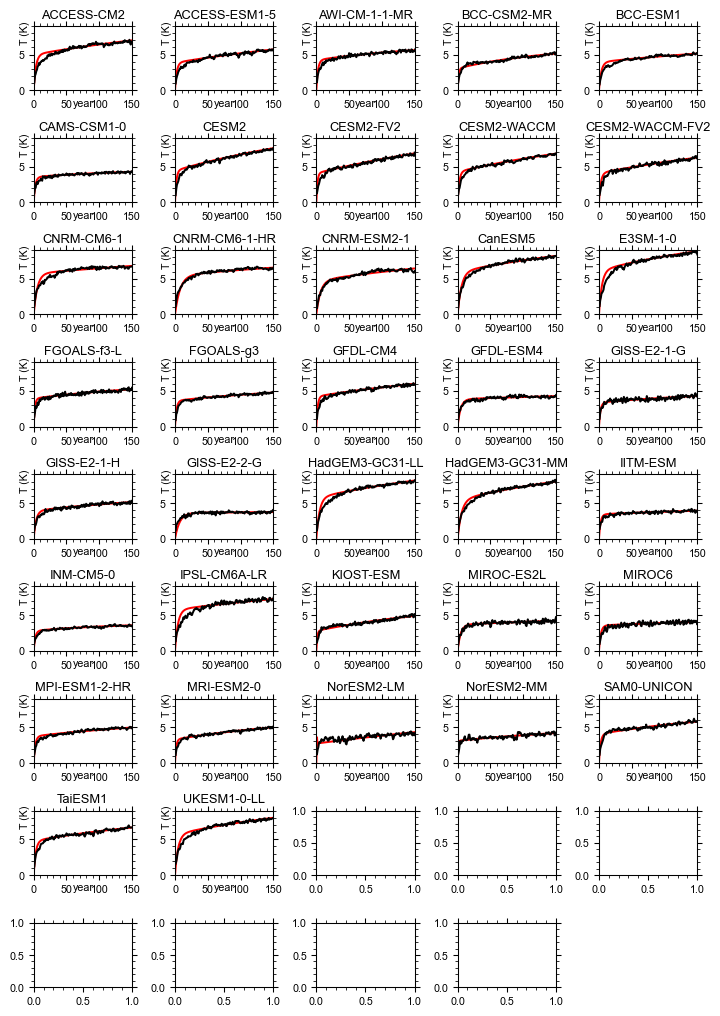

In [7]:
fig, ax = pl.subplots(9,5, figsize = (19/2.54,27/2.54))
for i, model in enumerate(sorted(accepted_models)):
    if i==44:
        labels=['Geoffroy model fit', 'CMIP6 model']
    else:
        labels=['','']
    ax[i//5,i%5].plot(np.arange(nyears[model]), tu[model], color='r', label=labels[0])
    ax[i//5,i%5].plot(np.arange(1,nyears[model]+1), T[model], color='k', label=labels[1])
    ax[i//5,i%5].set_xlabel('year')
    ax[i//5,i%5].xaxis.set_label_coords(0.5, -0.12)
    ax[i//5,i%5].set_ylabel('T (K)')
    ax[i//5,i%5].yaxis.set_label_coords(-0.035, 0.9)
    ax[i//5,i%5].set_title(model)
    ax[i//5,i%5].set_xlim(0,150)#(0,nyears[model])
    ax[i//5,i%5].set_ylim(0,9)#(0,np.max(np.concatenate((tg[model],T[model]))))
#ax[8,2].legend(loc='upper left', bbox_to_anchor=[1.15,1.1], fontsize=10);
#ax[6,2].axis('off')
ax[8,4].axis('off')
fig.tight_layout();

In [ ]:
len(T4x_gregory)

In [ ]:
len([value.magnitude for key,value in du.items()])

In [ ]:
params = {}
params['dl'] = {}
params['dl']['name'] = 'Depth of deep ocean layer'
params['dl']['units'] = 'm'
params['dl']['model_data'] = {key:value.magnitude for key,value in dl.items()}
params['dl']['mean'] = np.array([value.magnitude for key,value in dl.items()]).mean()

params['du'] = {}
params['du']['name'] = 'Depth of upper ocean layer'
params['du']['units'] = 'm'
params['du']['model_data'] = {key:value.magnitude for key,value in du.items()}
params['du']['mean'] = np.array([value.magnitude for key,value in du.items()]).mean()

params['eta'] = {}
params['eta']['name'] = 'Heat transfer coefficient'
params['eta']['units'] = 'W m**-2 K**-1'
params['eta']['model_data'] = gamma
params['eta']['mean'] = np.mean(list(gamma.values()))

params['efficacy'] = {}
params['efficacy']['name'] = 'Efficacy of deep ocean uptake'
params['efficacy']['units'] = 'dimensionless'
params['efficacy']['model_data'] = eff
params['efficacy']['mean'] = np.mean(list(eff.values()))

params['lambda0'] = {}
params['lambda0']['name'] = 'Global climate feedback parameter'
params['lambda0']['units'] = 'W m**-2 K**-1'
params['lambda0']['model_data'] = {key:-value for key,value in lambda0.items()}
params['lambda0']['mean'] = np.array([-value for key,value in lambda0.items()]).mean()

params['F4xCO2'] = {}
params['F4xCO2']['name'] = 'Effective Radiative Forcing [Gregory] for 4xCO2'
params['F4xCO2']['units'] = 'W m**-2'
params['F4xCO2']['model_data'] = F4x_gregory
params['F4xCO2']['mean'] = np.mean(list(F4x_gregory.values()))

params['T4xCO2'] = {}
params['T4xCO2']['name'] = 'Equilibrium temperature [Gregory] for 4xCO2'
params['T4xCO2']['units'] = 'K'
params['T4xCO2']['model_data'] = T4x_gregory
params['T4xCO2']['mean'] = np.mean(list(T4x_gregory.values()))

with open("../data_output/cmip6_twolayer_tuning_params.json", "w") as write_file:
    json.dump(params, write_file, indent=4)

In [ ]:
print(lambda0[model])
print(F4x_gregory[model])
print(T4x_gregory[model])
print(du[model])
print(dl[model])
print(gamma[model])
print(model)